# Create and/or update (Dutch) municipal datasets

## IMPORTANT NOTE
As of the 2023 municipal dataset update (August 2025), this notebook is only used to create the `pbl_all_data_2023.csv` file (found in the Quintel dropbox `756 Gemeentelijke datasets 2023/Grote databestanden` folder). It processes the municipal mergers between 2019-2023 and then a merged version of all separate municipal csv files received from the PBL referentieverbruiker in 2023. The pipeline for this process can be found in section [Process 2019-2023 municipality changes](#process-2019-2023-municipality-changes).

This notebook is no longer used for any other purposes. It also contains an attempted Application split for Households based on the PBL referentieverbruiken but the data is too limited to allow this (e.g. only electricity consumption for heating purposes is included).

To use it, it's best to move the notebook to the main pipelines folder. That way all Path references should work without further editing. Also check all imported data and make sure they are moved to the corresponding subfolders within Pipelines.

**TO DO** | Add "getting started" documentation

In [155]:
# internal modules
import os
import sys

# external modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
# import seaborn as sns
import xlwings as xw
import yaml
from pathlib import Path

# project modules
import config.config as config
from src.checks import Checker
from src.extract import PblService
from src.transform import Transformer

## Scope

Before we start we need to specify which datasets we want to create or update. This can be done with the `data.csv` file in the `config` directory. Here you can specify the geo ID, parent dataset and name for each region.

Also, make sure to specify the parent dataset and the year in the cell below.

**TO DO** | Add variable all_municipalities (based on the default etlocal config)

In [ ]:
# Select the parent data set. Make sure to use the geo ID. It should be existing in the Dataset Manager.
parent = "nl"

# Specify the year
year_etm = 2019
year = 2023

# Specify the CSV-separator (presumably either "," or ";")
sep=","

# Either specify the municipalities by using the data.csv file in the config directory.
# Make sure to specify the right separator in the pd.read_csv() function.
path = Path(f"data_{year}.csv")
municipalities = pd.read_csv(path, sep=sep)['geo_id'].to_list()

# Preview municipality geo IDs
municipalities

['GM1680',
 'GM0358',
 'GM0197',
 'GM0059',
 'GM0482',
 'GM0613',
 'GM0361',
 'GM0141',
 'GM0034',
 'GM0484',
 'GM1723',
 'GM1959',
 'GM0060',
 'GM0307',
 'GM0362',
 'GM0363',
 'GM0200',
 'GM0202',
 'GM0106',
 'GM0743',
 'GM0744',
 'GM0308',
 'GM0489',
 'GM0203',
 'GM0888',
 'GM1954',
 'GM0889',
 'GM1945',
 'GM1724',
 'GM0893',
 'GM0373',
 'GM0748',
 'GM1859',
 'GM1721',
 'GM0753',
 'GM0209',
 'GM0375',
 'GM0310',
 'GM1728',
 'GM0376',
 'GM0377',
 'GM1901',
 'GM0755',
 'GM1681',
 'GM0147',
 'GM0654',
 'GM0757',
 'GM0758',
 'GM1876',
 'GM0213',
 'GM0899',
 'GM0312',
 'GM0313',
 'GM0214',
 'GM0502',
 'GM0383',
 'GM0109',
 'GM1706',
 'GM0216',
 'GM0148',
 'GM1891',
 'GM0503',
 'GM0762',
 'GM0150',
 'GM0384',
 'GM1980',
 'GM1774',
 'GM0221',
 'GM0222',
 'GM0766',
 'GM0505',
 'GM0498',
 'GM1719',
 'GM0303',
 'GM0225',
 'GM0226',
 'GM1711',
 'GM0385',
 'GM0228',
 'GM0317',
 'GM1979',
 'GM0770',
 'GM1903',
 'GM0772',
 'GM0230',
 'GM0114',
 'GM0388',
 'GM0153',
 'GM0232',
 'GM0233',
 'GM0777',

We also need to import the municipalities from 2019 to process merged municipalities between 2019-2023.

In [ ]:
municipalities_2019 = pd.read_csv(Path("data_2019.csv"), sep=sep)['geo_id'].to_list()
# Preview municipality geo IDs for 2019
municipalities_2019

['GM1680',
 'GM0358',
 'GM0197',
 'GM0059',
 'GM0482',
 'GM0613',
 'GM0361',
 'GM0141',
 'GM0034',
 'GM0484',
 'GM1723',
 'GM1959',
 'GM0060',
 'GM0307',
 'GM0362',
 'GM0363',
 'GM0200',
 'GM0003',
 'GM0202',
 'GM0106',
 'GM0743',
 'GM0744',
 'GM0308',
 'GM0489',
 'GM0203',
 'GM0888',
 'GM1954',
 'GM0370',
 'GM0889',
 'GM1945',
 'GM1724',
 'GM0893',
 'GM0373',
 'GM0748',
 'GM1859',
 'GM1721',
 'GM0753',
 'GM0209',
 'GM0375',
 'GM0310',
 'GM1728',
 'GM0376',
 'GM0377',
 'GM1901',
 'GM0755',
 'GM1681',
 'GM0147',
 'GM0654',
 'GM0756',
 'GM0757',
 'GM0758',
 'GM0501',
 'GM1876',
 'GM0213',
 'GM0899',
 'GM0312',
 'GM0313',
 'GM0214',
 'GM0502',
 'GM0383',
 'GM0109',
 'GM1706',
 'GM1684',
 'GM0216',
 'GM0148',
 'GM1891',
 'GM0503',
 'GM0010',
 'GM0762',
 'GM0150',
 'GM0384',
 'GM1774',
 'GM0221',
 'GM0222',
 'GM0766',
 'GM0505',
 'GM0498',
 'GM1719',
 'GM0303',
 'GM0225',
 'GM0226',
 'GM1711',
 'GM0385',
 'GM0228',
 'GM0317',
 'GM0770',
 'GM1903',
 'GM0772',
 'GM0230',
 'GM0114',
 'GM0388',

In [149]:
# Calculate municipalities added since 2019
municipalities_added = list(set(municipalities) - set(municipalities_2019))
# Preview 
print(f"Municipalities added: {municipalities_added}")

# Calculate municipalities removed since 2019
municipalities_removed = list(set(municipalities_2019) - set(municipalities))
# Preview
print(f"Municipalities removed: {municipalities_removed}")

Municipalities added: ['GM1979', 'GM1982', 'GM1980', 'GM1991', 'GM1992']
Municipalities removed: ['GM0788', 'GM0457', 'GM0024', 'GM0370', 'GM0010', 'GM0501', 'GM0756', 'GM1684', 'GM0003', 'GM0416', 'GM0614', 'GM1702', 'GM0398', 'GM0530', 'GM0856', 'GM1685', 'GM0786', 'GM0815']


## Setup

In this step, we will setup some files and data which is relevant for all different sectors:
* Collecting the parent dataset from the ETM dataset manager
* Initializing the (empty) ETLocal template

### Collect the parent dataset from the ETM dataset manager 

In case certain data points are not available for the given region, we want to inherit the values of the parent dataset. For the municipality datasets, the parent is the NL2019 dataset.

##### Import pre-existing file

(July 2025) The API approach below doesn't seem to work (anymore). Until the 2023 NL dataset is online we rely on a March 2024 export of the nl2019 dataset

In [111]:
df_parent = pd.read_csv(Path("data", "intermediate", f"parent_data_{year_etm}.csv"), sep=sep)

# preview
df_parent.T.head(20)

,0
Unnamed: 0,nl
agriculture_final_demand_electricity_demand,41584.615
agriculture_final_demand_network_gas_demand,91072.918
input_agriculture_final_demand_steam_hot_water_demand,2783.107
agriculture_final_demand_wood_pellets_demand,5437.224
input_agriculture_final_demand_crude_oil_demand,17965.442
agriculture_final_demand_hydrogen_demand,0.0
input_percentage_of_central_mt_steam_hot_water_agriculture_final_demand_steam_hot_water,0.0
input_percentage_of_central_ht_steam_hot_water_agriculture_final_demand_steam_hot_water,1.0
input_percentage_of_local_steam_hot_water_agriculture_final_demand_steam_hot_water,0.0


#### (optional) Calling ETM Dataset Manager API directly

##### Extract
In this step we call the ETM Dataset Manager API to get the parent dataset.

In [150]:
# Connect to the ETM dataset manager API and collect the parent dataset 
response = requests.get(f"https://data.energytransitionmodel.com/api/v1/exports/{parent}")

In [151]:
# Check if the response has been successful. If the code is anything else than 200, something went wrong.
response.status_code

200

In [152]:
response

<Response [200]>

Here is an overview of the different status codes and what these imply:

- **200**: Everything went okay, and the result has been returned (if any).
- **301**: The server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
- **400**: The server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
- **401**: The server thinks you’re not authenticated. Many APIs require login ccredentials, so this happens when you don’t send the right credentials to access an API.
- **403**: The resource you’re trying to access is forbidden: you don’t have the right perlessons to see it.
- **404**: The resource you tried to access wasn’t found on the server.
- **503**: The server is not ready to handle the request.

In [153]:
# In that case, print the error message to see what caused the error
response.reason

'OK'

##### Transform


In [154]:
# If the reponse has been successful, collect its data.

# The data is stored as a dict in a single-itemed array. To get the dict, get the first item of the array.
raw_parent_data = response.json()[0]

# Then, create a dataframe from the dict.
df_parent = pd.DataFrame(raw_parent_data, index=[0])

# Rename the index to nl
df_parent = df_parent.rename(index={0: 'nl'})

IndexError: list index out of range

In [ ]:
# Preview the data in its transposed form (by using .T)
df_parent.T

,nl
agriculture_final_demand_electricity_demand,41584.615
agriculture_final_demand_network_gas_demand,91072.918
input_agriculture_final_demand_steam_hot_water_demand,2783.107
agriculture_final_demand_wood_pellets_demand,5437.224
input_agriculture_final_demand_crude_oil_demand,17965.442
...,...
input_transport_ship_electricity_demand,0.0
bunkers_total_useful_demand_ships_demand,478316.636
area,NL_netherlands
base_dataset,eu


##### Load 
Save the parent data set to the intermediate data folder.

In [ ]:
# Write dataframe to intermediate data folder
df_parent.to_csv(f"data/intermediate/parent_data_{year_etm}.csv")

### Initialize (empty) ETLocal templates
NOTE JULY 2025: the ETLocal template is created in the 'Extract\ and\ preprocess\ source\ data.ipynb' notebook.
We therefore import the ETLocal template from the data/intermediate folder.

In [43]:
# import the template from the data/intermediate folder
path = Path("data", "intermediate", f"etlocal_template_empty_2025.csv")
template = pd.read_csv(path, sep=sep)

# Transform the templates into a multi-index dataframe
index = pd.MultiIndex.from_frame(template[['geo_id', 'group', 'subgroup', 'key']])
template = template.drop(columns=['geo_id', 'group', 'subgroup', 'key'])
template.index = index

# Preview merged template
template

unit  \
geo_id group       subgroup                  key                                                       
GM1680 agriculture agriculture_heat_chp      agriculture_chp_engine_network_gas_dispatchable...   TJ   
                                             agriculture_chp_engine_biogas_demand                 TJ   
                                             agriculture_chp_wood_pellets_demand                  TJ   
                   agriculture_energy_demand agriculture_final_demand_electricity_demand          TJ   
                                             agriculture_final_demand_network_gas_demand          TJ   
...                                                                                              ...   
GM0193 industry    industry_paper            input_industry_paper_wood_pellets_demand             TJ   
                                             input_industry_paper_crude_oil_demand                TJ   
                                             input_industry_paper_coal_demand                     TJ   
                                             industry_final_demand_for_other_paper_electrici...    %   
                                             industry_final_demand_for_other_paper_electrici...    %   

                                                                                                 value  \
geo_id group       subgroup                  key                                                         
GM1680 agriculture agriculture_heat_chp      agriculture_chp_engine_network_gas_dispatchable...    NaN   
                                             agriculture_chp_engine_biogas_demand                  NaN   
                                             agriculture_chp_wood_pellets_demand                   NaN   
                   agriculture_energy_demand agriculture_final_demand_electricity_demand           NaN   
                                             agriculture_final_demand_network_gas_demand           NaN   
...                                                                                                ...   
GM0193 industry    industry_paper            input_industry_paper_wood_pellets_demand              NaN   
                                             input_industry_paper_crude_oil_demand                 NaN   
                                             input_industry_paper_coal_demand                      NaN   
                                             industry_final_demand_for_other_paper_electrici...    NaN   
                                             industry_final_demand_for_other_paper_electrici...    NaN   

                                                                                                 commit  
geo_id group       subgroup                  key                                                         
GM1680 agriculture agriculture_heat_chp      agriculture_chp_engine_network_gas_dispatchable...     NaN  
                                             agriculture_chp_engine_biogas_demand                   NaN  
                                             agriculture_chp_wood_pellets_demand                    NaN  
                   agriculture_energy_demand agriculture_final_demand_electricity_demand            NaN  
                                             agriculture_final_demand_network_gas_demand            NaN  
...                                                                                                 ...  
GM0193 industry    industry_paper            input_industry_paper_wood_pellets_demand               NaN  
                                             input_industry_paper_crude_oil_demand                  NaN  
                                             input_industry_paper_coal_demand                       NaN  
                                             industry_final_demand_for_other_paper_electrici...     NaN  
                                             industry_final_demand_for_other_paper_electrici

##### (old) Generate template directly

The code below is kept for reference, but not used anymore.

Only run these cells if you want to create empty ETLocal templates. If the templates have been filled in other steps, these changes will be overwritten. If you don't want to overwrite your changes, **DON'T** run the cells below. :-) 

In [ ]:
# # First, initialize data.csv file based on the config file
# path = Path("config", "data.csv")
# df_data_csv = pd.read_csv(path, index_col=[0], sep=sep)

# # Drop unnamed columns
# df_data_csv = df_data_csv.drop(columns=df_data_csv.columns[df_data_csv.columns.str.startswith('Unnamed')])

# # Preview dataframe representing data.csv
# df_data_csv

,country,name
geo_id,,
GM0003,nl2019,Appingedam
GM0010,nl2019,Delfzijl
GM0024,nl2019,Loppersum
GM1680,nl2019,Aa en Hunze
GM0358,nl2019,Aalsmeer
...,...,...
GM0879,nl2019,Zundert
GM0301,nl2019,Zutphen
GM1896,nl2019,Zwartewaterland


In [ ]:
# # Then, initialize commits.yml file by specifying the file path where you want to create the YAML file
# path = Path("data", "reporting", "commits.yml")

# # Write the document separator to the YAML file
# with open(path, 'w') as file:
#     file.write('---\n')

In [ ]:
# # TODO: Describe that by running this cell an empty template is created. This overwrites the filled template.

# # Load ETLocal template with target keys from config
# path = Path("config", "etlocal_interface_elements.csv")
# empty_template = pd.read_csv(path, header=[0], sep=sep)#, index_col=[2])

# # Add columns geo_id, value and commit to the template    
# for column in ['geo_id', 'value', 'commit']:
#     empty_template[column] = float('nan')
    
# # Fill the geo_id column with all relevant municipal geo IDs
# templates = []
# for municipality in municipalities:
#     template_to_add = empty_template.copy()
#     template_to_add['geo_id'] = municipality
#     templates.append(template_to_add)
    
# # Concatenate list of templates to one big template with all municipalities
# template = pd.concat(templates)

# # Transform the templates into a multi-index dataframe
# index = pd.MultiIndex.from_frame(template[['geo_id', 'group', 'subgroup', 'key']])
# template = template.drop(columns=['geo_id', 'group', 'subgroup', 'key'])
# template.index = index

# # Preview merged template
# template

unit  \
geo_id group      subgroup                 key                                                         
GM0003 area       area_emission_factors    file_carriers_imported_heat_co2_conversion_per_mj   kg/MJ   
                                           file_carriers_propane_co2_conversion_per_mj         kg/MJ   
       households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...      %   
                                           input_percentage_of_mt_steam_hot_water_househol...      %   
                                           input_percentage_of_ht_steam_hot_water_househol...      %   
...                                                                                              ...   
GM0193 energy     energy_heat_production   energy_heat_import_mt_steam_hot_water_demand           TJ   
                                           energy_heat_import_ht_steam_hot_water_demand           TJ   
                  energy_energy_demand     input_energy_heat_distribution_ht_loss_share            %   
                                           input_energy_heat_distribution_mt_loss_share            %   
                                           input_energy_heat_distribution_lt_loss_share            %   

                                                                                               value  \
geo_id group      subgroup                 key                                                         
GM0003 area       area_emission_factors    file_carriers_imported_heat_co2_conversion_per_mj     NaN   
                                           file_carriers_propane_co2_conversion_per_mj           NaN   
       households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...    NaN   
                                           input_percentage_of_mt_steam_hot_water_househol...    NaN   
                                           input_percentage_of_ht_steam_hot_water_househol...    NaN   
...                                                                                              ...   
GM0193 energy     energy_heat_production   energy_heat_import_mt_steam_hot_water_demand          NaN   
                                           energy_heat_import_ht_steam_hot_water_demand          NaN   
                  energy_energy_demand     input_energy_heat_distribution_ht_loss_share          NaN   
                                           input_energy_heat_distribution_mt_loss_share          NaN   
                                           input_energy_heat_distribution_lt_loss_share          NaN   

                                                                                               commit  
geo_id group      subgroup                 key                                                         
GM0003 area       area_emission_factors    file_carriers_imported_heat_co2_conversion_per_mj      NaN  
                                           file_carriers_propane_co2_conversion_per_mj            NaN  
       households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...     NaN  
                                           input_percentage_of_mt_steam_hot_water_househol...     NaN  
                                           input_percentage_of_ht_steam_hot_water_househol...     NaN  
...                                                                                               ...  
GM0193 energy     energy_heat_production   energy_heat_import_mt_steam_hot_water_demand           NaN  
                                           energy_heat_import_ht_steam_hot_water_demand           NaN  
                  energy_energy_demand     input_energy_heat_distribution_ht_loss_share           NaN  
                                           input_energy_heat_distribution_mt_loss_share           NaN  
                                           input_energy_heat_distribution_lt_loss_share           NaN  

[42955 rows x 3 columns]

## General

### 1. Data collection

In [ ]:
# TODO

In the data collection phase, we make an overview of the required data and design a data model to efficiently build our database. If possible, we call the API to collect our data. Otherwise, we first manually collect a data export and store it in the `data / raw` directory.

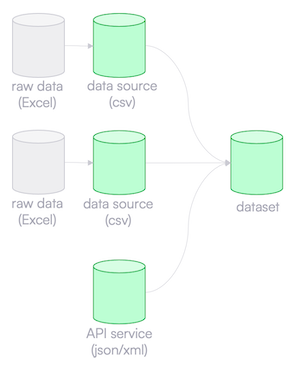

For the municipal datasets we use the following data sources:
* **??** | ...
* **Dataset manager** | to collect the parent dataset

For each data source, the following steps are followed:
* **Extract** | Extracting the raw data from its source
* **Transform** | Transforming the raw data to a 'workable' format 
* **Load** | Writing the processed data to the intermediate data directory


In [ ]:
# TODO

### 2. Data quality

In [ ]:
# TODO

#### Setup

Setup the checker and load all files from the `data / intermediate` directory.

First, setup the checker class

In [ ]:
# Initialise checker class to access transformation functions
checker = Checker()

Then, setup all data files:
- ...
- parent data

### 3. Data transformation

In [ ]:
# TODO

#### Setup

Setup the transformer and load all intermediate data files for the next step in the pipeline.

First, setup the transformer class:

In [ ]:
# Initialise transformer class to access transformation functions
transformer = Transformer(municipalities, year)

Then, setup all data files:
- dataframe representing data.csv 
- commits.yml
- dataframe with all etlocal interface elements
- ...
- parent data

##### Load parent data

In [ ]:
# Import parent data
path = Path("data", "intermediate", "parent_data.csv")
df_parent = pd.read_csv(path, index_col=0)

# Preview parent data
df_parent.T.head()

,nl
agriculture_final_demand_electricity_demand,41584.615
agriculture_final_demand_network_gas_demand,91072.918
input_agriculture_final_demand_steam_hot_water_demand,2783.107
agriculture_final_demand_wood_pellets_demand,5437.224
input_agriculture_final_demand_crude_oil_demand,17965.442


#### Emission factors
Transform the data to the right format. 

##### List ETLocal keys

Preview the ETLocal keys that are relevant for the agriculture energy demand category

In [146]:
# Filter the ETLocal keys that are relevant for the emission factors category
filter_emission_factors = (slice(None), 'area', 'area_emission_factors')

# Preview the filtered template
template.loc[filter_emission_factors, :]

unit  \
geo_id group subgroup              key                                                         
GM1680 area  area_emission_factors file_carriers_natural_gas_co2_conversion_per_mj     kg/MJ   
                                   file_carriers_crude_oil_co2_conversion_per_mj       kg/MJ   
                                   file_carriers_coal_co2_conversion_per_mj            kg/MJ   
                                   file_carriers_lignite_co2_conversion_per_mj         kg/MJ   
                                   file_carriers_non_biogenic_waste_co2_conversion...  kg/MJ   
...                                                                                      ...   
GM0193 area  area_emission_factors file_carriers_lpg_co2_conversion_per_mj             kg/MJ   
                                   file_carriers_imported_electricity_co2_conversi...  kg/MJ   
                                   file_carriers_imported_heat_co2_conversion_per_mj   kg/MJ   
                                   file_carriers_imported_hydrogen_co2_conversion_...  kg/MJ   
                                   file_carriers_imported_ammonia_co2_conversion_p...  kg/MJ   

                                                                                       value  \
geo_id group subgroup              key                                                         
GM1680 area  area_emission_factors file_carriers_natural_gas_co2_conversion_per_mj       NaN   
                                   file_carriers_crude_oil_co2_conversion_per_mj         NaN   
                                   file_carriers_coal_co2_conversion_per_mj              NaN   
                                   file_carriers_lignite_co2_conversion_per_mj           NaN   
                                   file_carriers_non_biogenic_waste_co2_conversion...    NaN   
...                                                                                      ...   
GM0193 area  area_emission_factors file_carriers_lpg_co2_conversion_per_mj               NaN   
                                   file_carriers_imported_electricity_co2_conversi...    NaN   
                                   file_carriers_imported_heat_co2_conversion_per_mj    0.03   
                                   file_carriers_imported_hydrogen_co2_conversion_...    NaN   
                                   file_carriers_imported_ammonia_co2_conversion_p...    NaN   

                                                                                                                                  commit  
geo_id group subgroup              key                                                                                                    
GM1680 area  area_emission_factors file_carriers_natural_gas_co2_conversion_per_mj                                                   NaN  
                                   file_carriers_crude_oil_co2_conversion_per_mj                                                     NaN  
                                   file_carriers_coal_co2_conversion_per_mj                                                          NaN  
                                   file_carriers_lignite_co2_conversion_per_mj                                                       NaN  
                                   file_carriers_non_biogenic_waste_co2_conversion...                                                NaN  
...                                                                                                                                  ...  
GM0193 area  area_emission_factors file_carriers_lpg_co2_conversion_per_mj                                                           NaN  
                                   file_carriers_imported_electricity_co2_conversi...                                                NaN  
                                   file_carriers_imported_heat_co2_conversion_per_mj   Based on https://co2emissiefactoren.nl/factore...  
                                   file_carriers_imported_hyd

##### Fill missing values

Then, fill the missing values for:
- Imported heat
- Propane
- ...

**Imported heat** | Emission factors are cross-regionals. Hence, we use the same values for all datasets.

In [141]:
# TODO: we could also use the parent data shares instead?
key = f'file_carriers_imported_heat_co2_conversion_per_mj'

val = 0.03 

# Update value and corresponding commit message for the temperature level share
template.loc[(slice(None), slice(None), slice(None), key), 'value'] = val
template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"Based on https://co2emissiefactoren.nl/factoren/2023/12/48/warmtelevering-gemiddelde-warmtenetten/?unit=mj" 

**Propane** | Emission factors are cross-regionals. Hence, we use the same values for all datasets.

In [144]:
key = f'file_carriers_propane_co2_conversion_per_mj'

# Let's use the parent data
val = 0.6448 # manually imported from nl2019 dataset in ETSource/datasets/nl2019/carriers.csv

# Update value and corresponding commit message for the temperature level share
template.loc[(slice(None), slice(None), slice(None), key), 'value'] = val
template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"Adopted from the parent dataset ({parent})" # TODO: Describe which exact data is used

In [147]:
# Preview template after changes
template.loc[filter_emission_factors, :].head()

unit  \
geo_id group subgroup              key                                                         
GM1680 area  area_emission_factors file_carriers_natural_gas_co2_conversion_per_mj     kg/MJ   
                                   file_carriers_crude_oil_co2_conversion_per_mj       kg/MJ   
                                   file_carriers_coal_co2_conversion_per_mj            kg/MJ   
                                   file_carriers_lignite_co2_conversion_per_mj         kg/MJ   
                                   file_carriers_non_biogenic_waste_co2_conversion...  kg/MJ   

                                                                                       value  \
geo_id group subgroup              key                                                         
GM1680 area  area_emission_factors file_carriers_natural_gas_co2_conversion_per_mj       NaN   
                                   file_carriers_crude_oil_co2_conversion_per_mj         NaN   
                                   file_carriers_coal_co2_conversion_per_mj              NaN   
                                   file_carriers_lignite_co2_conversion_per_mj           NaN   
                                   file_carriers_non_biogenic_waste_co2_conversion...    NaN   

                                                                                      commit  
geo_id group subgroup              key                                                        
GM1680 area  area_emission_factors file_carriers_natural_gas_co2_conversion_per_mj       NaN  
                                   file_carriers_crude_oil_co2_conversion_per_mj         NaN  
                                   file_carriers_coal_co2_conversion_per_mj              NaN  
                                   file_carriers_lignite_co2_conversion_per_mj           NaN  
                                   file_carriers_non_biogenic_waste_co2_conversion...    NaN

#### Exceptions

If there are any exceptions for municipal datasets, you can overwrite the values below.

**TO DO** | Explain to the user that this section should always be checked. Should the exception be overwritten by the update? Or should it remain untouched?

##### Gemeente X

In [ ]:
#

#### Export processed data
Write the transformed data to our  `data / processed` directory. This is the data we will be using for the next (analysis and visualisation) steps in the pipeline.

In [ ]:
# Write dataframe to intermediate data folder
path = Path("data", "processed", "etlocal_template.csv")
template.to_csv(path)

### 4. Data analysis and visualisation

In [ ]:
# TODO

## Households

In this section we focus on the data of the households sector: energy demand, energy supply, housing stock and application shares.

### 1. Data collection (extract, transform, load)

In the data collection phase, we make an overview of the required data and design a data model to efficiently build our database. If possible, we call the API to collect our data. Otherwise, we first manually collect a data export and store it in the `data / raw` directory.

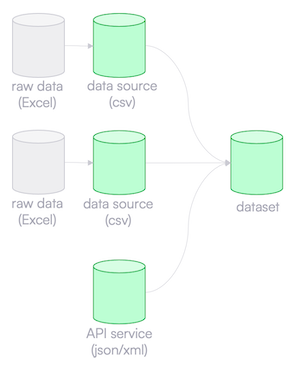

For the municipal datasets we use the following data sources:
* **Klimaatmonitor** | to collect municipal data about energy demand, supply and housing stock
* **Referentieverbruiken PBL** | to collect municipal data about application shares
* **Dataset manager** | to collect the parent dataset

For each data source, the following steps are followed:
* **Extract** | Extracting the raw data from its source
* **Transform** | Transforming the raw data to a 'workable' format 
* **Load** | Writing the processed data to the intermediate data directory


#### Klimaatmonitor

Klimaatmonitor is used to determine the final demand per carrier for each municipality, using the following the keys:

- inwoners
- woningen
- el_woningen_tj_incl_zonachtermeter
- gaswoningen
- warmwontier2
- houtskool
- houtwontj
- zonpvtj_won

**TO DO** | Describe the steps for retrieving the raw data from Klimaatmonitor

##### Extract

We start with collecting the relevant data from the data export. This results in a dataframe with key/value combinations for all Dutch municipalities.

In [44]:
# # Source data retrieves all KM data for each municipality
path_km = Path("data", "raw", f"Klimaatmonitor - Thema's - {year} - Gemeenten - Creating or updating datasets notebook.xlsx")
wb_km = xw.Book(str(path_km))
ws_km_source_data = wb_km.sheets["Data"]

df_km_source_data = pd.DataFrame(ws_km_source_data.used_range.value)
df_km_source_data.columns = df_km_source_data.iloc[0]
df_km_source_data = df_km_source_data[1:]
df_km_source_data = df_km_source_data.set_index(df_km_source_data.columns[1])

# Close the Excel workbook
wb_km.close()

In [45]:
# # Preview
df_km_source_data.head()

,Gebieden,inwoners_2023,woningen_2023,kern231a_elk_tot_2023,gaswoningen_2023,warmwontier2_2023,houtskool_2023,houtwontj_2023,zonpvtj_won_2023
Code,,,,,,,,,
1680,Aa en Hunze,25724.0,11428.0,145.0,12.4,0.0,0.0,66.0,77.0
358,Aalsmeer,33063.0,13460.0,152.0,11.9,0.0,0.0,37.0,59.0
197,Aalten,27244.0,12164.0,139.0,10.9,0.0,0.0,51.0,64.0
59,Achtkarspelen,28149.0,12289.0,134.0,12.0,0.0,0.0,64.0,60.0
482,Alblasserdam,20356.0,8449.0,83.0,6.0,2000.0,0.0,10.0,25.0


In [46]:
    # The code for el_woningen_tj_incl_zonachtermeter has changed to 'kern231a_elk_tot'. Let's rename this column back
df_km_source_data = df_km_source_data.rename(columns={f'kern231a_elk_tot_{year}': f'el_woningen_tj_incl_zonachtermeter_{year}'})
df_km_source_data

,Gebieden,inwoners_2023,woningen_2023,el_woningen_tj_incl_zonachtermeter_2023,gaswoningen_2023,warmwontier2_2023,houtskool_2023,houtwontj_2023,zonpvtj_won_2023
Code,,,,,,,,,
1680,Aa en Hunze,25724.0,11428.0,145.0,12.4,0.0,0.0,66.0,77.0
358,Aalsmeer,33063.0,13460.0,152.0,11.9,0.0,0.0,37.0,59.0
197,Aalten,27244.0,12164.0,139.0,10.9,0.0,0.0,51.0,64.0
59,Achtkarspelen,28149.0,12289.0,134.0,12.0,0.0,0.0,64.0,60.0
482,Alblasserdam,20356.0,8449.0,83.0,6.0,2000.0,0.0,10.0,25.0
...,...,...,...,...,...,...,...,...,...
301,Zutphen,48510.0,23381.0,213.0,17.9,0.0,1.0,35.0,74.0
1896,Zwartewaterland,23368.0,9196.0,105.0,8.4,0.0,0.0,34.0,41.0
642,Zwijndrecht,45018.0,20828.0,197.0,15.8,1000.0,1.0,18.0,62.0


Next, we collect the relevant meta data for each key (or "topic"). This provides us with information about, among others, the topic and unit for each key.

In [47]:
# Meta data is used to generate commit messages and extract the unit
path_km = Path("data", "raw", f"Klimaatmonitor - Thema's - {year} - Gemeenten - Creating or updating datasets notebook.xlsx")
wb_km = xw.Book(str(path_km))
ws_km_meta_data = wb_km.sheets["Onderwerp Informatie"]

df_km_meta_data = pd.DataFrame(ws_km_meta_data.used_range.value)
df_km_meta_data.columns = df_km_meta_data.iloc[0]
df_km_meta_data = df_km_meta_data[1:]
df_km_meta_data = df_km_meta_data.set_index(df_km_meta_data.columns[0])

# Close the Excel workbook
wb_km.close()

In [48]:
# # Preview
df_km_meta_data.head()

,Onderwerp,Eenheid,Bron,Voetnoot,Beschrijving,Gegevenstype,Laatste database wijziging
Code,,,,,,,
inwoners,Aantal inwoners,aantal,CBS - Kerncijfers Wijken en buurten,None,None,Numeriek,6-6-2025 08:16:58
woningen,Aantal woningen per 1 januari,aantal,CBS - Kerncijfers Wijken en buurten,None,None,Numeriek,27-3-2025 09:31:04
kern231a_elk_tot,Totaal elektriciteitsverbruik woningen incl. z...,TJ,CBS - Statistiek energieverbruik woningen,None,None,Numeriek,16-7-2025 14:19:45
gaswoningen,Totaal aardgasverbruik woningen,miljoen m3,Berekening totaalverbruik woningen o.b.v. gem...,None,None,Numeriek,27-3-2025 10:04:20
warmwontier2,Verbruik stadswarmte woningen,GJ,Duurzaamheidsrapportage warmtenetten RVO en hi...,None,None,Numeriek,16-7-2025 14:17:00


In [49]:
# Add a voetnoot explaining how we renamed the kern231a_elk_tot column
footnote = "(Quintel) Renamed to 'el_woningen_tj_incl_zonachtermeter' to match the existing script for dataset updates."
df_km_meta_data.loc['kern231a_elk_tot', 'Voetnoot'] = footnote
df_km_meta_data

,Onderwerp,Eenheid,Bron,Voetnoot,Beschrijving,Gegevenstype,Laatste database wijziging
Code,,,,,,,
inwoners,Aantal inwoners,aantal,CBS - Kerncijfers Wijken en buurten,None,None,Numeriek,6-6-2025 08:16:58
woningen,Aantal woningen per 1 januari,aantal,CBS - Kerncijfers Wijken en buurten,None,None,Numeriek,27-3-2025 09:31:04
kern231a_elk_tot,Totaal elektriciteitsverbruik woningen incl. z...,TJ,CBS - Statistiek energieverbruik woningen,(Quintel) Renamed to 'el_woningen_tj_incl_zona...,None,Numeriek,16-7-2025 14:19:45
gaswoningen,Totaal aardgasverbruik woningen,miljoen m3,Berekening totaalverbruik woningen o.b.v. gem...,None,None,Numeriek,27-3-2025 10:04:20
warmwontier2,Verbruik stadswarmte woningen,GJ,Duurzaamheidsrapportage warmtenetten RVO en hi...,None,None,Numeriek,16-7-2025 14:17:00
houtskool,Houtskool hern. warmte,TJ,Verdeling regionale gegevens hernieuwbare ener...,None,None,Numeriek,6-6-2025 08:15:11
houtwontj,Houtkachels woningen hern. warmte,TJ,Verdeling regionale gegevens hernieuwbare ener...,None,None,Numeriek,12-6-2025 13:19:27
zonpvtj_won,Zonnestroom opgewekt door zonnepanelen op woni...,TJ,CBS - Statistiek zonnestroom en schatting RVO,None,None,Numeriek,16-7-2025 14:19:45


##### Transform

We need to transform the municipal codes to the geo ID format that the ETM is familiar with. Thus, we need to paste "GM" and possibly some zeros in front of the code.

In [50]:
# # Fill GM code to match desired area code structure
df_km_source_data.index = df_km_source_data.index.str.zfill(4).map(lambda x: 'GM' + x)

In [51]:
# # Preview
df_km_source_data.head()

,Gebieden,inwoners_2023,woningen_2023,el_woningen_tj_incl_zonachtermeter_2023,gaswoningen_2023,warmwontier2_2023,houtskool_2023,houtwontj_2023,zonpvtj_won_2023
Code,,,,,,,,,
GM1680,Aa en Hunze,25724.0,11428.0,145.0,12.4,0.0,0.0,66.0,77.0
GM0358,Aalsmeer,33063.0,13460.0,152.0,11.9,0.0,0.0,37.0,59.0
GM0197,Aalten,27244.0,12164.0,139.0,10.9,0.0,0.0,51.0,64.0
GM0059,Achtkarspelen,28149.0,12289.0,134.0,12.0,0.0,0.0,64.0,60.0
GM0482,Alblasserdam,20356.0,8449.0,83.0,6.0,2000.0,0.0,10.0,25.0


##### Load

We're now done with the data collection from Klimaatmonitor. Let's store our data in the `data / intermediate` directory.

In [ ]:
# # Write dataframe to intermediate data folder
df_km_source_data.to_csv(f"data/intermediate/klimaatmonitor_source_data_{year}_creating_or_updating_datasets_notebook.csv")

In [ ]:
# # Write dataframe to intermediate data folder
df_km_meta_data.to_csv(f"data/intermediate/klimaatmonitor_meta_data_{year}_creating_or_updating_datasets_notebook.csv")

#### Referentieverbruiken PBL

The "referentieverbruiken" study by PBL is used to calculate the application shares for each municipality.

Here, we use the complete csv files that Quintel received directly from PBL. These differ from both the csvs and the Excel files available on the VIVET referentieverbruiken page ([link](https://dataportaal.pbl.nl/VIVET/Referentieverbruik_warmte)). 

There is a csv file for each 2020 municipality. The list of municipalities in 2020 were the same as in 2019 fortunately ([link](https://www.cbs.nl/nl-nl/onze-diensten/methoden/classificaties/overig/gemeentelijke-indelingen-per-jaar/indeling-per-jaar/gemeentelijke-indeling-op-1-januari-2020))

##### Extract

Import the csvs for all municipalities and convert them to a dictionary of dataframes.

These csvs are too big for GitHub. They can be found on the Quintel Dropbox (Projects - Inactive - 2023_projects - 632 Heat Improvements - 1. Warmte in gebouwde omgeving - Referentieverbruiken)

In [ ]:
## NOTE JULY 2025: this cell is not used anymore, as we now use the raw data files that Quintel received directly from PBL.

# # Call the PBL referentieverbruiken service and store the raw Excel data in the "data / raw" directory
# # It's not necessary to run this step if the raw Excel data is yet present in the directory
# for municipality in municipalities:
#     PblService(municipality).call()

In [7]:
# # Transform and load the raw Excel data to a workable dataframe format
df_pbl_raw = {}
for municipality in municipalities:
    # Initialise the path to the application shares data by PBL
    try:
        path = Path("data", "raw", "pbl_referentieverbruiken", f"{municipality}.csv")
        # load the csv as a dataframe and add to dict
        df_pbl_raw[municipality] = pd.read_csv(path, index_col=0, sep=';')
    except:
        print(f"Data for {municipality} not found.")
        continue
    
# Preview dataframe for the first municipality in the dict
df_pbl_raw[municipalities[0]]

# NOTE JULY 2025: The original version of this notebook referred to Excel files for each municipality but we use the csvs provided by PBL
# The code below is therefore kept for reference, but not used in the current pipeline.

    # wb = xw.Book(path)
    # ws = wb.sheets["Resultaten gemeente"]
    
    # # Add the dataframe to the dict
    # df_pbl_raw[municipality] = pd.DataFrame(ws.used_range.value)

    # # Close the workbook
    # wb.close()
    
# NB: Excel will open the relevant files after running this cell.
# Make sure not to actively close them. The files should close themselves 
# after all steps from the data collection have been run.

Data for GM1980 not found.
Data for GM1979 not found.
Data for GM1982 not found.
Data for GM1991 not found.
Data for GM1992 not found.


,Woning/vbo_id,Adres/Postcode_huisnummer,Aantal bewoners/Aantal bewoners,Regio/gemeente,Regio/wijk,Regio/buurtcode,Woningkenmerken/Kenmerken,Woningkenmerken/woningtype,Woningkenmerken/bouwperiode,Woningkenmerken/bouwjaar,...,Metervraag olie/ruimteverwarming basis,Metervraag olie/ruimteverwarming piek,Metervraag totaal/aardgas,Metervraag totaal/elektriciteit,Metervraag totaal/warmtenet,Metervraag totaal/waterstof,Metervraag totaal/biomassa,Metervraag totaal/olie,Metervraag totaal/totaal,Regionale klimaatcorrectie/regionale klimaatcorrectie
6684371,'1680010000000001','9461GC_6',1.0,1680,168017,'BU16801700','2 onder 1 kap_1930 - 1945_parthuur',2,1,1935,...,0.0,0.0,23.3,0.1,0.0,0.0,0.0,0.0,23.4,1.1
6684372,'1680010000000002','9461HE_3',1.0,1680,168017,'BU16801700','Vrijstaand_1992 - 1995_koop',1,5,1995,...,0.0,0.0,25.6,0.1,0.0,0.0,0.0,0.0,25.8,1.1
6684373,'1680010000000003','9463TA_1',2.0,1680,168001,'BU16800109','Vrijstaand_voor 1930_koop',1,0,1890,...,0.0,0.0,37.1,0.2,0.0,0.0,0.0,0.0,37.2,1.1
6684374,'1680010000000004','9468ES_73',3.0,1680,168000,'BU16800000','2 onder 1 kap_1975 - 1991_parthuur',2,4,1985,...,0.0,0.0,59.7,0.2,0.0,0.0,0.0,0.0,59.9,1.1
6684375,'1680010000000005','9462RR_7',2.0,1680,168014,'BU16801400','Vrijstaand_1975 - 1991_koop',1,4,1978,...,0.0,0.0,52.5,0.2,0.0,0.0,0.0,0.0,52.8,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695399,'1680010000015017','9461JT_26_c',3.0,1680,168017,'BU16801700','meergezins: laag en midden_1996 - 1999_koop',5,6,1997,...,0.0,0.0,36.8,0.1,0.0,0.0,0.0,0.0,36.9,1.1
6695400,'1680010000015018','9462TL_2_a',3.0,1680,168014,'BU16801401','Vrijstaand_2006 - 2010_koop',1,8,2008,...,0.0,0.0,34.8,0.2,0.0,0.0,0.0,0.0,34.9,1.1
6695401,'1680010000015020','9461VE_11',3.0,1680,168017,'BU16801700','Vrijstaand_2015 - 2020_koop',1,10,2020,...,0.0,0.0,34.8,0.2,0.0,0.0,0.0,0.0,34.9,1.1
6695402,'1680010000015021','9449PK_3',3.0,1680,168019,'BU16801908','Vrijstaand_2015 - 2020_koop',1,10,2020,...,0.0,0.0,34.8,0.2,0.0,0.0,0.0,0.0,34.9,1.1


The missing municipalities are the ones added between 2019-2023. To reconstruct these files we still need to add the municipalities from 2020 to the dictionary of dataframes.

In [8]:
for municipality in municipalities_removed:
    # Initialise the path to the application shares data by PBL
    try:
        path = Path("data", "raw", "pbl_referentieverbruiken", f"{municipality}.csv")
        # load the csv as a dataframe and add to dict
        df_pbl_raw[municipality] = pd.read_csv(path, index_col=0, sep=';')
    except:
        print(f"Data for {municipality} not found.")
        continue
    
# Preview dataframe for the first municipality_removed in the dict
print(f"Showing data for municipality removed: {municipalities_removed[0]}")
df_pbl_raw[municipalities_removed[0]]

Showing data for municipality removed: GM0530


,Woning/vbo_id,Adres/Postcode_huisnummer,Aantal bewoners/Aantal bewoners,Regio/gemeente,Regio/wijk,Regio/buurtcode,Woningkenmerken/Kenmerken,Woningkenmerken/woningtype,Woningkenmerken/bouwperiode,Woningkenmerken/bouwjaar,...,Metervraag olie/ruimteverwarming basis,Metervraag olie/ruimteverwarming piek,Metervraag totaal/aardgas,Metervraag totaal/elektriciteit,Metervraag totaal/warmtenet,Metervraag totaal/waterstof,Metervraag totaal/biomassa,Metervraag totaal/olie,Metervraag totaal/totaal,Regionale klimaatcorrectie/regionale klimaatcorrectie
4076353,'0530010002086033','3222CC_12',1.0,530,53001,'BU05300100','rijwoning tussen_1975 - 1991_parthuur',4,4,1980,...,0.0,0.0,23.3,0.1,0.0,0.0,0.0,0.0,23.4,1.0
4076354,'0530010002086046','3225TB_25',1.0,530,53004,'BU05300401','meergezins: laag en midden_1975 - 1991_wooncorp',5,4,1981,...,0.0,0.0,25.6,0.1,0.0,0.0,0.0,0.0,25.8,1.0
4076355,'0530010002086056','3223LB_2',2.0,530,53009,'BU05300901','Vrijstaand_1996 - 1999_koop',1,6,1998,...,0.0,0.0,37.1,0.2,0.0,0.0,0.0,0.0,37.2,1.0
4076356,'0530010002086069','3225EC_2',3.0,530,53004,'BU05300401','meergezins: laag en midden_1975 - 1991_wooncorp',5,4,1981,...,0.0,0.0,59.7,0.2,0.0,0.0,0.0,0.0,59.9,1.0
4076357,'0530010002086070','3225EC_4',2.0,530,53004,'BU05300401','meergezins: laag en midden_1975 - 1991_wooncorp',5,4,1981,...,0.0,0.0,52.5,0.2,0.0,0.0,0.0,0.0,52.7,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4094405,'0568010000207431','3227AJ_1_b',1.0,530,53010,'BU05301001','2 onder 1 kap_2015 - 2020_koop',2,10,2016,...,0.0,0.0,22.8,0.1,0.0,0.0,0.0,0.0,22.9,1.0
4094406,'0568010000207432','3227AJ_1_c',1.0,530,53010,'BU05301001','2 onder 1 kap_2015 - 2020_koop',2,10,2016,...,0.0,0.0,23.5,0.1,0.0,0.0,0.0,0.0,23.6,1.0
4094407,'1930010000207564','3227CG_5_c',1.0,530,53010,'BU05301002','Vrijstaand_2015 - 2020_parthuur',1,10,2015,...,0.0,0.0,66.5,0.3,0.0,0.0,0.0,0.0,66.8,1.0
4094408,'1930010000207596','3227CD_82_a',2.0,530,53010,'BU05301003','Vrijstaand_2015 - 2020_koop',1,10,2016,...,0.0,0.0,96.4,0.4,0.0,0.0,0.0,0.0,96.8,1.0


##### Transform
The raw data should be cleaned before we can use it. We should remove columns without headers or values, use the bag vbo id as index, and set the right headers. Also, we want to merge the data for all municipalities into one big dataframe.

###### Process 2019-2023 municipality changes

We now process the changes in the municipalities between 2019 and 2023.

The most difficult one is the partition of the gemeente Haaren and subsequent merger with four other municipalities ([link](https://www.cbs.nl/nl-nl/onze-diensten/methoden/classificaties/overig/gemeentelijke-indelingen-per-jaar/indeling-per-jaar/gemeentelijke-indeling-op-1-januari-2021)):

| Opgeheven gemeente (Code) | Opgeheven gemeente (Naam) | Ontvangende gemeente (Code) | Ontvangende gemeente (Naam) | Provincie |
| --- | --- | --- | --- | --- |
| 788 | Haaren | 824 | Oisterwijk | NB. |
| 788 | Haaren | 865 | Vught | NB. |
| 788 | Haaren | 757 | Boxtel | NB. |
| 788 | Haaren¹ | 855 | Tilburg¹ | NB. |

Unfortunately all of these municipalities have received a chunk of the residences or inhabitants of the municipality of Haaren, so we can't really assign the entire municipality to only one of the other. Let's load the data on how Haaren was divvied up.

In [9]:
# Load raw/'CBS opgeheven gemeente Haaren 2021.xlsx'
path = Path("data", "raw", "CBS opgeheven gemeente Haaren 2021.xlsx")
wb_haaren = xw.Book(str(path))
ws_haaren = wb_haaren.sheets[0]
# Read the data from the sheet into a DataFrame
df_haaren_raw = pd.DataFrame(ws_haaren.used_range.value)
# set the first row as the header
df_haaren_raw.columns = df_haaren_raw.iloc[0]
# drop the first row
df_haaren_raw = df_haaren_raw[1:]
# Close the Excel workbook
wb_haaren.close()
# Preview the data
df_haaren_raw.head()

,opgeheven gemeente (code),opgeheven gemeente (naam),provincie,nog bestaande gemeente (code),nog bestaande gemeente (naam),provincie,ontvangen inwoners,ontvangen woningen,ontvangen km2 land
1,GM0788,Haaren,NB,GM0757,Boxtel,NB,2149.0,918.0,5.35
2,GM0788,Haaren,NB,GM0824,Oisterwijk,NB,5827.0,2412.0,16.27
3,GM0788,Haaren,NB,GM0855,Tilburg,NB,1442.0,588.0,9.78
4,GM0788,Haaren,NB,GM0865,Vught,NB,4900.0,2085.0,26.3


We base the distribution key on the number of residences that each of the municipalities received. That means we distribute the rows of the GM0788 Haaren dataframe over the other four, simply starting at the top.

In [10]:
# Calculate distribution ratios based on housing counts
total_houses = df_haaren_raw['ontvangen woningen'].sum()
print(f"Total houses from GM0788: {total_houses}")

# Create distribution dictionary
distribution_ratios = {}
for _, row in df_haaren_raw.iterrows():
    gm_code = row['nog bestaande gemeente (code)']
    houses = row['ontvangen woningen']
    ratio = houses / total_houses
    distribution_ratios[gm_code] = ratio
    print(f"{gm_code}: {houses} houses ({ratio:.4f})")

print(f"\nDistribution ratios: {distribution_ratios}")
print(f"Sum of ratios: {sum(distribution_ratios.values()):.4f}")

Total houses from GM0788: 6003.0
GM0757: 918.0 houses (0.1529)
GM0824: 2412.0 houses (0.4018)
GM0855: 588.0 houses (0.0980)
GM0865: 2085.0 houses (0.3473)

Distribution ratios: {'GM0757': 0.15292353823088456, 'GM0824': 0.4017991004497751, 'GM0855': 0.09795102448775612, 'GM0865': 0.3473263368315842}
Sum of ratios: 1.0000


In [11]:
df_pbl_transformed = df_pbl_raw.copy()

# Redistribute GM0788 rows to receiving municipalities
if 'GM0788' in list(df_pbl_raw.keys()):
    no_municipalities = len(df_pbl_transformed.keys())
    print(f"df_pbl_transformed has {no_municipalities} municipalities")
    print("Found GM0788 in df_pbl_raw. Starting row redistribution...")
    
    # Get the original GM0788 data
    gm0788_data = df_pbl_transformed['GM0788'].copy()
    total_rows = len(gm0788_data)
    print(f"Total rows (houses) in GM0788: {total_rows}")
    
    # Calculate number of rows for each receiving municipality
    row_allocation = {}
    start_idx = 0
    
    for i, (gm_code, ratio) in enumerate(distribution_ratios.items()):
        if i == len(distribution_ratios) - 1:  # Last municipality gets remaining rows
            num_rows = total_rows - start_idx
        else:
            num_rows = int(total_rows * ratio)
        
        row_allocation[gm_code] = {
            'start': start_idx,
            'end': start_idx + num_rows,
            'count': num_rows
        }
        
        print(f"{gm_code}: {num_rows} rows ({ratio:.4f}) - indices {start_idx} to {start_idx + num_rows - 1}")
        start_idx += num_rows
    
    # Redistribute the rows
    for gm_code, allocation in row_allocation.items():
        start_idx = allocation['start']
        end_idx = allocation['end']
        rows_to_move = gm0788_data.iloc[start_idx:end_idx]
        
        if gm_code in df_pbl_transformed.keys():
            # Append to existing municipality data
            df_pbl_transformed[gm_code] = pd.concat([df_pbl_transformed[gm_code], rows_to_move], ignore_index=True)
            print(f"Added {len(rows_to_move)} rows to existing {gm_code}")
        else:
            # Create new column for municipality
            df_pbl_transformed[gm_code] = rows_to_move.reset_index(drop=True)
            print(f"Created new column {gm_code} with {len(rows_to_move)} rows")
    
    # Remove the original GM0788 column
    df_pbl_transformed.pop('GM0788')
    print("\nRemoved GM0788 dataframe from df_pbl_transformed")
    
    print(f"\nRow redistribution complete. df_pbl_transformed now has {len(df_pbl_transformed.keys())} municipalities")
else:
    print("GM0788 not found in df_pbl_transformed columns")

df_pbl_transformed has 355 municipalities
Found GM0788 in df_pbl_raw. Starting row redistribution...
Total rows (houses) in GM0788: 5994
GM0757: 916 rows (0.1529) - indices 0 to 915
GM0824: 2408 rows (0.4018) - indices 916 to 3323
GM0855: 587 rows (0.0980) - indices 3324 to 3910
GM0865: 2083 rows (0.3473) - indices 3911 to 5993
Added 916 rows to existing GM0757
Added 2408 rows to existing GM0824
Added 587 rows to existing GM0855
Added 2083 rows to existing GM0865

Removed GM0788 dataframe from df_pbl_transformed

Row redistribution complete. df_pbl_transformed now has 354 municipalities


We now proceed by calculating the merged municipalities between 2019-2023, starting in 2021.

2021 ([link](https://www.cbs.nl/nl-nl/onze-diensten/methoden/classificaties/overig/gemeentelijke-indelingen-per-jaar/indeling-per-jaar/gemeentelijke-indeling-op-1-januari-2021))
| Opgeheven gemeente (Code) | Opgeheven gemeente (Naam) | Nieuwgevormde gemeente (Code) | Nieuwgevormde gemeente (Naam) | Provincie |
| --- | --- | --- | --- | --- |
| 0003 | Appingedam | 1979 | Eemsdelta | Gr. |
| 0010 | Delfzijl | 1979 | Eemsdelta | Gr. |
| 0024 | Loppersum | 1979 | Eemsdelta | Gr. |



In [12]:
# Merge GM0003, GM0010, and GM0024 into GM1979 (Eemsdelta)
if all(gm_code in df_pbl_transformed.keys() for gm_code in ['GM0003', 'GM0010', 'GM0024']):
    no_municipalities = len(df_pbl_transformed.keys())
    print(f"df_pbl_transformed has {no_municipalities} municipalities")
    print("Merging GM0003 (Appingedam), GM0010 (Delfzijl), and GM0024 (Loppersum) into GM1979 (Eemsdelta)...")
    
    # Get the data from the three source municipalities
    gm0003_data = df_pbl_transformed['GM0003']
    gm0010_data = df_pbl_transformed['GM0010'] 
    gm0024_data = df_pbl_transformed['GM0024']
    
    print(f"GM0003 rows: {len(gm0003_data)}")
    print(f"GM0010 rows: {len(gm0010_data)}")
    print(f"GM0024 rows: {len(gm0024_data)}")
    
    # Combine the three municipalities' data
    merged_data = pd.concat([gm0003_data, gm0010_data, gm0024_data], ignore_index=True)
    
    # Create the new GM1979 entry
    df_pbl_transformed['GM1979'] = merged_data
    
    # Remove the original three municipalities
    df_pbl_transformed.pop('GM0003')
    df_pbl_transformed.pop('GM0010')  
    df_pbl_transformed.pop('GM0024')
    
    print(f"Successfully merged into GM1979 with {len(merged_data)} total rows")
    print(f"df_pbl_transformed now has {len(df_pbl_transformed.keys())} municipalities")
    
    # Show sample of merged data
    print("\nSample of merged GM1979 data:")
    print(merged_data.head())
    
else:
    missing_municipalities = [gm for gm in ['GM0003', 'GM0010', 'GM0024'] if gm not in df_pbl_transformed.keys()]
    print(f"Not all required municipalities found in df_pbl_transformed. Missing: {missing_municipalities}")

df_pbl_transformed has 354 municipalities
Merging GM0003 (Appingedam), GM0010 (Delfzijl), and GM0024 (Loppersum) into GM1979 (Eemsdelta)...
GM0003 rows: 6013
GM0010 rows: 12180
GM0024 rows: 4699
Successfully merged into GM1979 with 22892 total rows
df_pbl_transformed now has 352 municipalities

Sample of merged GM1979 data:
        Woning/vbo_id Adres/Postcode_huisnummer  \
0  '0003010000125985'               '9901KB_16'   
1  '0003010000125986'               '9901KB_20'   
2  '0003010000125991'               '9901AD_15'   
3  '0003010000125992'                '9901AD_6'   
4  '0003010000125994'             '9901AD_10_a'   

   Aantal bewoners/Aantal bewoners  Regio/gemeente  Regio/wijk  \
0                              1.0               3         300   
1                              1.0               3         300   
2                              2.0               3         300   
3                              3.0               3         300   
4                              2.0   

Continue with the mergers from 2022

2022 ([link](https://www.cbs.nl/nl-nl/onze-diensten/methoden/classificaties/overig/gemeentelijke-indelingen-per-jaar/indeling-per-jaar/gemeentelijke-indeling-op-1-januari-2022))
| Op te heffen gemeente (Code) | Op te heffen gemeente (Naam) | Nieuwe gemeente (Code) | Nieuwe gemeente (Naam) | Provincie |
| --- | --- | --- | --- | --- |
| 0370 | Beemster | 439 | Purmerend | NH. |
| 0439 | Purmerend | 439 | Purmerend | NH. |
| 0398 | Heerhugowaard | 1980 | Dijk en Waard | NH. |
| 0416 | Langedijk | 1980 | Dijk en Waard | NH. |
| 1685 | Landerd | 1991 | Maashorst | NB. |
| 0856 | Uden | 1991 | Maashorst | NB. |
| 0756 | Boxmeer | 1982 | Land van Cuijk | NB. |
| 1684 | Cuijk | 1982 | Land van Cuijk | NB. |
| 0786 | Grave | 1982 | Land van Cuijk | NB. |
| 0815 | Mill en Sint Hubert | 1982 | Land van Cuijk | NB. |
| 1702 | Sint Anthonis | 1982 | Land van Cuijk | NB. |

In [13]:
# Merge 2022 municipalities

# 1. Merge GM0398 (Heerhugowaard) and GM0416 (Langedijk) into GM1980 (Dijk en Waard)
if all(gm_code in df_pbl_transformed.keys() for gm_code in ['GM0398', 'GM0416']):
    no_municipalities = len(df_pbl_transformed.keys())
    print(f"df_pbl_transformed has {no_municipalities} municipalities")
    print("Merging GM0398 (Heerhugowaard) and GM0416 (Langedijk) into GM1980 (Dijk en Waard)...")
    
    # Get the data from the two source municipalities
    gm0398_data = df_pbl_transformed['GM0398']
    gm0416_data = df_pbl_transformed['GM0416']
    
    print(f"GM0398 rows: {len(gm0398_data)}")
    print(f"GM0416 rows: {len(gm0416_data)}")
    
    # Combine the two municipalities' data
    merged_data = pd.concat([gm0398_data, gm0416_data], ignore_index=True)
    
    # Create the new GM1980 entry
    df_pbl_transformed['GM1980'] = merged_data
    
    # Remove the original two municipalities
    df_pbl_transformed.pop('GM0398')
    df_pbl_transformed.pop('GM0416')
    
    print(f"Successfully merged into GM1980 with {len(merged_data)} total rows")
    print(f"df_pbl_transformed now has {len(df_pbl_transformed.keys())} municipalities")

# 2. Merge GM1685 (Landerd) and GM0856 (Uden) into GM1991 (Maashorst)
if all(gm_code in df_pbl_transformed.keys() for gm_code in ['GM1685', 'GM0856']):
    print("Merging GM1685 (Landerd) and GM0856 (Uden) into GM1991 (Maashorst)...")
    
    # Get the data from the two source municipalities
    gm1685_data = df_pbl_transformed['GM1685']
    gm0856_data = df_pbl_transformed['GM0856']
    
    print(f"GM1685 rows: {len(gm1685_data)}")
    print(f"GM0856 rows: {len(gm0856_data)}")
    
    # Combine the two municipalities' data
    merged_data = pd.concat([gm1685_data, gm0856_data], ignore_index=True)
    
    # Create the new GM1991 entry
    df_pbl_transformed['GM1991'] = merged_data
    
    # Remove the original two municipalities
    df_pbl_transformed.pop('GM1685')
    df_pbl_transformed.pop('GM0856')
    
    print(f"Successfully merged into GM1991 with {len(merged_data)} total rows")
    print(f"df_pbl_transformed now has {len(df_pbl_transformed.keys())} municipalities")

# 3. Merge GM0756 (Boxmeer), GM1684 (Cuijk), GM0786 (Grave), GM0815 (Mill en Sint Hubert), and GM1702 (Sint Anthonis) into GM1982 (Land van Cuijk)
if all(gm_code in df_pbl_transformed.keys() for gm_code in ['GM0756', 'GM1684', 'GM0786', 'GM0815', 'GM1702']):
    print("Merging GM0756 (Boxmeer), GM1684 (Cuijk), GM0786 (Grave), GM0815 (Mill en Sint Hubert), and GM1702 (Sint Anthonis) into GM1982 (Land van Cuijk)...")
    
    # Get the data from the five source municipalities
    gm0756_data = df_pbl_transformed['GM0756']
    gm1684_data = df_pbl_transformed['GM1684']
    gm0786_data = df_pbl_transformed['GM0786']
    gm0815_data = df_pbl_transformed['GM0815']
    gm1702_data = df_pbl_transformed['GM1702']
    
    print(f"GM0756 rows: {len(gm0756_data)}")
    print(f"GM1684 rows: {len(gm1684_data)}")
    print(f"GM0786 rows: {len(gm0786_data)}")
    print(f"GM0815 rows: {len(gm0815_data)}")
    print(f"GM1702 rows: {len(gm1702_data)}")
    
    # Combine the five municipalities' data
    merged_data = pd.concat([gm0756_data, gm1684_data, gm0786_data, gm0815_data, gm1702_data], ignore_index=True)
    
    # Create the new GM1982 entry
    df_pbl_transformed['GM1982'] = merged_data
    
    # Remove the original five municipalities
    df_pbl_transformed.pop('GM0756')
    df_pbl_transformed.pop('GM1684')
    df_pbl_transformed.pop('GM0786')
    df_pbl_transformed.pop('GM0815')
    df_pbl_transformed.pop('GM1702')
    
    print(f"Successfully merged into GM1982 with {len(merged_data)} total rows")
    print(f"df_pbl_transformed now has {len(df_pbl_transformed.keys())} municipalities")

# 4. Merge GM0370 (Beemster) with GM0439 (Purmerend) - GM0439 remains as the code
if all(gm_code in df_pbl_transformed.keys() for gm_code in ['GM0370', 'GM0439']):
    print("Merging GM0370 (Beemster) with GM0439 (Purmerend)...")
    
    # Get the data from the two source municipalities
    gm0370_data = df_pbl_transformed['GM0370']
    gm0439_data = df_pbl_transformed['GM0439']
    
    print(f"GM0370 rows: {len(gm0370_data)}")
    print(f"GM0439 rows: {len(gm0439_data)}")
    
    # Combine the two municipalities' data (GM0439 keeps its code)
    merged_data = pd.concat([gm0370_data, gm0439_data], ignore_index=True)
    
    # Update the existing GM0439 entry with merged data
    df_pbl_transformed['GM0439'] = merged_data
    
    # Remove the original GM0370 municipality
    df_pbl_transformed.pop('GM0370')
    
    print(f"Successfully merged into GM0439 with {len(merged_data)} total rows")
    print(f"df_pbl_transformed now has {len(df_pbl_transformed.keys())} municipalities")

else:
    missing_municipalities = []
    for merger in [['GM0398', 'GM0416'], ['GM1685', 'GM0856'], ['GM0756', 'GM1684', 'GM0786', 'GM0815', 'GM1702'], ['GM0370', 'GM0439']]:
        missing = [gm for gm in merger if gm not in df_pbl_transformed.keys()]
        if missing:
            missing_municipalities.extend(missing)
    
    if missing_municipalities:
        print(f"Not all required municipalities found for 2022 mergers. Missing: {list(set(missing_municipalities))}")

df_pbl_transformed has 352 municipalities
Merging GM0398 (Heerhugowaard) and GM0416 (Langedijk) into GM1980 (Dijk en Waard)...
GM0398 rows: 24425
GM0416 rows: 11768
Successfully merged into GM1980 with 36193 total rows
df_pbl_transformed now has 351 municipalities
Merging GM1685 (Landerd) and GM0856 (Uden) into GM1991 (Maashorst)...
GM1685 rows: 6439
GM0856 rows: 19078
Successfully merged into GM1991 with 25517 total rows
df_pbl_transformed now has 350 municipalities
Merging GM0756 (Boxmeer), GM1684 (Cuijk), GM0786 (Grave), GM0815 (Mill en Sint Hubert), and GM1702 (Sint Anthonis) into GM1982 (Land van Cuijk)...
GM0756 rows: 12712
GM1684 rows: 11315
GM0786 rows: 5484
GM0815 rows: 4649
GM1702 rows: 4871
Successfully merged into GM1982 with 39031 total rows
df_pbl_transformed now has 346 municipalities
Merging GM0370 (Beemster) with GM0439 (Purmerend)...
GM0370 rows: 4034
GM0439 rows: 37114
Successfully merged into GM0439 with 41148 total rows
df_pbl_transformed now has 345 municipalities

And finally those from 2023. That includes the merger of Weesp with Amsterdam that took place on 24-03-2022.

2023 ([link](https://www.cbs.nl/nl-nl/onze-diensten/methoden/classificaties/overig/gemeentelijke-indelingen-per-jaar/indeling-per-jaar/gemeentelijke-indeling-op-1-januari-2023))
| Op te heffen gemeente (Code) | Op te heffen gemeente (Naam) | Nieuw te vormen gemeente (Code) | Nieuw te vormen gemeente (Naam) | Provincie |
| --- | --- | --- | --- | --- |
| 0501 | Brielle | 1992 | Voorne aan Zee | ZH. |
| 0530 | Hellevoetsluis | 1992 | Voorne aan Zee | ZH. |
| 0614 | Westvoorne | 1992 | Voorne aan Zee | ZH. |
| 0457 | Weesp | 0363 | Amsterdam | NH. |

In [14]:
# Merge 2023 municipalities

# Merge GM0501 (Brielle), GM0530 (Hellevoetsluis), and GM0614 (Westvoorne) into GM1992 (Voorne aan Zee)
if all(gm_code in df_pbl_transformed.keys() for gm_code in ['GM0501', 'GM0530', 'GM0614']):
    no_municipalities = len(df_pbl_transformed.keys())
    print(f"df_pbl_transformed has {no_municipalities} municipalities")
    print("Merging GM0501 (Brielle), GM0530 (Hellevoetsluis), and GM0614 (Westvoorne) into GM1992 (Voorne aan Zee)...")
    
    # Get the data from the three source municipalities
    gm0501_data = df_pbl_transformed['GM0501']
    gm0530_data = df_pbl_transformed['GM0530']
    gm0614_data = df_pbl_transformed['GM0614']
    
    print(f"GM0501 rows: {len(gm0501_data)}")
    print(f"GM0530 rows: {len(gm0530_data)}")
    print(f"GM0614 rows: {len(gm0614_data)}")
    
    # Combine the three municipalities' data
    merged_data = pd.concat([gm0501_data, gm0530_data, gm0614_data], ignore_index=True)
    
    # Create the new GM1992 entry
    df_pbl_transformed['GM1992'] = merged_data
    
    # Remove the original three municipalities
    df_pbl_transformed.pop('GM0501')
    df_pbl_transformed.pop('GM0530')
    df_pbl_transformed.pop('GM0614')
    
    print(f"Successfully merged into GM1992 with {len(merged_data)} total rows")
    print(f"df_pbl_transformed now has {len(df_pbl_transformed.keys())} municipalities")
    
    # Show sample of merged data
    print("\nSample of merged GM1992 data:")
    print(merged_data.head())
    
else:
    missing_municipalities = [gm for gm in ['GM0501', 'GM0530', 'GM0614'] if gm not in df_pbl_transformed.keys()]
    print(f"Not all required municipalities found for 2023 mergers. Missing: {missing_municipalities}")

# Merge Weesp with Amsterdam
# Merge GM0457 (Weesp) with GM0363 (Amsterdam) - GM0363 remains as the code
if all(gm_code in df_pbl_transformed.keys() for gm_code in ['GM0457', 'GM0363']):
    print("Merging GM0457 (Weesp) with GM0363 (Amsterdam)...")
    
    # Get the data from the two source municipalities
    gm0457_data = df_pbl_transformed['GM0457']
    gm0363_data = df_pbl_transformed['GM0363']
    
    print(f"GM0457 rows: {len(gm0457_data)}")
    print(f"GM0363 rows: {len(gm0363_data)}")
    
    # Combine the two municipalities' data (GM0363 keeps its code)
    merged_data = pd.concat([gm0457_data, gm0363_data], ignore_index=True)
    
    # Update the existing GM0363 entry with merged data
    df_pbl_transformed['GM0363'] = merged_data
    
    # Remove the original GM0457 municipality
    df_pbl_transformed.pop('GM0457')
    
    print(f"Successfully merged into GM0363 with {len(merged_data)} total rows")
    print(f"df_pbl_transformed now has {len(df_pbl_transformed.keys())} municipalities")
else:
    missing_municipalities = [gm for gm in ['GM0457', 'GM0363'] if gm not in df_pbl_transformed.keys()]
    print(f"Not all required municipalities found for Weesp-Amsterdam merger. Missing: {missing_municipalities}")

df_pbl_transformed has 345 municipalities
Merging GM0501 (Brielle), GM0530 (Hellevoetsluis), and GM0614 (Westvoorne) into GM1992 (Voorne aan Zee)...
GM0501 rows: 8099
GM0530 rows: 18057
GM0614 rows: 6936
Successfully merged into GM1992 with 33092 total rows
df_pbl_transformed now has 343 municipalities

Sample of merged GM1992 data:
        Woning/vbo_id Adres/Postcode_huisnummer  \
0  '0501010001998102'               '3232HE_19'   
1  '0501010001998103'               '3237AP_23'   
2  '0501010001998104'               '3232VT_50'   
3  '0501010001998105'               '3232PD_74'   
4  '0501010001998106'               '3237AL_17'   

   Aantal bewoners/Aantal bewoners  Regio/gemeente  Regio/wijk  \
0                              1.0             501       50100   
1                              1.0             501       50101   
2                              2.0             501       50100   
3                              3.0             501       50100   
4                           

In [15]:
# Check: are the municipalities in df_pbl_transformed the same as the 2023 list of municipalities?
print("Checking if df_pbl_transformed contains all 2023 municipalities...")
muns = list(df_pbl_transformed.keys())
# Calculate non-overlap between muns and municipalities
non_overlap_1 = set(municipalities) - set(muns)
non_overlap_2 = set(muns) - set(municipalities)
non_overlap = list(non_overlap_1.union(non_overlap_2))
print(f"Municipalities not in either list: {non_overlap}")

Checking if df_pbl_transformed contains all 2023 municipalities...
Municipalities not in either list: []


In [16]:
# open first municipality in df_pbl_transformed
print(f"Showing data for first municipality in df_pbl_transformed: {municipalities[0]}")
first_municipality = df_pbl_transformed[municipalities[0]]
first_municipality

Showing data for first municipality in df_pbl_transformed: GM1680


,Woning/vbo_id,Adres/Postcode_huisnummer,Aantal bewoners/Aantal bewoners,Regio/gemeente,Regio/wijk,Regio/buurtcode,Woningkenmerken/Kenmerken,Woningkenmerken/woningtype,Woningkenmerken/bouwperiode,Woningkenmerken/bouwjaar,...,Metervraag olie/ruimteverwarming basis,Metervraag olie/ruimteverwarming piek,Metervraag totaal/aardgas,Metervraag totaal/elektriciteit,Metervraag totaal/warmtenet,Metervraag totaal/waterstof,Metervraag totaal/biomassa,Metervraag totaal/olie,Metervraag totaal/totaal,Regionale klimaatcorrectie/regionale klimaatcorrectie
6684371,'1680010000000001','9461GC_6',1.0,1680,168017,'BU16801700','2 onder 1 kap_1930 - 1945_parthuur',2,1,1935,...,0.0,0.0,23.3,0.1,0.0,0.0,0.0,0.0,23.4,1.1
6684372,'1680010000000002','9461HE_3',1.0,1680,168017,'BU16801700','Vrijstaand_1992 - 1995_koop',1,5,1995,...,0.0,0.0,25.6,0.1,0.0,0.0,0.0,0.0,25.8,1.1
6684373,'1680010000000003','9463TA_1',2.0,1680,168001,'BU16800109','Vrijstaand_voor 1930_koop',1,0,1890,...,0.0,0.0,37.1,0.2,0.0,0.0,0.0,0.0,37.2,1.1
6684374,'1680010000000004','9468ES_73',3.0,1680,168000,'BU16800000','2 onder 1 kap_1975 - 1991_parthuur',2,4,1985,...,0.0,0.0,59.7,0.2,0.0,0.0,0.0,0.0,59.9,1.1
6684375,'1680010000000005','9462RR_7',2.0,1680,168014,'BU16801400','Vrijstaand_1975 - 1991_koop',1,4,1978,...,0.0,0.0,52.5,0.2,0.0,0.0,0.0,0.0,52.8,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695399,'1680010000015017','9461JT_26_c',3.0,1680,168017,'BU16801700','meergezins: laag en midden_1996 - 1999_koop',5,6,1997,...,0.0,0.0,36.8,0.1,0.0,0.0,0.0,0.0,36.9,1.1
6695400,'1680010000015018','9462TL_2_a',3.0,1680,168014,'BU16801401','Vrijstaand_2006 - 2010_koop',1,8,2008,...,0.0,0.0,34.8,0.2,0.0,0.0,0.0,0.0,34.9,1.1
6695401,'1680010000015020','9461VE_11',3.0,1680,168017,'BU16801700','Vrijstaand_2015 - 2020_koop',1,10,2020,...,0.0,0.0,34.8,0.2,0.0,0.0,0.0,0.0,34.9,1.1
6695402,'1680010000015021','9449PK_3',3.0,1680,168019,'BU16801908','Vrijstaand_2015 - 2020_koop',1,10,2020,...,0.0,0.0,34.8,0.2,0.0,0.0,0.0,0.0,34.9,1.1


Finally we convert the `df_pbl_transformed` dataframes into indexed dataframes with the woning vbo_id column as index

In [ ]:
df_pbl_indexed = df_pbl_transformed.copy()

for municipality in municipalities:
    # Use first column as (woning vbo_id) as index and rename it
    df_pbl_indexed[municipality] = df_pbl_indexed[municipality].set_index(df_pbl_indexed[municipality].iloc[:,0])
    df_pbl_indexed[municipality].index.names = ['bag_vbo_id']
    df_pbl_indexed[municipality] = df_pbl_indexed[municipality].drop(df_pbl_indexed[municipality].columns[0], axis=1)

# # preview first dataframe
df_pbl_indexed[municipalities[0]]

,Adres/Postcode_huisnummer,Aantal bewoners/Aantal bewoners,Regio/gemeente,Regio/wijk,Regio/buurtcode,Woningkenmerken/Kenmerken,Woningkenmerken/woningtype,Woningkenmerken/bouwperiode,Woningkenmerken/bouwjaar,Woningkenmerken/schillabel,...,Metervraag olie/ruimteverwarming basis,Metervraag olie/ruimteverwarming piek,Metervraag totaal/aardgas,Metervraag totaal/elektriciteit,Metervraag totaal/warmtenet,Metervraag totaal/waterstof,Metervraag totaal/biomassa,Metervraag totaal/olie,Metervraag totaal/totaal,Regionale klimaatcorrectie/regionale klimaatcorrectie
bag_vbo_id,,,,,,,,,,,,,,,,,,,,,
'1680010000000001','9461GC_6',1.0,1680,168017,'BU16801700','2 onder 1 kap_1930 - 1945_parthuur',2,1,1935,x,...,0.0,0.0,23.3,0.1,0.0,0.0,0.0,0.0,23.4,1.1
'1680010000000002','9461HE_3',1.0,1680,168017,'BU16801700','Vrijstaand_1992 - 1995_koop',1,5,1995,x,...,0.0,0.0,25.6,0.1,0.0,0.0,0.0,0.0,25.8,1.1
'1680010000000003','9463TA_1',2.0,1680,168001,'BU16800109','Vrijstaand_voor 1930_koop',1,0,1890,D,...,0.0,0.0,37.1,0.2,0.0,0.0,0.0,0.0,37.2,1.1
'1680010000000004','9468ES_73',3.0,1680,168000,'BU16800000','2 onder 1 kap_1975 - 1991_parthuur',2,4,1985,C,...,0.0,0.0,59.7,0.2,0.0,0.0,0.0,0.0,59.9,1.1
'1680010000000005','9462RR_7',2.0,1680,168014,'BU16801400','Vrijstaand_1975 - 1991_koop',1,4,1978,x,...,0.0,0.0,52.5,0.2,0.0,0.0,0.0,0.0,52.8,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
'1680010000015017','9461JT_26_c',3.0,1680,168017,'BU16801700','meergezins: laag en midden_1996 - 1999_koop',5,6,1997,x,...,0.0,0.0,36.8,0.1,0.0,0.0,0.0,0.0,36.9,1.1
'1680010000015018','9462TL_2_a',3.0,1680,168014,'BU16801401','Vrijstaand_2006 - 2010_koop',1,8,2008,x,...,0.0,0.0,34.8,0.2,0.0,0.0,0.0,0.0,34.9,1.1
'1680010000015020','9461VE_11',3.0,1680,168017,'BU16801700','Vrijstaand_2015 - 2020_koop',1,10,2020,A,...,0.0,0.0,34.8,0.2,0.0,0.0,0.0,0.0,34.9,1.1


Let's get an overview of the columns in the resulting dataframe for a sample municipality.

In [ ]:
# Inspect current CSV-based dataframe structure
print("Available columns in df_pbl_indexed:")
sample_municipality = list(df_pbl_indexed.keys())[0]
print(f"Sample municipality: {sample_municipality}")
print(f"Columns ({len(df_pbl_indexed[sample_municipality].columns)}):")
for i, col in enumerate(df_pbl_indexed[sample_municipality].columns):
    print(f"{i:2d}: {col}")
    
print(f"\nDataFrame shape: {df_pbl_indexed[sample_municipality].shape}")
print(f"Total municipalities: {len(df_pbl_indexed)}")

Available columns in df_pbl_indexed:
Sample municipality: GM1680
Columns (61):
 0: Adres/Postcode_huisnummer
 1: Aantal bewoners/Aantal bewoners
 2: Regio/gemeente
 3: Regio/wijk
 4: Regio/buurtcode
 5: Woningkenmerken/Kenmerken
 6: Woningkenmerken/woningtype
 7: Woningkenmerken/bouwperiode
 8: Woningkenmerken/bouwjaar
 9: Woningkenmerken/schillabel
10: Woningkenmerken/labeldatum
11: Woningkenmerken/eigendom
12: Woningkenmerken/oppervlakte
13: Functionele vraag/koken
14: Functionele vraag/warm tapwater
15: Functionele vraag/ruimteverwarming
16: Functionele vraag/Totaal
17: Functionele vraag/Predictieinterval onderwaarde
18: Functionele vraag/Predictieinterval bovenwaarde
19: Functionele vraag/Lokale praktijkfactor
20: Installatietype/installatiecode
21: Installatietype/Warm tapwater aandeel basis
22: Installatietype/Ruimteverwarming aandeel basis
23: Installatie-efficientie/koken
24: Installatie-efficientie/warm tapwater basis
25: Installatie-efficientie/warm tapwater piek
26: Installa

We need this data in the 'Built environment stock Dutch municipalities' notebook too. Let's concatenate it into one big dataframe so we can export it in the next section.

In [152]:
# Load df_pbl_indexed and store it in a dict of dataframes per municipality
dfs = []
for municipality in municipalities[:5]:
    print(f"Processing {municipality}")
    df_pbl_indexed_summed = df_pbl_indexed[municipality].copy()
    # Add municipal geo ID to the dataframe and create a multi-index
    df_pbl_indexed_summed['geo_id'] = municipality
    df_pbl_indexed_summed.set_index('geo_id', append=True, inplace=True)
    df_pbl_indexed_summed = df_pbl_indexed_summed.swaplevel()

    # # Remove the top-level index name
    # df_pbl_indexed_summed[municipality].columns.names = [None] * len(df_pbl_indexed_summed[municipality].columns.names)
    
    # Append dataframe to the list
    dfs.append(df_pbl_indexed_summed)

# Concatenate list of dataframes to one big dataframe
print("Concatenating dataframes...")
df_pbl_all_data_2023 = pd.concat(dfs)

# Preview dataframe
df_pbl_all_data_2023

Processing GM1680
Processing GM0358
Processing GM0197
Processing GM0059
Processing GM0482
Concatenating dataframes...


Adres/Postcode_huisnummer  \
geo_id bag_vbo_id                                     
GM1680 '1680010000000001'                '9461GC_6'   
       '1680010000000002'                '9461HE_3'   
       '1680010000000003'                '9463TA_1'   
       '1680010000000004'               '9468ES_73'   
       '1680010000000005'                '9462RR_7'   
...                                             ...   
GM0482 '0482010001264045'             '2952AV_27_f'   
       '0482010001264055'                '2952EG_6'   
       '0482010001264064'               '2953XN_35'   
       '0482010001264067'                '2952EG_4'   
       '0482010001264077'              '2953XT_251'   

                           Aantal bewoners/Aantal bewoners  Regio/gemeente  \
geo_id bag_vbo_id                                                            
GM1680 '1680010000000001'                              1.0            1680   
       '1680010000000002'                              1.0            1680   
       '1680010000000003'                              2.0            1680   
       '1680010000000004'                              3.0            1680   
       '1680010000000005'                              2.0            1680   
...                                                    ...             ...   
GM0482 '0482010001264045'                              3.0             482   
       '0482010001264055'                              3.0             482   
       '0482010001264064'                              3.0             482   
       '0482010001264067'                              2.0             482   
       '0482010001264077'                              3.0             482   

                           Regio/wijk Regio/buurtcode  \
geo_id bag_vbo_id                                       
GM1680 '1680010000000001'      168017    'BU16801700'   
       '1680010000000002'      168017    'BU16801700'   
       '1680010000000003'      168001    'BU16800109'   
       '1680010000000004'      168000    'BU16800000'   
       '1680010000000005'      168014    'BU16801400'   
...                               ...             ...   
GM0482 '0482010001264045'       48206    'BU04820604'   
       '0482010001264055'       48204    'BU04820403'   
       '0482010001264064'       48202    'BU04820205'   
       '0482010001264067'       48204    'BU04820403'   
       '0482010001264077'       48202    'BU04820201'   

                                      Woningkenmerken/Kenmerken  \
geo_id bag_vbo_id                                                 
GM1680 '1680010000000001'  '2 onder 1 kap_1930 - 1945_parthuur'   
       '1680010000000002'         'Vrijstaand_1992 - 1995_koop'   
       '1680010000000003'           'Vrijstaand_voor 1930_koop'   
       '1680010000000004'  '2 onder 1 kap_1975 - 1991_parthuur'   
       '1680010000000005'         'Vrijstaand_1975 - 1991_koop'   
...                                                         ...   
GM0482 '0482010001264045'         'Vrijstaand_2015 - 2020_koop'   
       '0482010001264055'         'Vrijstaand_2015 - 2020_koop'   
       '0482010001264064'     'rijwoning hoek_1946 - 1964_koop'   
       '0482010001264067'         'Vrijstaand_2015 - 2020_koop'   
       '0482010001264077'     'rijwoning tussen_voor 1930_koop'   

                           Woningkenmerken/woningtype  \
geo_id bag_vbo_id                                       
GM1680 '1680010000000001'                           2   
       '1680010000000002'                           1   
       '1680010000000003'                           1   
       '1680010000000004'                           2   
       '1680010000000005'                           1   
...                                               ...   
GM0482 '0482010001264045'                           1   
       '0482010001264055'                           1   
       '0482010001264064'                           3   
       '0482010001264067'                           1 

###### Filter data for application shares

In this notebook we calculate the application shares for households. That means we are only interested in the 'metervraag' columns.

The raw data distinguishes baseload and peak demand ('basis' and 'piek') in the 'metervraag' for several carriers. For our purposes we combine both columns to obtain one value for each carrier.

In [151]:
# Clean implementation: Sum basis + piek columns for each energy carrier

def create_summed_metervraag_dataframes(df_indexed):
    """
    Create dataframes with summed basis + piek columns for each energy carrier.
    
    Args:
        df_indexed: Dictionary of municipality dataframes from CSV
    
    Returns:
        Dictionary of dataframes with summed metervraag columns
    """
    df_summed = {}
    
    # Define patterns for basis/piek pairs and single columns
    metervraag_patterns = {
        # Columns that need basis + piek summing
        'sum_patterns': [
            ('Metervraag aardgas/warm tapwater', 'Metervraag aardgas/warm tapwater basis', 'Metervraag aardgas/warm tapwater piek'),
            ('Metervraag aardgas/ruimteverwarming', 'Metervraag aardgas/ruimteverwarming basis', 'Metervraag aardgas/ruimteverwarming piek'),
            ('Metervraag elektriciteit/warm tapwater', 'Metervraag elektriciteit/warm tapwater basis', 'Metervraag elektriciteit/warm tapwater piek'),
            ('Metervraag elektriciteit/ruimteverwarming', 'Metervraag elektriciteit/ruimteverwarming basis', 'Metervraag elektriciteit/ruimteverwarming piek'),
            ('Metervraag warmtenet/warm tapwater', 'Metervraag warmtenet/warm tapwater basis', 'Metervraag warmtenet/warm tapwater piek'),
            ('Metervraag warmtenet/ruimteverwarming', 'Metervraag warmtenet/ruimteverwarming basis', 'Metervraag warmtenet/ruimteverwarming piek'),
            ('Metervraag waterstof/warm tapwater', 'Metervraag waterstof/warm tapwater basis', 'Metervraag waterstof/warm tapwater piek'),
            ('Metervraag waterstof/ruimteverwarming', 'Metervraag waterstof/ruimteverwarming basis', 'Metervraag waterstof/ruimteverwarming piek'),
            ('Metervraag biomassa/warm tapwater', 'Metervraag biomassa/warm tapwater basis', 'Metervraag biomassa/warm tapwater piek'),
            ('Metervraag biomassa/ruimteverwarming', 'Metervraag biomassa/ruimteverwarming basis', 'Metervraag biomassa/ruimteverwarming piek'),
            ('Metervraag olie/ruimteverwarming', 'Metervraag olie/ruimteverwarming basis', 'Metervraag olie/ruimteverwarming piek'),
        ],
        # Columns that stay as-is (no basis/piek)
        'single_columns': [
            'Metervraag aardgas/koken',
            'Metervraag elektriciteit/koken',
            'Metervraag elektriciteit/hulpvraag',
            'Metervraag totaal/aardgas',
            'Metervraag totaal/elektriciteit',
            'Metervraag totaal/warmtenet',
            'Metervraag totaal/waterstof',
            'Metervraag totaal/biomassa',
            'Metervraag totaal/olie',
            'Metervraag totaal/totaal',
        ]
    }
    
    print(f"Processing {len(df_indexed)} municipalities...")
    
    for municipality_code, df in df_indexed.items():
        # Create new dataframe with summed columns
        summed_data = {}
        
        # Process basis + piek sum patterns
        for new_col, basis_col, piek_col in metervraag_patterns['sum_patterns']:
            if basis_col in df.columns and piek_col in df.columns:
                summed_data[new_col] = df[basis_col] + df[piek_col]
            elif basis_col in df.columns:
                summed_data[new_col] = df[basis_col]  # Only basis available
            elif piek_col in df.columns:
                summed_data[new_col] = df[piek_col]   # Only piek available
        
        # Process single columns (no summing needed)
        for col in metervraag_patterns['single_columns']:
            if col in df.columns:
                summed_data[col] = df[col]
        
        # Create new dataframe
        if summed_data:
            df_summed[municipality_code] = pd.DataFrame(summed_data, index=df.index)
        else:
            print(f"Warning: No metervraag columns found for {municipality_code}")
    
    print(f"Created summed dataframes for {len(df_summed)} municipalities")
    return df_summed

# Apply the transformation
df_pbl_summed = create_summed_metervraag_dataframes(df_pbl_indexed)

print(f"Successfully created summed metervraag dataframes for {len(df_pbl_summed)} municipalities")

Processing 342 municipalities...
Created summed dataframes for 342 municipalities
Successfully created summed metervraag dataframes for 342 municipalities


In [39]:
# Test the implementation on a sample municipality
if df_pbl_summed:
    sample_municipality = list(df_pbl_summed.keys())[0]
    sample_df = df_pbl_summed[sample_municipality]
    
    print(f"Sample municipality: {sample_municipality}")
    print(f"Shape: {sample_df.shape}")
    print(f"Columns ({len(sample_df.columns)}):")
    for i, col in enumerate(sample_df.columns):
        print(f"{i:2d}: {col}")
    
    print(f"\nFirst 5 rows:")
    print(sample_df.head())
    
    # Verify summing worked correctly by checking one example
    original_df = df_pbl_indexed[sample_municipality]
    print(f"\nVerification example - Metervraag aardgas/warm tapwater:")
    print(f"Original basis: {original_df['Metervraag aardgas/warm tapwater basis'].iloc[0]}")
    print(f"Original piek:  {original_df['Metervraag aardgas/warm tapwater piek'].iloc[0]}")
    print(f"Summed result:  {sample_df['Metervraag aardgas/warm tapwater'].iloc[0]}")
    print(f"Manual sum:     {original_df['Metervraag aardgas/warm tapwater basis'].iloc[0] + original_df['Metervraag aardgas/warm tapwater piek'].iloc[0]}")
    
    # Show column count comparison
    print(f"\nColumn count comparison:")
    print(f"Original df_pbl_indexed: {len(original_df.columns)} columns")
    print(f"New df_pbl_summed:       {len(sample_df.columns)} columns")
    print(f"Reduction:               {len(original_df.columns) - len(sample_df.columns)} columns")
    
else:
    print("No summed dataframes were created!")

Sample municipality: GM1680
Shape: (11033, 21)
Columns (21):
 0: Metervraag aardgas/warm tapwater
 1: Metervraag aardgas/ruimteverwarming
 2: Metervraag elektriciteit/warm tapwater
 3: Metervraag elektriciteit/ruimteverwarming
 4: Metervraag warmtenet/warm tapwater
 5: Metervraag warmtenet/ruimteverwarming
 6: Metervraag waterstof/warm tapwater
 7: Metervraag waterstof/ruimteverwarming
 8: Metervraag biomassa/warm tapwater
 9: Metervraag biomassa/ruimteverwarming
10: Metervraag olie/ruimteverwarming
11: Metervraag aardgas/koken
12: Metervraag elektriciteit/koken
13: Metervraag elektriciteit/hulpvraag
14: Metervraag totaal/aardgas
15: Metervraag totaal/elektriciteit
16: Metervraag totaal/warmtenet
17: Metervraag totaal/waterstof
18: Metervraag totaal/biomassa
19: Metervraag totaal/olie
20: Metervraag totaal/totaal

First 5 rows:
                    Metervraag aardgas/warm tapwater  \
bag_vbo_id                                             
'1680010000000001'                              

In [40]:
# Preview the first municipality in the transformed dataframe
print(f"Showing data for first municipality in df_pbl_summed: {municipalities[0]}")
first_municipality = df_pbl_summed[municipalities[0]]
first_municipality

Showing data for first municipality in df_pbl_summed: GM1680


,Metervraag aardgas/warm tapwater,Metervraag aardgas/ruimteverwarming,Metervraag elektriciteit/warm tapwater,Metervraag elektriciteit/ruimteverwarming,Metervraag warmtenet/warm tapwater,Metervraag warmtenet/ruimteverwarming,Metervraag waterstof/warm tapwater,Metervraag waterstof/ruimteverwarming,Metervraag biomassa/warm tapwater,Metervraag biomassa/ruimteverwarming,...,Metervraag aardgas/koken,Metervraag elektriciteit/koken,Metervraag elektriciteit/hulpvraag,Metervraag totaal/aardgas,Metervraag totaal/elektriciteit,Metervraag totaal/warmtenet,Metervraag totaal/waterstof,Metervraag totaal/biomassa,Metervraag totaal/olie,Metervraag totaal/totaal
bag_vbo_id,,,,,,,,,,,,,,,,,,,,,
'1680010000000001',4.7,18.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.0,0.1,23.3,0.1,0.0,0.0,0.0,0.0,23.4
'1680010000000002',4.7,20.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.0,0.1,25.6,0.1,0.0,0.0,0.0,0.0,25.8
'1680010000000003',7.1,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.9,0.0,0.2,37.1,0.2,0.0,0.0,0.0,0.0,37.2
'1680010000000004',7.7,50.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.2,59.7,0.2,0.0,0.0,0.0,0.0,59.9
'1680010000000005',6.7,44.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.9,0.0,0.2,52.5,0.2,0.0,0.0,0.0,0.0,52.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
'1680010000015017',7.4,28.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.9,0.0,0.1,36.8,0.1,0.0,0.0,0.0,0.0,36.9
'1680010000015018',5.7,28.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.6,0.0,0.2,34.8,0.2,0.0,0.0,0.0,0.0,34.9
'1680010000015020',5.7,28.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.6,0.0,0.2,34.8,0.2,0.0,0.0,0.0,0.0,34.9


Now concatenate all separate dataframes into one big one containing data for all municipalities

In [41]:
# Load application shares and store it in a dict of dataframes per municipality
dfs = []
for municipality in municipalities:
    print(f"Processing {municipality}")
    # Add municipal geo ID to the dataframe and create a multi-index
    df_pbl_summed[municipality]['geo_id'] = municipality
    df_pbl_summed[municipality].set_index('geo_id', append=True, inplace=True)
    df_pbl_summed[municipality] = df_pbl_summed[municipality].swaplevel()

    # Remove the top-level index name
    df_pbl_summed[municipality].columns.names = [None] * len(df_pbl_summed[municipality].columns.names)
    
    # Append dataframe to the list
    dfs.append(df_pbl_summed[municipality])

# Concatenate list of dataframes to one big dataframe
print("Concatenating dataframes...")
df_application_shares = pd.concat(dfs)

# Preview dataframe
df_application_shares

Processing GM1680
Processing GM0358
Processing GM0197
Processing GM0059
Processing GM0482
Processing GM0613
Processing GM0361
Processing GM0141
Processing GM0034
Processing GM0484
Processing GM1723
Processing GM1959
Processing GM0060
Processing GM0307
Processing GM0362
Processing GM0363
Processing GM0200
Processing GM0202
Processing GM0106
Processing GM0743
Processing GM0744
Processing GM0308
Processing GM0489
Processing GM0203
Processing GM0888
Processing GM1954
Processing GM0889
Processing GM1945
Processing GM1724
Processing GM0893
Processing GM0373
Processing GM0748
Processing GM1859
Processing GM1721
Processing GM0753
Processing GM0209
Processing GM0375
Processing GM0310
Processing GM1728
Processing GM0376
Processing GM0377
Processing GM1901
Processing GM0755
Processing GM1681
Processing GM0147
Processing GM0654
Processing GM0757
Processing GM0758
Processing GM1876
Processing GM0213
Processing GM0899
Processing GM0312
Processing GM0313
Processing GM0214
Processing GM0502
Processing

Metervraag aardgas/warm tapwater  \
geo_id bag_vbo_id                                             
GM1680 '1680010000000001'                               4.7   
       '1680010000000002'                               4.7   
       '1680010000000003'                               7.1   
       '1680010000000004'                               7.7   
       '1680010000000005'                               6.7   
...                                                     ...   
GM0193 '0193010000105649'                               7.2   
       '0193010000105687'                               6.7   
       '0193010000105923'                               6.1   
       '0193010000105959'                               8.2   
       '0193010000105960'                               6.9   

                           Metervraag aardgas/ruimteverwarming  \
geo_id bag_vbo_id                                                
GM1680 '1680010000000001'                                 18.3   
       '1680010000000002'                                 20.6   
       '1680010000000003'                                 29.0   
       '1680010000000004'                                 50.9   
       '1680010000000005'                                 44.9   
...                                                        ...   
GM0193 '0193010000105649'                                 28.0   
       '0193010000105687'                                 21.9   
       '0193010000105923'                                 13.9   
       '0193010000105959'                                 20.4   
       '0193010000105960'                                 22.4   

                           Metervraag elektriciteit/warm tapwater  \
geo_id bag_vbo_id                                                   
GM1680 '1680010000000001'                                     0.0   
       '1680010000000002'                                     0.0   
       '1680010000000003'                                     0.0   
       '1680010000000004'                                     0.0   
       '1680010000000005'                                     0.0   
...                                                           ...   
GM0193 '0193010000105649'                                     0.0   
       '0193010000105687'                                     0.0   
       '0193010000105923'                                     0.0   
       '0193010000105959'                                     0.0   
       '0193010000105960'                                     0.0   

                           Metervraag elektriciteit/ruimteverwarming  \
geo_id bag_vbo_id                                                      
GM1680 '1680010000000001'                                        0.0   
       '1680010000000002'                                        0.0   
       '1680010000000003'                                        0.0   
       '1680010000000004'                                        0.0   
       '1680010000000005'                                        0.0   
...                                                              ...   
GM0193 '0193010000105649'                                        0.0   
       '0193010000105687'                                        0.0   
       '0193010000105923'                                        0.0   
       '0193010000105959'                                        0.0   
       '0193010000105960'                                        0.0   

                           Metervraag warmtenet/warm tapwater  \
geo_id bag_vbo_id                                               
GM1680 '1680010000000001'                                 0.0   
       '1680010000000002'                                 0.0   
       '1680010000000003'                                 0.0   
       '1680010000000004'                                 0.0   
       '1680010000000005'                                 0.0   
...                                                       

Ultimately we need the data per municipality.  We therefore calculate the sums of the application demands for all municipalities. That also compresses the data.

In [148]:
# For each municipality sum the data per column
households_applications_totals = df_application_shares.groupby(level='geo_id').sum()

# Preview summed input data
households_applications_totals

,Metervraag aardgas/warm tapwater,Metervraag aardgas/ruimteverwarming,Metervraag elektriciteit/warm tapwater,Metervraag elektriciteit/ruimteverwarming,Metervraag warmtenet/warm tapwater,Metervraag warmtenet/ruimteverwarming,Metervraag waterstof/warm tapwater,Metervraag waterstof/ruimteverwarming,Metervraag biomassa/warm tapwater,Metervraag biomassa/ruimteverwarming,...,Metervraag aardgas/koken,Metervraag elektriciteit/koken,Metervraag elektriciteit/hulpvraag,Metervraag totaal/aardgas,Metervraag totaal/elektriciteit,Metervraag totaal/warmtenet,Metervraag totaal/waterstof,Metervraag totaal/biomassa,Metervraag totaal/olie,Metervraag totaal/totaal
geo_id,,,,,,,,,,,,,,,,,,,,,
GM0014,758683.9,3574719.6,20475.5,26213.6,12237.4,74745.4,0.0,0.0,0.0,77309.4,...,95207.8,2560.5,17018.7,4428994.9,66223.4,86970.1,0.0,77306.1,0.0,4659791.3
GM0034,573796.9,2815597.7,10498.3,11975.7,6320.8,43228.0,0.0,0.0,0.0,50877.8,...,73298.3,1338.8,14161.8,3462946.1,37967.8,49548.9,0.0,50874.7,0.0,3601384.8
GM0037,97829.5,529695.9,3674.4,5213.5,0.0,0.0,0.0,0.0,0.0,15798.8,...,12266.9,331.2,2631.4,639803.4,11843.5,0.0,0.0,15797.6,0.0,667428.0
GM0047,83469.1,438467.4,3355.2,4813.5,0.0,0.0,0.0,0.0,0.0,13385.9,...,10420.6,304.1,2189.8,532355.2,10655.4,0.0,0.0,13384.9,0.0,556387.8
GM0050,55634.0,288023.4,2690.6,3799.6,0.0,0.0,0.0,0.0,0.0,10335.0,...,6908.4,254.3,1451.4,350583.0,8190.9,0.0,0.0,10333.7,0.0,369111.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1979,145189.3,760279.4,7553.4,10035.0,0.0,0.0,0.0,0.0,0.0,32345.9,...,18144.6,692.8,3805.8,923699.0,22078.9,0.0,0.0,32341.9,0.0,978085.9
GM1980,233476.2,1261856.1,8425.8,12363.8,191.2,1378.8,0.0,0.0,0.0,36120.5,...,29269.5,776.0,6256.2,1524641.6,27807.8,1569.6,0.0,36117.5,0.0,1590134.7
GM1982,251388.8,1315770.6,11594.5,15379.3,0.0,0.0,0.0,0.0,0.0,54636.6,...,31495.8,1041.8,6617.4,1598782.0,34605.4,0.0,0.0,54629.9,0.0,1687972.8


The column names are more legible in a MultiIndex format, e.g. (Metervraag aardgas, warm tapwater), (Metervraag aardgas, ruimteverwarming), etc. 



In [149]:
new_columns = [col.split('/', 1) for col in households_applications_totals.columns]
multiindex = pd.MultiIndex.from_tuples(new_columns)

# Stap 2: Wijs nieuwe kolommen toe
households_applications_totals.columns = multiindex

# preview
households_applications_totals

Metervraag aardgas                  Metervraag elektriciteit  \
            warm tapwater ruimteverwarming            warm tapwater   
geo_id                                                                
GM0014           758683.9        3574719.6                  20475.5   
GM0034           573796.9        2815597.7                  10498.3   
GM0037            97829.5         529695.9                   3674.4   
GM0047            83469.1         438467.4                   3355.2   
GM0050            55634.0         288023.4                   2690.6   
...                   ...              ...                      ...   
GM1979           145189.3         760279.4                   7553.4   
GM1980           233476.2        1261856.1                   8425.8   
GM1982           251388.8        1315770.6                  11594.5   
GM1991           163218.1         892544.5                   7004.9   
GM1992           211233.7        1146691.8                   9279.5   

                        Metervraag warmtenet                   \
       ruimteverwarming        warm tapwater ruimteverwarming   
geo_id                                                          
GM0014          26213.6              12237.4          74745.4   
GM0034          11975.7               6320.8          43228.0   
GM0037           5213.5                  0.0              0.0   
GM0047           4813.5                  0.0              0.0   
GM0050           3799.6                  0.0              0.0   
...                 ...                  ...              ...   
GM1979          10035.0                  0.0              0.0   
GM1980          12363.8                191.2           1378.8   
GM1982          15379.3                  0.0              0.0   
GM1991          10313.8                  0.0              0.0   
GM1992          13888.0                  0.0              0.0   

       Metervraag waterstof                  Metervraag biomassa  \
              warm tapwater ruimteverwarming       warm tapwater   
geo_id                                                             
GM0014                  0.0              0.0                 0.0   
GM0034                  0.0              0.0                 0.0   
GM0037                  0.0              0.0                 0.0   
GM0047                  0.0              0.0                 0.0   
GM0050                  0.0              0.0                 0.0   
...                     ...              ...                 ...   
GM1979                  0.0              0.0                 0.0   
GM1980                  0.0              0.0                 0.0   
GM1982                  0.0              0.0                 0.0   
GM1991                  0.0              0.0                 0.0   
GM1992                  0.0              0.0                 0.0   

                         ... Metervraag aardgas Metervraag elektriciteit  \
       ruimteverwarming  ...              koken                    koken   
geo_id                   ...                                               
GM0014          77309.4  ...            95207.8                   2560.5   
GM0034          50877.8  ...            73298.3                   1338.8   
GM0037          15798.8  ...            12266.9                    331.2   
GM0047          13385.9  ...            10420.6                    304.1   
GM0050          10335.0  ...             6908.4                    254.3   
...                 ...  ...                ...                      ...   
GM1979          32345.9  ...            18144.6                    692.8   
GM1980          36120.5  ...            29269.5                    776.0   
GM1982          54636.6  ...            31495.8                   1041.8   
GM1991          28694.2  ...            20439.6                    647.0   
GM1992          38070.8  ...            26389.1                    860.5   

                 Metervraag totaal                                             \
  

##### Load
Load the data into the intermediate data folder. This is the data we will be using for the next steps in the pipeline.

NOTE: the resulting dataframe is too big (800 MB) to commit to GitHub. It is therefore not exported.

In [42]:
# # Specify path for the to be created CSV file
path = Path("data", "intermediate", "application_shares.csv")

# # Write the dataframe to this path
df_application_shares.to_csv(path)

In [150]:
# # Write the totals to a separate CSV file
totals_path = Path("data", "intermediate", "application_shares_totals.csv")
households_applications_totals.to_csv(totals_path)

We need the total pbl data with 2019-2023 municipality correction for the Built environment stock dataframe. We therefore export it here too.

In [153]:
# Write the total pbl dataframe with 2019-2023 municipality corrections to a dataframe
path = Path("data", "intermediate", "pbl_all_data_2023.csv")
df_pbl_all_data_2023.to_csv(path)

### 2. Data quality

Addressing and managing the data quality of our data is crucial; it will ensure we have the correct data to answer the business question and therefore are able to have a good, reliable analytical solution. Not only for our current intention but also for future purposes. Hence, perform checks on accuracy, relevancy, completeness, timeliness, consistency:

* **Accuracy** | for whatever data described, it needs to be accurate
* **Relevancy** | the data should meet the requirements for the intended use
* **Completeness** | the data should not have missing values or miss records
* **Timeliness** | the data should be up to date
* **Consistency** |the data should have the data format as expected and can be cross reference-able with the same results


Typical checks that could be performed:

* Are there any negative values or shares?
* Are there any NaN values?
* Are the data types per column as expected?
* Do all keys occur in the dataset?
* Are there keys without data? Could we inherit parent data here?
* Are there any duplicate values for a key?
* Do all share groups sum up to 100%?
* Do the hourly curves sum up to 1?
* Do the hourly curves correspond to the dataset year?

#### Setup

Setup the checker and load all files from the `data / intermediate` directory.

First, setup the checker class

In [ ]:
# Initialise checker class to access transformation functions
checker = Checker()

Then, setup all data files:
- Klimaatmonitor source data
- Klimaatmonitor meta data
- application shares
- parent data

In [ ]:
# # Load Klimaatmonitor source data
# df_km_source_data = pd.read_csv(f'data/intermediate/klimaatmonitor_source_data_{year}.csv', index_col=[0])

# # Preview data
# df_km_source_data

In [ ]:
# # Load Klimaatmonitor meta data
# df_km_meta_data = pd.read_csv(f'data/intermediate/klimaatmonitor_meta_data_{year}.csv', index_col=[0])

# # Preview data
# df_km_meta_data

In [ ]:
# # Load application shares
# df_application_shares = pd.read_csv(f'data/intermediate/application_shares.csv', header=[0,1], index_col=[0,1])

# # Preview data
# df_application_shares

In [ ]:
# # Import parent data
# path = Path("data", "intermediate", f"parent_data.csv")
# df_parent = pd.read_csv(path, index_col=0)

# # Preview data
# df_parent

#### Checks

Perform checks on accuracy, relevancy, completeness, timeliness and consistency.

**TO DO** | Add checks

##### Accuracy checks

In [ ]:
# TODO

##### Relevancy checks

In [ ]:
# TODO

##### Completeness checks

Does the data have missing values or miss records?

In [ ]:
# TODO
# checker.has_missing_values(values)

Are there any NaN values?

In [ ]:
# TODO

Do all keys occur in the dataset?

In [ ]:
# TODO

##### Timeliness checks

In [ ]:
# TODO

##### Consistency checks

Are the data types per column as expected? Are there any columns with non-numerical values? Check for columns with datatype "object". Are these as expected?

In [ ]:
# # Check if the parent data has any columns with unexpected non-numerical values
# checker.get_non_numeric_columns(df_parent)

In [ ]:
# # Perform the same check for the Klimaatmonitor source data
# checker.get_non_numeric_columns(df_km_source_data)

In [ ]:
# # The 'warmwontier2_2019' variable was expected to have only float values.
# # Let's dive deeper into this column:
# for key, value in df_km_source_data['warmwontier2_2019'].items():
#     try:
#         float_value = float(value)
#     except ValueError:
#         print(f"Non float value for {key}: {value}")

In [ ]:
# # Let's first check out the entire data row for this municipality
# df_km_source_data.loc['GM2000', :]

In [ ]:
# # GM2000 doesn't seem to be a relevant (and maybe not even existing) municipality.
# # Hence, let's remove the entire row from our source data.
# df_km_source_data = df_km_source_data.drop('GM2000')

# # Check if the data for GM2000 has indeed been removed
# df_km_source_data.tail()

In [ ]:
# # Lastly, check if the application shares data has any columns with unexpected non-numerical values
# checker.get_non_numeric_columns(df_application_shares)

Are there any negative values or shares?

In [ ]:
# TODO

#### Load 

After all checks and preprocessing steps, make sure to save your data again to the `data / intermediate` directory.

In [ ]:
# # Klimaatmonitor source data
# df_km_source_data.to_csv(f"data/intermediate/klimaatmonitor_source_data_{year}.csv")

In [ ]:
# # Klimaatmonitor meta data
# df_km_meta_data.to_csv(f"data/intermediate/klimaatmonitor_meta_data_{year}.csv")

In [ ]:
# # Application shares data
# df_application_shares.to_csv("data/intermediate/application_shares.csv")

In [ ]:
# # Parent data
# df_parent.to_csv("data/intermediate/parent_data.csv")

### 3. Data transformation

In the data transformation step, we bring our data together into one final analysis dataset or database.
The data transformation phase usually involves 4 steps:

* **Edit data** — filter, and select the relevant data
* **Aggregate data** — aggregate the data into the necessary level
* **Combine data** — combine all data sources into a single table
* **Extend data** — create new variables based on existing data

#### Setup

Setup the transformer and load all intermediate data files for the next step in the pipeline.

First, setup the transformer class:

In [ ]:
# Initialise transformer class to access transformation functions
transformer = Transformer(municipalities, year)

Then, setup all data files:
- dataframe representing data.csv 
- commits.yml
- dataframe with all etlocal interface elements
- mapping to map Klimaatmonitor keys to ETLocal keys
- Klimaatmonitor data and meta data
- parent data

##### Setup Klimaatmonitor mapping files

In [ ]:
# # Use mapping from CSV and make sure that it works (TODO!)
# path = Path("config", "klimaatmonitor_to_etlocal_mapping.csv")
# df_etlocal_to_km = pd.read_csv(str(path))

In [ ]:
# # Load intermediate Klimaatmonitor data
# df_km_source_data = pd.read_csv(f'data/intermediate/klimaatmonitor_source_data_{year}.csv', index_col=[0])
# df_km_meta_data = pd.read_csv(f'data/intermediate/klimaatmonitor_meta_data_{year}.csv', index_col=[0])

##### Setup parent data

In [ ]:
# Import parent data
path = Path("data", "intermediate", "parent_data.csv")
df_parent = pd.read_csv(path, index_col=0)

# Preview parent data
df_parent.T.head()

,nl
agriculture_final_demand_electricity_demand,41584.615
agriculture_final_demand_network_gas_demand,91072.918
input_agriculture_final_demand_steam_hot_water_demand,2783.107
agriculture_final_demand_wood_pellets_demand,5437.224
input_agriculture_final_demand_crude_oil_demand,17965.442


##### What is your goal?

At this point, the empty template is ready to fill for all specified datasets and all relevant (config) files have been setup for use. Based on your goal, decide where to continue in the pipeline. If your aim is to fill it with all data, continue running the cells below. If you aim to fill it with specific data, search for the relevant chapter to continue.

#### Energy demand
Transform the energy demand data from Klimaatmonitor to the right format. 

##### List ETLocal keys

Preview the ETLocal keys that are relevant for the households energy demand category

In [52]:
# Filter the ETLocal keys that are relevant for the households energy demand category
filter_households_demand = (slice(None), 'households', 'households_energy_demand')

# Preview the filtered template
template.loc[filter_households_demand, :]

unit  \
geo_id group      subgroup                 key                                                       
GM1680 households households_energy_demand households_final_demand_electricity_demand           TJ   
                                           households_final_demand_network_gas_demand           TJ   
                                           input_households_final_demand_steam_hot_water_d...   TJ   
                                           households_final_demand_wood_pellets_demand          TJ   
                                           households_final_demand_coal_demand                  TJ   
...                                                                                            ...   
GM0193 households households_energy_demand input_percentage_of_kerosene_households_final_d...    %   
                                           input_percentage_of_bio_kerosene_households_fin...    %   
                                           input_percentage_of_lpg_households_final_demand...    %   
                                           input_percentage_of_bio_oil_households_final_de...    %   
                                           input_percentage_of_crude_oil_households_final_...    %   

                                                                                               value  \
geo_id group      subgroup                 key                                                         
GM1680 households households_energy_demand households_final_demand_electricity_demand            NaN   
                                           households_final_demand_network_gas_demand            NaN   
                                           input_households_final_demand_steam_hot_water_d...    NaN   
                                           households_final_demand_wood_pellets_demand           NaN   
                                           households_final_demand_coal_demand                   NaN   
...                                                                                              ...   
GM0193 households households_energy_demand input_percentage_of_kerosene_households_final_d...    NaN   
                                           input_percentage_of_bio_kerosene_households_fin...    NaN   
                                           input_percentage_of_lpg_households_final_demand...    NaN   
                                           input_percentage_of_bio_oil_households_final_de...    NaN   
                                           input_percentage_of_crude_oil_households_final_...    NaN   

                                                                                               commit  
geo_id group      subgroup                 key                                                         
GM1680 households households_energy_demand households_final_demand_electricity_demand             NaN  
                                           households_final_demand_network_gas_demand             NaN  
                                           input_households_final_demand_steam_hot_water_d...     NaN  
                                           households_final_demand_wood_pellets_demand            NaN  
                                           households_final_demand_coal_demand                    NaN  
...                                                                                               ...  
GM0193 households households_energy_demand input_percentage_of_kerosene_households_final_d...     NaN  
                                           input_percentage_of_bio_kerosene_households_fin...     NaN  
                                           input_percentage_of_lpg_households_final_demand...     NaN  
                                           input_percentage_of_bio_oil_households_final_de...     NaN  
                                           input_percentage_of_crude_oil_households_final_...     NaN  

[5472 rows x 3 columns]

In [53]:
# List all ETLocal keys that are relevant for the households energy demand category
keys_households_demand = list(template.loc[filter_households_demand, :].index.get_level_values(3).unique())

# Preview list
keys_households_demand

['households_final_demand_electricity_demand',
 'households_final_demand_network_gas_demand',
 'input_households_final_demand_steam_hot_water_demand',
 'households_final_demand_wood_pellets_demand',
 'households_final_demand_coal_demand',
 'input_households_final_demand_crude_oil_demand',
 'input_percentage_of_lt_steam_hot_water_households_final_demand_steam_hot_water',
 'input_percentage_of_mt_steam_hot_water_households_final_demand_steam_hot_water',
 'input_percentage_of_ht_steam_hot_water_households_final_demand_steam_hot_water',
 'input_percentage_of_diesel_households_final_demand_crude_oil',
 'input_percentage_of_biodiesel_households_final_demand_crude_oil',
 'input_percentage_of_kerosene_households_final_demand_crude_oil',
 'input_percentage_of_bio_kerosene_households_final_demand_crude_oil',
 'input_percentage_of_lpg_households_final_demand_crude_oil',
 'input_percentage_of_bio_oil_households_final_demand_crude_oil',
 'input_percentage_of_crude_oil_households_final_demand_crude_

##### List Klimaatmonitor keys

List the Klimaatmonitor keys that are relevant for filling our ETLocal template for the energy demand in households.

In [ ]:
# km_keys_household_demand = []

# for key in keys_households_demand:
#     if df_etlocal_to_km["interface_elements"].isin([key]).any():
#         km_keys = df_etlocal_to_km.loc[df_etlocal_to_km["interface_elements"] == key, "klimaatmonitor_keys"].values[0]
#         km_key = km_keys.split(',')
        
#         km_keys_household_demand += km_key

In [ ]:
# # Preview
# km_keys_household_demand

##### Extract relevant data from Klimaatmonitor

For each key that is relevant for section energy demand in households

In [ ]:
# # Transform Klimaatmonitor data to the right format and fill the data frame
# input_data_households_demand = transformer.filter_km_data(km_keys_household_demand, df_km_source_data, df_km_meta_data)

# # Preview
# input_data_households_demand.head(len(km_keys_household_demand))

##### Transform source units to target units

Some values are specified in GJ. We need to convert this to TJ.

In [ ]:
# # Transform all GJ rows to TJ rows

# source_unit = "GJ"
# target_unit = "TJ"

# source_to_target = f"{source_unit.lower()}_to_{target_unit.lower()}"
# source_to_target_conversion = transformer.constants[source_to_target]

# input_data_households_demand.loc[input_data_households_demand["unit"] == source_unit, "value"] *= source_to_target_conversion
# input_data_households_demand.loc[input_data_households_demand["unit"] == source_unit, "unit"] = target_unit

The gas demand values are specified in mln m3. We need to convert this to TJ by using the lower heating value (LHV).

In [ ]:
# # Transform all miljoen m3 rows to TJ rows

# source_unit = "miljoen m3"
# target_unit = "TJ"
# source_to_target = "m3_to_mj" # miljoen m3 to TJ is the same as m3 to mj

# source_to_target_conversion = transformer.constants[source_to_target]

# input_data_households_demand.loc[input_data_households_demand["unit"] == source_unit, "value"] *= source_to_target_conversion
# input_data_households_demand.loc[input_data_households_demand["unit"] == source_unit, "unit"] = target_unit

In [ ]:
# # Preview
# input_data_households_demand.head(len(km_keys_household_demand))

##### Load Klimaatmonitor data in ETLocal template

For all municipalities, fill the ETLocal template with the relevant Klimaatmonitor data

In [ ]:
# # Load relevant Klimaatmonitor data into template
# template = transformer.load_km_data(input_data_households_demand, df_etlocal_to_km, template, keys_households_demand)

In [ ]:
# # Preview template (filtered for the households energy demand keys)
# template.loc[filter_households_demand, :]

##### Fill missing data and create fallback values

Now, create fallback values for the keys for which no data is available on Klimaatmonitor.

**Oil mix** | There is no public data available about the oil mix in households. Hence, we assume that all oil is crude oil.

In [54]:
# TODO: retrieve share_groups from ETLocal in df_etlocal, possibly including the flexible share and automatically set fallback

# Define interface element for which the fallback value should be created
interface_element = 'input_percentage_of_crude_oil_households_final_demand_crude_oil'

# Set fallback value to 1.0 and update corresponding commit message
template.loc[(slice(None), slice(None), slice(None), interface_element), 'value'] = 1.0
template.loc[(slice(None), slice(None), slice(None), interface_element), 'commit'] = "No data available on Klimaatmonitor. Fallback value set to 1.0 to ensure share totals sum to 1.0."

/var/folders/f_/9n_9p0rs7pn2g7dlgwspfnfc0000gn/T/ipykernel_18028/1294103447.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'No data available on Klimaatmonitor. Fallback value set to 1.0 to ensure share totals sum to 1.0.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  template.loc[(slice(None), slice(None), slice(None), interface_element), 'commit'] = "No data available on Klimaatmonitor. Fallback value set to 1.0 to ensure share totals sum to 1.0."


**Temperature levels of district heating networks** | Klimaatmonitor doesn't provide any data about the demand of district heating networks per temperature level. Hence, we assume that all residential district heating networks require MT heat.

In [55]:
# TODO: we could also use the parent data shares instead?
for temperature_level in ['lt', 'mt', 'ht']:
    key = f'input_percentage_of_{temperature_level}_steam_hot_water_households_final_demand_steam_hot_water'
    
    val = 0.
    
    if temperature_level == 'ht':
        val = 1.
    
    # Update value and corresponding commit message for the temperature level share
    template.loc[(slice(None), slice(None), slice(None), key), 'value'] = val
    template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"No data available. Fallback value set to {val} to ensure share totals sum to 1."

For all ETLocal keys (or interface elements) that still have a Nan value, we assume there is no relevant data available on Klimaatmonitor. Hence, we set these values to zero.

In [ ]:
# Set NaN values to zero
template.loc[filter_households_demand, 'value'] = template.loc[filter_households_demand, 'value'].fillna(0)

# Add corresponding commit message
template.loc[filter_households_demand, 'commit'] = template.loc[filter_households_demand, 'commit'].fillna("No data available on Klimaatmonitor. Set to 0.0.")

In [ ]:
# Preview filtered template
template.loc[filter_households_demand, :]

unit  \
geo_id group      subgroup                 key                                                       
GM0003 households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...    %   
                                           input_percentage_of_mt_steam_hot_water_househol...    %   
                                           input_percentage_of_ht_steam_hot_water_househol...    %   
GM0010 households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...    %   
                                           input_percentage_of_mt_steam_hot_water_househol...    %   
...                                                                                            ...   
GM0642 households households_energy_demand input_percentage_of_mt_steam_hot_water_househol...    %   
                                           input_percentage_of_ht_steam_hot_water_househol...    %   
GM0193 households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...    %   
                                           input_percentage_of_mt_steam_hot_water_househol...    %   
                                           input_percentage_of_ht_steam_hot_water_househol...    %   

                                                                                               value  \
geo_id group      subgroup                 key                                                         
GM0003 households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...    0.0   
                                           input_percentage_of_mt_steam_hot_water_househol...    0.0   
                                           input_percentage_of_ht_steam_hot_water_househol...    1.0   
GM0010 households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...    0.0   
                                           input_percentage_of_mt_steam_hot_water_househol...    0.0   
...                                                                                              ...   
GM0642 households households_energy_demand input_percentage_of_mt_steam_hot_water_househol...    0.0   
                                           input_percentage_of_ht_steam_hot_water_househol...    1.0   
GM0193 households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...    0.0   
                                           input_percentage_of_mt_steam_hot_water_househol...    0.0   
                                           input_percentage_of_ht_steam_hot_water_househol...    1.0   

                                                                                                                                          commit  
geo_id group      subgroup                 key                                                                                                    
GM0003 households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...  No data available. Fallback value set to 0.0 t...  
                                           input_percentage_of_mt_steam_hot_water_househol...  No data available. Fallback value set to 0.0 t...  
                                           input_percentage_of_ht_steam_hot_water_househol...  No data available. Fallback value set to 1.0 t...  
GM0010 households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...  No data available. Fallback value set to 0.0 t...  
                                           input_percentage_of_mt_steam_hot_water_househol...  No data available. Fallback value set to 0.0 t...  
...                                                                                                                                          ...  
GM0642 households households_energy_demand input_percentage_of_mt_steam_hot_water_househol...  No data available. Fallback value set to 0.0 t...  
                                           input_percentage_of_ht_steam_hot_water_househol.

#### Energy supply
Transform the energy supply data from Klimaatmonitor to the right format.

##### **SETUP** | List ETLocal and Klimaatmonitor keys

Preview the ETLocal keys that are relevant for the households energy supply category

In [56]:
# Filter the ETLocal keys that are relevant for the households energy demand category
filter_households_supply = (slice(None), 'households', 'households_energy_supply')

# Preview the filtered template
template.loc[filter_households_supply, :].head()

unit  \
geo_id group      subgroup                 key                                                 
GM1680 households households_energy_supply input_households_solar_pv_demand               TJ   
                                           households_final_demand_solar_thermal_demand   TJ   
GM0358 households households_energy_supply input_households_solar_pv_demand               TJ   
                                           households_final_demand_solar_thermal_demand   TJ   
GM0197 households households_energy_supply input_households_solar_pv_demand               TJ   

                                                                                         value  \
geo_id group      subgroup                 key                                                   
GM1680 households households_energy_supply input_households_solar_pv_demand                NaN   
                                           households_final_demand_solar_thermal_demand    NaN   
GM0358 households households_energy_supply input_households_solar_pv_demand                NaN   
                                           households_final_demand_solar_thermal_demand    NaN   
GM0197 households households_energy_supply input_households_solar_pv_demand                NaN   

                                                                                        commit  
geo_id group      subgroup                 key                                                  
GM1680 households households_energy_supply input_households_solar_pv_demand                NaN  
                                           households_final_demand_solar_thermal_demand    NaN  
GM0358 households households_energy_supply input_households_solar_pv_demand                NaN  
                                           households_final_demand_solar_thermal_demand    NaN  
GM0197 households households_energy_supply input_households_solar_pv_demand                NaN

In [57]:
# List all ETLocal keys that are relevant for the households energy supply category
keys_households_supply = list(template.loc[filter_households_supply, :].index.get_level_values(3).unique())

# Preview list
keys_households_supply

['input_households_solar_pv_demand',
 'households_final_demand_solar_thermal_demand']

List the Klimaatmonitor keys that are relevant for filling our ETLocal template for the energy supply in households

In [ ]:
# km_keys_household_supply = []

# for key in keys_households_supply:
#     if df_etlocal_to_km["interface_elements"].isin([key]).any():
#         km_keys = df_etlocal_to_km.loc[df_etlocal_to_km["interface_elements"] == key, "klimaatmonitor_keys"].values[0]
#         km_key = km_keys.split(',')
        
#         km_keys_household_supply += km_key

In [ ]:
# # Preview Klimaatmonitor keys relevant for energy supply in households
# km_keys_household_supply

##### **EDIT** | Extract data from Klimaatmonitor

For each key that is relevant for section energy supply in households

In [ ]:
# # Transform Klimaatmonitor data to the right format and fill the data frame
# input_data_households_supply = transformer.filter_km_data(km_keys_household_supply, df_km_source_data, df_km_meta_data)

# # Preview
# input_data_households_supply.head(len(km_keys_household_supply))

##### **COMBINE** | Load Klimaatmonitor data in ETLocal template, fill missing data and create fallback values

For all municipalities, fill the ETLocal template with the relevant Klimaatmonitor data

In [ ]:
# # Load relevant Klimaatmonitor data into template
# template = transformer.load_km_data(input_data_households_supply, df_etlocal_to_km, template, keys_households_supply)

In [ ]:
# # Preview template (filtered for the households energy demand keys)
# template.loc[filter_households_supply, :].head()

For all ETLocal keys (or interface elements) that still have a Nan value, we assume there is no relevant data available on Klimaatmonitor. Hence, we set these values to zero.

In [ ]:
# # Set NaN values to zero
# template.loc[filter_households_supply, 'value'] = template.loc[filter_households_supply, 'value'].fillna(0)

# # Add corresponding commit message
# template.loc[filter_households_supply, 'commit'] = template.loc[filter_households_supply, 'commit'].fillna("No data available on Klimaatmonitor. Set to 0.0.")

# # Preview filtered template
# template.loc[filter_households_supply, :]

In [ ]:
# # Set NaN values to zero
# template.loc[filter_households_supply, 'value'] = template.loc[filter_households_supply, 'value'].fillna(0)

# # Add corresponding commit message
# template.loc[filter_households_supply, 'commit'] = template.loc[filter_households_supply, 'commit'].fillna("No data available on Klimaatmonitor. Set to 0.0.")

# # Preview filtered template
# template.loc[filter_households_supply, :].head()

#### Housing stock
Transform the housing stock data from Klimaatmonitor to the right format.

##### **SETUP** | List ETLocal keys
Preview the ETLocal keys that are relevant for the housing stock category

In [58]:
# Filter the ETLocal keys that are relevant for the housing stock category
filter_housing_stock = (slice(None), 'households', 'households_housing_stock')

# Preview the filtered template
template.loc[filter_housing_stock, :].head()

unit  \
geo_id group      subgroup                 key                                                        
GM1680 households households_housing_stock number_of_inhabitants                                  #   
                                           residences_roof_surface_available_for_pv  km<sup>2</sup>   
                                           present_number_of_apartments_before_1945               #   
                                           present_number_of_apartments_1945_1964                 #   
                                           present_number_of_apartments_1965_1984                 #   

                                                                                     value  \
geo_id group      subgroup                 key                                               
GM1680 households households_housing_stock number_of_inhabitants                       NaN   
                                           residences_roof_surface_available_for_pv    NaN   
                                           present_number_of_apartments_before_1945    NaN   
                                           present_number_of_apartments_1945_1964      NaN   
                                           present_number_of_apartments_1965_1984      NaN   

                                                                                    commit  
geo_id group      subgroup                 key                                              
GM1680 households households_housing_stock number_of_inhabitants                       NaN  
                                           residences_roof_surface_available_for_pv    NaN  
                                           present_number_of_apartments_before_1945    NaN  
                                           present_number_of_apartments_1945_1964      NaN  
                                           present_number_of_apartments_1965_1984      NaN

In [59]:
# List all ETLocal keys that are relevant for the housing stock category
keys_housing_stock = list(template.loc[filter_housing_stock, :].index.get_level_values(3).unique())

# Preview list
keys_housing_stock

['number_of_inhabitants',
 'residences_roof_surface_available_for_pv',
 'present_number_of_apartments_before_1945',
 'present_number_of_apartments_1945_1964',
 'present_number_of_apartments_1965_1984',
 'present_number_of_apartments_1985_2004',
 'present_number_of_apartments_2005_present',
 'present_number_of_detached_houses_before_1945',
 'present_number_of_detached_houses_1945_1964',
 'present_number_of_detached_houses_1965_1984',
 'present_number_of_detached_houses_1985_2004',
 'present_number_of_detached_houses_2005_present',
 'present_number_of_semi_detached_houses_before_1945',
 'present_number_of_semi_detached_houses_1945_1964',
 'present_number_of_semi_detached_houses_1965_1984',
 'present_number_of_semi_detached_houses_1985_2004',
 'present_number_of_semi_detached_houses_2005_present',
 'present_number_of_terraced_houses_before_1945',
 'present_number_of_terraced_houses_1945_1964',
 'present_number_of_terraced_houses_1965_1984',
 'present_number_of_terraced_houses_1985_2004',


##### **SETUP** | List Klimaatmonitor keys

List the Klimaatmonitor keys that are relevant for filling our ETLocal template for the energy supply in households

In [ ]:
# km_keys_housing_stock = []

# for key in keys_housing_stock:
#     if df_etlocal_to_km["interface_elements"].isin([key]).any():
#         km_keys = df_etlocal_to_km.loc[df_etlocal_to_km["interface_elements"] == key, "klimaatmonitor_keys"].values[0]
#         km_key = km_keys.split(',')
        
#         km_keys_housing_stock += km_key

In [ ]:
# # Preview Klimaatmonitor keys relevant for energy supply in households
# km_keys_housing_stock

##### **EDIT** | Extract data from Klimaatmonitor

For each key that is relevant for the housing stock category

In [ ]:
# # Transform Klimaatmonitor data to the right format and fill the data frame
# input_data_housing_stock = transformer.filter_km_data(km_keys_housing_stock, df_km_source_data, df_km_meta_data)

# # Preview
# input_data_housing_stock.head(len(km_keys_housing_stock))

##### **COMBINE** | Load Klimaatmonitor data in ETLocal template

For all municipalities, fill the ETLocal template with the relevant Klimaatmonitor data

In [ ]:
# # Load relevant Klimaatmonitor data into template
# template = transformer.load_km_data(input_data_housing_stock, df_etlocal_to_km, template, keys_housing_stock)

In [ ]:
# # Preview template (filtered for the households energy demand keys)
# template.loc[filter_housing_stock, :].head()

In [ ]:
# TODO add additional data source for households_housing_stock

#### Application shares

Calculate the applciation shares for each municipality based on the data from the "referentieverbruiken" study by PBL and transform it to the right format.

##### Load relevant files

Load the intermediate data for application shares and store it in a dict of dataframes per municipality. Also, create a new dataframe in which the totals per municipality can be stored. Further, load the config with ETLocal keys that should be filled with our intermediate data. 

In [60]:
# Filter the ETLocal keys that are relevant for the households application shares category
filter_households_applications = (slice(None), 'households', 'households_applications')

# Preview the filtered template
template.loc[filter_households_applications, :].head()

unit  \
geo_id group      subgroup                key                                                       
GM1680 households households_applications households_final_demand_electricity_households_...    %   
                                          households_final_demand_electricity_households_...    %   
                                          households_final_demand_electricity_households_...    %   
                                          households_final_demand_electricity_households_...    %   
                                          households_final_demand_electricity_households_...    %   

                                                                                              value  \
geo_id group      subgroup                key                                                         
GM1680 households households_applications households_final_demand_electricity_households_...    NaN   
                                          households_final_demand_electricity_households_...    NaN   
                                          households_final_demand_electricity_households_...    NaN   
                                          households_final_demand_electricity_households_...    NaN   
                                          households_final_demand_electricity_households_...    NaN   

                                                                                             commit  
geo_id group      subgroup                key                                                        
GM1680 households households_applications households_final_demand_electricity_households_...    NaN  
                                          households_final_demand_electricity_households_...    NaN  
                                          households_final_demand_electricity_households_...    NaN  
                                          households_final_demand_electricity_households_...    NaN  
                                          households_final_demand_electricity_households_...    NaN

In [61]:
# List all ETLocal keys that are relevant for the households energy demand category
keys_households_applications = list(template.loc[filter_households_applications, :].index.get_level_values(3).unique())

# Preview list
keys_households_applications

['households_final_demand_electricity_households_final_demand_for_cooking_electricity_parent_share',
 'households_final_demand_electricity_households_final_demand_for_cooling_electricity_parent_share',
 'households_final_demand_electricity_households_final_demand_for_hot_water_electricity_parent_share',
 'households_final_demand_electricity_households_final_demand_for_lighting_electricity_parent_share',
 'households_final_demand_electricity_households_final_demand_for_space_heating_electricity_parent_share',
 'households_final_demand_electricity_households_final_demand_for_appliances_electricity_parent_share',
 'households_final_demand_network_gas_households_final_demand_for_cooking_network_gas_parent_share',
 'households_final_demand_network_gas_households_final_demand_for_hot_water_network_gas_parent_share',
 'households_final_demand_network_gas_households_final_demand_for_space_heating_network_gas_parent_share',
 'households_final_demand_network_gas_households_final_demand_for_cooli

In [ ]:
# Load intermediate data for application shares
path = Path("data", "intermediate", "application_shares_totals.csv")
input_data_households_applications = pd.read_csv(path, header = [0,1], index_col=0)

# Preview application shares data
input_data_households_applications.head()

Metervraag aardgas                  Metervraag elektriciteit  \
            warm tapwater ruimteverwarming            warm tapwater   
geo_id                                                                
GM0014           758683.9        3574719.6                  20475.5   
GM0034           573796.9        2815597.7                  10498.3   
GM0037            97829.5         529695.9                   3674.4   
GM0047            83469.1         438467.4                   3355.2   
GM0050            55634.0         288023.4                   2690.6   

                        Metervraag warmtenet                   \
       ruimteverwarming        warm tapwater ruimteverwarming   
geo_id                                                          
GM0014          26213.6              12237.4          74745.4   
GM0034          11975.7               6320.8          43228.0   
GM0037           5213.5                  0.0              0.0   
GM0047           4813.5                  0.0              0.0   
GM0050           3799.6                  0.0              0.0   

       Metervraag waterstof                  Metervraag biomassa  \
              warm tapwater ruimteverwarming       warm tapwater   
geo_id                                                             
GM0014                  0.0              0.0                 0.0   
GM0034                  0.0              0.0                 0.0   
GM0037                  0.0              0.0                 0.0   
GM0047                  0.0              0.0                 0.0   
GM0050                  0.0              0.0                 0.0   

                         ... Metervraag aardgas Metervraag elektriciteit  \
       ruimteverwarming  ...              koken                    koken   
geo_id                   ...                                               
GM0014          77309.4  ...            95207.8                   2560.5   
GM0034          50877.8  ...            73298.3                   1338.8   
GM0037          15798.8  ...            12266.9                    331.2   
GM0047          13385.9  ...            10420.6                    304.1   
GM0050          10335.0  ...             6908.4                    254.3   

                 Metervraag totaal                                             \
       hulpvraag           aardgas elektriciteit warmtenet waterstof biomassa   
geo_id                                                                          
GM0014   17018.7         4428994.9       66223.4   86970.1       0.0  77306.1   
GM0034   14161.8         3462946.1       37967.8   49548.9       0.0  50874.7   
GM0037    2631.4          639803.4       11843.5       0.0       0.0  15797.6   
GM0047    2189.8          532355.2       10655.4       0.0       0.0  13384.9   
GM0050    1451.4          350583.0        8190.9       0.0       0.0  10333.7   

                        
       olie     totaal  
geo_id                  
GM0014  0.0  4659791.3  
GM0034  0.0  3601384.8  
GM0037  0.0   667428.0  
GM0047  0.0   556387.8  
GM0050  0.0   369111.8  

[5 rows x 21 columns]

##### Calculate shares

We create a new dataframe (`households_applications_shares`) to store the application _shares_ for all municipalities. Hereafter, we can calculate the shares based on the summed application (total) demands per municipality.

In [96]:
# Reuse the headers of the existing dataframes 
households_applications_shares = pd.DataFrame(columns=households_applications_totals.columns)

# Set the index to municipality
households_applications_shares = households_applications_shares.rename_axis('municipality')

# Preview the empty dataframe
households_applications_shares.head()

Empty DataFrame
Columns: [(Metervraag aardgas, warm tapwater), (Metervraag aardgas, ruimteverwarming), (Metervraag elektriciteit, warm tapwater), (Metervraag elektriciteit, ruimteverwarming), (Metervraag warmtenet, warm tapwater), (Metervraag warmtenet, ruimteverwarming), (Metervraag waterstof, warm tapwater), (Metervraag waterstof, ruimteverwarming), (Metervraag biomassa, warm tapwater), (Metervraag biomassa, ruimteverwarming), (Metervraag olie, ruimteverwarming), (Metervraag aardgas, koken), (Metervraag elektriciteit, koken), (Metervraag elektriciteit, hulpvraag), (Metervraag totaal, aardgas), (Metervraag totaal, elektriciteit), (Metervraag totaal, warmtenet), (Metervraag totaal, waterstof), (Metervraag totaal, biomassa), (Metervraag totaal, olie), (Metervraag totaal, totaal)]
Index: []

[0 rows x 21 columns]

In [97]:
for municipality in municipalities:
    for carrier in ['aardgas', 'elektriciteit', 'warmtenet', 'waterstof', 'biomassa', 'olie']:
        application_demands = households_applications_totals.loc[municipality, f'Metervraag {carrier}']
        total_demand = application_demands.sum(axis=0)

        for application in application_demands.keys():
            # Suppress possible warnings
            with np.errstate(divide='ignore', invalid='ignore'):
                # The np.divide method is used to easily handle a division by zero error.
                # If this is the case, the share is set to nan.
                share_of_application_demand = np.divide(application_demands[application], total_demand)

            # Add the share to the application shares dataframe for the given municipality
            households_applications_shares.loc[municipality, (f'Metervraag {carrier}', f'{application}')] = share_of_application_demand
            
# Preview dataframe with application shares
households_applications_shares

Metervraag aardgas                  Metervraag elektriciteit  \
                  warm tapwater ruimteverwarming            warm tapwater   
municipality                                                                
GM1680                 0.160751         0.819175                 0.326202   
GM0358                  0.15655         0.823876                 0.312441   
GM0197                 0.158765         0.821445                 0.321391   
GM0059                 0.158154         0.822126                 0.320092   
GM0482                 0.158276         0.822059                 0.321297   
...                         ...              ...                      ...   
GM0879                 0.160546         0.819486                 0.312142   
GM0301                 0.149196         0.832086                 0.295343   
GM1896                  0.15901         0.821242                 0.313455   
GM0642                 0.147888         0.833552                 0.300475   
GM0193                 0.161887         0.817448                 0.272357   

                              Metervraag warmtenet                   \
             ruimteverwarming        warm tapwater ruimteverwarming   
municipality                                                          
GM1680               0.460839                  NaN              NaN   
GM0358               0.449621                  NaN              NaN   
GM0197               0.453724                  NaN              NaN   
GM0059               0.452084                  NaN              NaN   
GM0482               0.488285                  NaN              NaN   
...                       ...                  ...              ...   
GM0879               0.474314                  NaN              NaN   
GM0301               0.444646              0.13564          0.86436   
GM1896               0.484686                  NaN              NaN   
GM0642               0.441034                  NaN              NaN   
GM0193               0.357153             0.127571         0.872429   

             Metervraag waterstof                  Metervraag biomassa  \
                    warm tapwater ruimteverwarming       warm tapwater   
municipality                                                             
GM1680                        NaN              NaN                 0.0   
GM0358                        NaN              NaN                 0.0   
GM0197                        NaN              NaN                 0.0   
GM0059                        NaN              NaN                 0.0   
GM0482                        NaN              NaN                 0.0   
...                           ...              ...                 ...   
GM0879                        NaN              NaN                 0.0   
GM0301                        NaN              NaN                 0.0   
GM1896                        NaN              NaN                 0.0   
GM0642                        NaN              NaN                 0.0   
GM0193                        NaN              NaN                 0.0   

                               ... Metervraag aardgas  \
             ruimteverwarming  ...              koken   
municipality                   ...                      
GM1680                    1.0  ...           0.020074   
GM0358                    1.0  ...           0.019574   
GM0197                    1.0  ...            0.01979   
GM0059                    1.0  ...            0.01972   
GM0482                    1.0  ...           0.019665   
...                       ...  ...                ...   
GM0879                    1.0  ...           0.019968   
GM0301                    1.0  ...           0.018719   
GM1896                    1.0  ...           0.019747   
GM0642                    1.0  ...            0.01856   
GM0193                    1.0  ...           0.020665   

             Metervraag elektriciteit           Metervraag totaal  \
                                ko

In [140]:
# Show only columns in households_application_shares with 'Metervraag elektriciteit'
households_applications_shares.filter(like='Metervraag elektriciteit')


Metervraag elektriciteit                                     
                        warm tapwater ruimteverwarming     koken hulpvraag
municipality                                                              
GM1680                       0.326202         0.460839  0.029607  0.183352
GM0358                       0.312441         0.449621  0.028297   0.20964
GM0197                       0.321391         0.453724   0.02914  0.195745
GM0059                       0.320092         0.452084  0.029005  0.198819
GM0482                       0.321297         0.488285  0.030404  0.160013
...                               ...              ...       ...       ...
GM0879                       0.312142         0.474314  0.029483  0.184062
GM0301                       0.295343         0.444646  0.027092  0.232919
GM1896                       0.313455         0.484686  0.029626  0.172233
GM0642                       0.300475         0.441034  0.027243  0.231247
GM0193                       0.272357         0.357153  0.031632  0.338858

[342 rows x 4 columns]

##### Select the relevant data from the source data

In order to fill the ETLocal template, we need to map the PBL input data to the ETLocal (dataset manager) interface elements.

In [100]:
# TODO: this could also be a CSV transformed into a data frame--is this more readable for the notebook user?
mapping = {
    'households_final_demand_electricity_households_final_demand_for_cooking_electricity_parent_share': 
    ('Metervraag elektriciteit', 'koken'),
    
    'households_final_demand_electricity_households_final_demand_for_hot_water_electricity_parent_share': 
    ('Metervraag elektriciteit', 'warm tapwater'),
    
    'households_final_demand_electricity_households_final_demand_for_space_heating_electricity_parent_share': 
    ('Metervraag elektriciteit', 'ruimteverwarming'),
    
    'households_final_demand_network_gas_households_final_demand_for_cooking_network_gas_parent_share': 
    ('Metervraag aardgas', 'koken'),
    
    'households_final_demand_network_gas_households_final_demand_for_hot_water_network_gas_parent_share': 
    ('Metervraag aardgas', 'warm tapwater'),
    
    'households_final_demand_network_gas_households_final_demand_for_space_heating_network_gas_parent_share': 
    ('Metervraag aardgas', 'ruimteverwarming'),
    
    'input_households_final_demand_steam_hot_water_households_final_demand_for_hot_water_steam_hot_water_parent_share':
    ('Metervraag warmtenet', 'warm tapwater'),
    
    'input_households_final_demand_steam_hot_water_households_final_demand_for_space_heating_steam_hot_water_parent_share':
    ('Metervraag warmtenet', 'ruimteverwarming'),
    
    'households_final_demand_wood_pellets_households_final_demand_for_hot_water_wood_pellets_parent_share':
    ('Metervraag biomassa', 'warm tapwater'),
    
    'households_final_demand_wood_pellets_households_final_demand_for_space_heating_wood_pellets_parent_share':
    ('Metervraag biomassa', 'ruimteverwarming'),
    
    'households_final_demand_crude_oil_households_final_demand_for_space_heating_crude_oil_parent_share':
    ('Metervraag olie', 'ruimteverwarming')
}

##### Add values for application shares to the (ETLocal) dataset manager template

First, load relevant PBL data into the ETLocal template based on the mapping.

In [101]:
# Add PBL values to (ETLocal) dataset manager template
for municipality in municipalities:
    for etlocal_key, pbl_key in mapping.items():
        # Update the value
        template.loc[(municipality, slice(None), slice(None), etlocal_key), 'value'] = households_applications_shares.loc[municipality, pbl_key]
        
        # Add a commit message
        template.loc[(municipality, slice(None), slice(None), etlocal_key), 'commit'] = f"Calculated the shares based on the value of {pbl_key} as specified in the Referentieverbruiken data export by PBL"

In [106]:
# Preview the template for the households application shares for the first municipality
print(f"Showing data for first municipality in template: {municipalities[0]}")
template.loc[(municipalities[0], 'households', 'households_applications'), :].head(20)

Showing data for first municipality in template: GM1680


/var/folders/f_/9n_9p0rs7pn2g7dlgwspfnfc0000gn/T/ipykernel_18028/1363510576.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  template.loc[(municipalities[0], 'households', 'households_applications'), :].head(20)


,unit,value,commit
key,,,
households_final_demand_electricity_households_final_demand_for_cooking_electricity_parent_share,%,0.029607,Calculated the shares based on the value of ('...
households_final_demand_electricity_households_final_demand_for_cooling_electricity_parent_share,%,NaN,NaN
households_final_demand_electricity_households_final_demand_for_hot_water_electricity_parent_share,%,0.326202,Calculated the shares based on the value of ('...
households_final_demand_electricity_households_final_demand_for_lighting_electricity_parent_share,%,NaN,NaN
households_final_demand_electricity_households_final_demand_for_space_heating_electricity_parent_share,%,0.460839,Calculated the shares based on the value of ('...
households_final_demand_electricity_households_final_demand_for_appliances_electricity_parent_share,%,NaN,NaN
households_final_demand_network_gas_households_final_demand_for_cooking_network_gas_parent_share,%,0.020074,Calculated the shares based on the value of ('...
households_final_demand_network_gas_households_final_demand_for_hot_water_network_gas_parent_share,%,0.160751,Calculated the shares based on the value of ('...
households_final_demand_network_gas_households_final_demand_for_space_heating_network_gas_parent_share,%,0.819175,Calculated the shares based on the value of ('...


Then, fill the missing values for:
- Coal and crude oil
- Wood pellets
- District heating
- Technology splits

**Coal** | PBL doesn't provide any data about coal. Also, it doesn't provide any data about crude oil for hot water. 

We therefore fall back on the parent data shares of the national dataset. 

In [123]:
for carrier in ['coal', 'crude_oil']:
    space_heating_key = f'households_final_demand_{carrier}_households_final_demand_for_space_heating_{carrier}_parent_share'
    hot_water_key = f'households_final_demand_{carrier}_households_final_demand_for_hot_water_{carrier}_parent_share'

    parent_share_space_heating = df_parent.loc[:,space_heating_key]
    parent_share_hot_water = df_parent.loc[:,hot_water_key]
    
    # Update value and corresponding commit message for the share of space heating
    template.loc[(slice(None), slice(None), slice(None), space_heating_key), 'value'] = parent_share_space_heating
    template.loc[(slice(None), slice(None), slice(None), space_heating_key), 'commit'] = f"No data available on the municipal level. The value of the parent dataset ({parent} is inherited.)"
    
    # Update value and corresponding commit message for the share of hot water
    template.loc[(slice(None), slice(None), slice(None), hot_water_key), 'value'] = parent_share_hot_water
    template.loc[(slice(None), slice(None), slice(None), hot_water_key), 'commit'] = f"No data available on the municipal level. The value of the parent dataset ({parent} is inherited.)"

**Wood pellets** | PBL doesn't assume wood pellets to be used for cooking. We will therefore fall back to the parent dataset value as well.

In [125]:
# Define the key for which the value should be updated
wood_pellets_key = 'households_final_demand_wood_pellets_households_final_demand_for_cooking_wood_pellets_parent_share'

# Set the value to the parent dataset value
template.loc[(slice(None), slice(None), slice(None), wood_pellets_key), 'value'] = df_parent.loc[:, 'households_final_demand_wood_pellets_households_final_demand_for_cooking_wood_pellets_parent_share']

# And add the corresponding commit message
template.loc[(slice(None), slice(None), slice(None), wood_pellets_key), 'commit'] = f"No data available. The value of the parent dataset ({parent}) is inherited."

**District heating** | If there's no discrict heating in a municipality (in other words, no steam/hot water demand at all), the template values haven't been set yet. If this is the case--if the district heating shares are still nan values--use the parent data shares instead.

In [124]:
# Define the key for which the value should be updated
space_heating_key = 'input_households_final_demand_steam_hot_water_households_final_demand_for_space_heating_steam_hot_water_parent_share'
hot_water_key = 'input_households_final_demand_steam_hot_water_households_final_demand_for_hot_water_steam_hot_water_parent_share'

for municipality in municipalities:

    # If the value for the space heating share of district heating is still NaN for the municipality:
    if pd.isna(template.loc[(municipality, slice(None), slice(None), space_heating_key), 'value'].any()): 
        
        # Update it to 1.
        template.loc[(municipality, slice(None), slice(None), space_heating_key), 'value'] = 1.
        
        # Add a corresponding commit message
        template.loc[(municipality, slice(None), slice(None), space_heating_key), 
                     'commit'] = f"Assumed this share to be 100% since there is no district heating demand according to the PBL Referentieverbruiken data export."
        
        # Update the value for the hot water share to 0.
        template.loc[(municipality, slice(None), slice(None), hot_water_key), 'value'] = 0.
        
        # Add a corresponding commit message
        template.loc[(municipality, slice(None), slice(None), hot_water_key),
                     'commit'] = f"Assumed this share to be 0% since there is no district heating demand according to the PBL Referentieverbruiken data export."

**Technology splits** | There is no municipal data for the technology splits. Hence, we inherit these values from the parent dataset.

In [137]:
# Define a list of ETLocal keys that should be inherited from the parent dataset.
# These are typically the technology shares.
inherited_keys = [
    # technology split space heating
    'households_final_demand_for_space_heating_network_gas_households_space_heater_combined_network_gas_parent_share',
    'households_final_demand_for_space_heating_network_gas_households_space_heater_network_gas_parent_share',
    'households_final_demand_for_space_heating_network_gas_households_space_heater_hybrid_heatpump_air_water_electricity_parent_share',
    'households_final_demand_for_space_heating_electricity_households_space_heater_electricity_parent_share',
    'households_final_demand_for_space_heating_electricity_households_space_heater_heatpump_air_water_electricity_parent_share',
    'households_final_demand_for_space_heating_electricity_households_space_heater_hybrid_heatpump_air_water_electricity_parent_share',
    'households_final_demand_for_space_heating_electricity_households_space_heater_heatpump_ground_water_electricity_parent_share',
    
    # technology split cooking
    'households_final_demand_for_cooking_electricity_households_cooker_halogen_electricity_parent_share',
    'households_final_demand_for_cooking_electricity_households_cooker_induction_electricity_parent_share',
    'households_final_demand_for_cooking_electricity_households_cooker_resistive_electricity_parent_share',
    
    # technology split lighting
    'households_final_demand_for_lighting_electricity_households_lighting_incandescent_electricity_parent_share',
    'households_final_demand_for_lighting_electricity_households_lighting_efficient_fluorescent_electricity_parent_share',
    'households_final_demand_for_lighting_electricity_households_lighting_led_electricity_parent_share',
    
    # technology split appliances
    'households_final_demand_for_appliances_electricity_households_appliances_clothes_dryer_electricity_parent_share',
    'households_final_demand_for_appliances_electricity_households_appliances_computer_media_electricity_parent_share',
    'households_final_demand_for_appliances_electricity_households_appliances_dishwasher_electricity_parent_share',
    'households_final_demand_for_appliances_electricity_households_appliances_fridge_freezer_electricity_parent_share',
    'households_final_demand_for_appliances_electricity_households_appliances_other_electricity_parent_share',
    'households_final_demand_for_appliances_electricity_households_appliances_television_electricity_parent_share',
    'households_final_demand_for_appliances_electricity_households_appliances_vacuum_cleaner_electricity_parent_share',
    'households_final_demand_for_appliances_electricity_households_appliances_washing_machine_electricity_parent_share',
    
    # technology split cooling
    'households_final_demand_for_cooling_electricity_households_cooling_airconditioning_electricity_parent_share',
    'households_final_demand_for_cooling_electricity_households_cooling_heatpump_ground_water_electricity_parent_share',
    'households_final_demand_for_cooling_electricity_households_cooling_heatpump_air_water_electricity_parent_share'
]

In [138]:
# Inherit missing data values from parent dataset
for key in inherited_keys:
    # Update the value
    template.loc[(slice(None), slice(None), slice(None), key), 'value'] = df_parent.at[0,key]

    # And add a commit message
    template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"No data available on the municipal level. Inherited the value of the parent dataset ({parent})"

In [139]:
# Preview template after changes
template_hh_applications_filled = template.loc[filter_households_applications, :]
template_hh_applications_filled

unit  \
geo_id group      subgroup                key                                                       
GM1680 households households_applications households_final_demand_electricity_households_...    %   
                                          households_final_demand_electricity_households_...    %   
                                          households_final_demand_electricity_households_...    %   
                                          households_final_demand_electricity_households_...    %   
                                          households_final_demand_electricity_households_...    %   
...                                                                                           ...   
GM0193 households households_applications households_final_demand_for_appliances_electric...    %   
                                          households_final_demand_for_appliances_electric...    %   
                                          households_final_demand_for_cooling_electricity...    %   
                                          households_final_demand_for_cooling_electricity...    %   
                                          households_final_demand_for_cooling_electricity...    %   

                                                                                                 value  \
geo_id group      subgroup                key                                                            
GM1680 households households_applications households_final_demand_electricity_households_...  0.029607   
                                          households_final_demand_electricity_households_...       NaN   
                                          households_final_demand_electricity_households_...  0.326202   
                                          households_final_demand_electricity_households_...       NaN   
                                          households_final_demand_electricity_households_...  0.460839   
...                                                                                                ...   
GM0193 households households_applications households_final_demand_for_appliances_electric...  0.070000   
                                          households_final_demand_for_appliances_electric...  0.090693   
                                          households_final_demand_for_cooling_electricity...  0.980000   
                                          households_final_demand_for_cooling_electricity...  0.020000   
                                          households_final_demand_for_cooling_electricity...  0.000000   

                                                                                                                                         commit  
geo_id group      subgroup                key                                                                                                    
GM1680 households households_applications households_final_demand_electricity_households_...  Calculated the shares based on the value of ('...  
                                          households_final_demand_electricity_households_...                                                NaN  
                                          households_final_demand_electricity_households_...  Calculated the shares based on the value of ('...  
                                          households_final_demand_electricity_households_...                                                NaN  
                                          households_final_demand_electricity_households_...  Calculated the shares based on the value of ('...  
...                                                                                                                                         ...  
GM0193 households households_applications households_final_demand_for_appliances_electric...  No data available on the municipal level. Inhe...  
                                          households_final_demand_for_appliances_elect

#### Exceptions

If there are any exceptions for municipal datasets, you can overwrite the values below.

**TO DO** | Explain to the user that this section should always be checked. Should the exception be overwritten by the update? Or should it remain untouched?

##### Gemeente X

In [ ]:
#

#### Export processed data
Write the transformed data to our  `data / processed` directory. This is the data we will be using for the next (analysis and visualisation) steps in the pipeline.

In [ ]:
# Write dataframe to intermediate data folder
path = Path("data", "processed", "etlocal_template.csv")
template.to_csv(path)

#### Export reporting data
Merge application shares template in the `data.csv` and `commits.yml` files that are necessary for a ETLocal migration.

In [ ]:
# Preview data.csv dataframe
df_data_csv

,country,name
geo_id,,
GM0003,nl2019,Appingedam
GM0010,nl2019,Delfzijl
GM0024,nl2019,Loppersum
GM1680,nl2019,Aa en Hunze
GM0358,nl2019,Aalsmeer
...,...,...
GM0879,nl2019,Zundert
GM0301,nl2019,Zutphen
GM1896,nl2019,Zwartewaterland


In [ ]:
# Load commits.yml file into a Python data structure
path = Path("data", "reporting", "commits.yml")

with open(path, 'r') as file:
    commits = yaml.safe_load(file)

if commits is None:
    commits = []

In [ ]:
# List all keys that have been added to the template
keys = list(template.index.get_level_values(3).unique())

# For each municipality fill data.csv and commits.yml
for key in keys:
    df_data_csv.loc[:, key] = float('nan')
    for municipality in municipalities:
        # Add data value to data.csv
        df_data_csv.loc[municipality, key] = template.loc[(municipality, slice(None), slice(None), key), 'value'].values[0]
        
        # Add commit message to commits.yml
        commits.append({'fields': [key], 'message': template.loc[(municipality, slice(None), slice(None), key), 'commit'].values[0]})
    
# Preview (transposed) data for all municipalities in the format required for the data.csv file
df_data_csv.T

/var/folders/y7/2bztd4296dv6x2qq5f0svrgw0000gn/T/ipykernel_12803/2041643147.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_data_csv.loc[:, key] = float('nan')
/var/folders/y7/2bztd4296dv6x2qq5f0svrgw0000gn/T/ipykernel_12803/2041643147.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_data_csv.loc[:, key] = float('nan')
/var/folders/y7/2bztd4296dv6x2qq5f0svrgw0000gn/T/ipykernel_12803/2041643147.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

geo_id,GM0003,GM0010,GM0024,GM1680,GM0358,GM0197,GM0059,GM0482,GM0613,GM0361,...,GM0355,GM0299,GM0637,GM0638,GM1892,GM0879,GM0301,GM1896,GM0642,GM0193
country,nl2019,nl2019,nl2019,nl2019,nl2019,nl2019,nl2019,nl2019,nl2019,nl2019,...,nl2019,nl2019,nl2019,nl2019,nl2019,nl2019,nl2019,nl2019,nl2019,nl2019
name,Appingedam,Delfzijl,Loppersum,Aa en Hunze,Aalsmeer,Aalten,Achtkarspelen,Alblasserdam,Albrandswaard,Alkmaar,...,Zeist,Zevenaar,Zoetermeer,Zoeterwoude,Zuidplas,Zundert,Zutphen,Zwartewaterland,Zwijndrecht,Zwolle
file_carriers_imported_heat_co2_conversion_per_mj,0.036,0.036,0.036,0.036,0.036,0.036,0.036,0.036,0.036,0.036,...,0.036,0.036,0.036,0.036,0.036,0.036,0.036,0.036,0.036,0.036
file_carriers_propane_co2_conversion_per_mj,0.06448,0.06448,0.06448,0.06448,0.06448,0.06448,0.06448,0.06448,0.06448,0.06448,...,0.06448,0.06448,0.06448,0.06448,0.06448,0.06448,0.06448,0.06448,0.06448,0.06448
input_percentage_of_lt_steam_hot_water_households_final_demand_steam_hot_water,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
energy_heat_import_mt_steam_hot_water_demand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
energy_heat_import_ht_steam_hot_water_demand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
input_energy_heat_distribution_ht_loss_share,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
input_energy_heat_distribution_mt_loss_share,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Write data.csv to processed data directory
df_data_csv.to_csv(f"data/reporting/data.csv", index=False)

In [ ]:
# TODO: Beautify the yaml data and make it more readable
# commits_yaml = yaml.dump(commits, sort_keys=False, indent=4, default_flow_style=False, default_style='|')

# Write the updated data back to the YAML file
path = Path("data", "reporting", "commits.yml")

with open(path, 'w') as file:
    yaml.safe_dump(commits, file)

### 4. Data analysis and visualisation (sanity check)

When we have a complete dataset, we can apply exploratory data analysis and visualisation to validate our data and perform sanity checks such as:

* Do the totals of energy demand per sector correspond to the original (or alternative) source data? 
* Does the distribution per sector / category / carrier make sense? Or does it imply inaccurate data?
* Do the totals of energy demand and supply per carrier correspond to the original (or alternative) source data?
* Does the distribution of energy demand and supply per carrier make sense? Or does it imply inaccurate data?
* How does the energy demand per inhabitant compare to the parent value?
* How do the added hourly curves relate to the parent ones?

A dashboard of charts and key figures will be designed to support the sanity check. The visualisations will make it easier to detect flaws and insanities at a glance. Here, among others, parent values are compared to child values to check whether the results meet our expectations. Same goes for the balance between demand and supply for each carrier.

In [ ]:
# TODO: Create reusable modules to visualise charts/data

In [ ]:
# TODO: Reporting MW installed capacities based on demands per carrier and full load hours

In [ ]:
# TODO: Reporting application split per transport mode based on demands and modal split per carrier

In [ ]:
# TODO: Reporting change log compared to current version of the dataset in the ETM dataset manager (e.g. have you changed the year?) 

#### Setup

Setup the checker (if not setup yet) and load all processed data files for the next step in the pipeline.

In [ ]:
# Initialise checker class to access transformation functions
checker = Checker()

Then, load the processed data file(s):
- etlocal_template.csv

In [ ]:
# Load data
template = pd.read_csv(f'data/processed/etlocal_template.csv', index_col=[0,1,2,3])

In [ ]:
# Preview data
template

unit  \
geo_id group      subgroup                 key                                                         
GM0003 area       area_emission_factors    file_carriers_imported_heat_co2_conversion_per_mj   kg/MJ   
                                           file_carriers_propane_co2_conversion_per_mj         kg/MJ   
       households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...      %   
                                           input_percentage_of_mt_steam_hot_water_househol...      %   
                                           input_percentage_of_ht_steam_hot_water_househol...      %   
...                                                                                              ...   
GM0193 energy     energy_heat_production   energy_heat_import_mt_steam_hot_water_demand           TJ   
                                           energy_heat_import_ht_steam_hot_water_demand           TJ   
                  energy_energy_demand     input_energy_heat_distribution_ht_loss_share            %   
                                           input_energy_heat_distribution_mt_loss_share            %   
                                           input_energy_heat_distribution_lt_loss_share            %   

                                                                                                 value  \
geo_id group      subgroup                 key                                                           
GM0003 area       area_emission_factors    file_carriers_imported_heat_co2_conversion_per_mj   0.03600   
                                           file_carriers_propane_co2_conversion_per_mj         0.06448   
       households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...  0.00000   
                                           input_percentage_of_mt_steam_hot_water_househol...  0.00000   
                                           input_percentage_of_ht_steam_hot_water_househol...  1.00000   
...                                                                                                ...   
GM0193 energy     energy_heat_production   energy_heat_import_mt_steam_hot_water_demand            NaN   
                                           energy_heat_import_ht_steam_hot_water_demand            NaN   
                  energy_energy_demand     input_energy_heat_distribution_ht_loss_share            NaN   
                                           input_energy_heat_distribution_mt_loss_share            NaN   
                                           input_energy_heat_distribution_lt_loss_share            NaN   

                                                                                                                                          commit  
geo_id group      subgroup                 key                                                                                                    
GM0003 area       area_emission_factors    file_carriers_imported_heat_co2_conversion_per_mj   Based on https://www.co2emissiefactoren.nl/lij...  
                                           file_carriers_propane_co2_conversion_per_mj         Adopted from the parent dataset (the Netherlands)  
       households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...  No data available. Fallback value set to 0.0 t...  
                                           input_percentage_of_mt_steam_hot_water_househol...  No data available. Fallback value set to 0.0 t...  
                                           input_percentage_of_ht_steam_hot_water_househol...  No data available. Fallback value set to 1.0 t...  
...                                                                                                                                          ...  
GM0193 energy     energy_heat_production   energy_heat_import_mt_steam_hot_water_demand                                                      NaN  
                                         

#### Sanity check

Visualise datasets in order to perform a sanity check

**TO DO** | Create methods for visualisations

**TO DO** | Expand sanity checks and visualisations

In [ ]:
# data_to_plot = template.swaplevel(0,3).loc[[
#     "households_final_demand_electricity_demand", 
#     "households_final_demand_network_gas_demand", 
#     "households_final_demand_steam_hot_water_demand", 
#     "households_final_demand_wood_pellets_demand",
#     "households_final_demand_coal_demand",
#     "input_households_final_demand_crude_oil_demand",
#     "households_final_demand_solar_thermal_demand"
# ]]

# data_to_plot.index = data_to_plot.index.droplevel([1,2,3])

# data_to_plot = data_to_plot["value"].reset_index()

# plt.figure(figsize=(8, 6), dpi = 100)

# sns.boxplot(data=data_to_plot, y='key', x='value')
# sns.set_theme(style="darkgrid")
# sns.set()

# plt.show()

In [ ]:
# # For households: visualise distribution of inhabitants and residences across all municipalities

# data_to_plot = "number_of_inhabitants"
# variable_to_plot = "value"
# df_to_plot = template.loc[(slice(None), slice(None), slice(None), data_to_plot), :]

# plt.figure(figsize=(8, 6), dpi = 100)

# sns.histplot(data=df_to_plot, x=variable_to_plot)
# sns.set_theme(style="darkgrid")
# sns.set()

# plt.xlabel('Number of inhabitants')
# plt.ylabel('Count of municipalities')

# plt.show()

In [ ]:
# data_to_plot = template.swaplevel(0,3).loc[["number_of_inhabitants", "number_of_residences"]]

# data_to_plot.index = data_to_plot.index.droplevel([1,2,3])

# data_to_plot = data_to_plot["value"].reset_index()

# plt.figure(figsize=(8, 6), dpi = 100)

# sns.boxplot(data=data_to_plot, y='key', x='value')
# sns.set_theme(style="darkgrid")
# sns.set()

# plt.show()

In [ ]:
# # For households: visualise ratio between residences and inhabitants as scatterplot

# # Transform code below to function

# variable_x_to_plot = template.loc[(slice(None), slice(None), slice(None), 'number_of_inhabitants'), 'value'].values
# variable_x_to_plot = pd.DataFrame(variable_x_to_plot, columns=['number_of_inhabitants'])

# variable_y_to_plot = template.loc[(slice(None), slice(None), slice(None), 'number_of_residences'), 'value'].values
# variable_y_to_plot = pd.DataFrame(variable_y_to_plot, columns=['number_of_residences'])

# data_to_plot = pd.concat([variable_x_to_plot, variable_y_to_plot], axis=1)

# plt.figure(figsize=(8, 6), dpi = 100)

# sns.scatterplot(data=data_to_plot, x='number_of_inhabitants', y='number_of_residences')
# sns.set_theme(style="darkgrid")
# sns.set()

# plt.xlabel('Number of inhabitants')
# plt.ylabel('Number of residences')

# plt.show()

In [ ]:
# # For households: visualise energy demand per inhabitant or per residence

# data_to_convert = template.swaplevel(0,3).loc[[
#     "households_final_demand_electricity_demand", 
#     "households_final_demand_network_gas_demand", 
#     "households_final_demand_steam_hot_water_demand", 
#     "households_final_demand_wood_pellets_demand",
#     "households_final_demand_coal_demand",
#     "input_households_final_demand_crude_oil_demand",
#     "households_final_demand_solar_thermal_demand"
# ]]

# data_to_convert.index = data_to_convert.index.droplevel([1,2])
# data_to_convert = data_to_convert.swaplevel(0,1)

# data_to_use = template.swaplevel(0,3).loc[[
#     "number_of_inhabitants"
# ]]

# data_to_use.index = data_to_use.index.droplevel([1,2])
# data_to_use = data_to_use.swaplevel(0,1)
# data_to_use.index = data_to_use.index.droplevel(1)
# data_to_use = data_to_use['value']

# data_to_convert["relative"] = data_to_convert["value"] / data_to_use
 
# data_to_convert.index = data_to_convert.index.droplevel(0)

# data_to_plot = data_to_convert["relative"].reset_index()

# plt.figure(figsize=(8, 6), dpi = 100)

# sns.boxplot(data=data_to_plot, y='key', x='relative')
# sns.set_theme(style="darkgrid")
# sns.set()

# plt.show()

In [ ]:
# data_to_plot = template.swaplevel(0,3).loc[[
#     "households_final_demand_electricity_demand", 
#     "households_final_demand_network_gas_demand", 
#     "households_final_demand_steam_hot_water_demand", 
#     "households_final_demand_wood_pellets_demand",
#     "households_final_demand_coal_demand",
#     "input_households_final_demand_crude_oil_demand",
#     "households_final_demand_solar_thermal_demand"
# ]]

# data_to_plot.index = data_to_plot.index.droplevel([1,2,3])

# data_to_plot = data_to_plot["value"].reset_index()

# plt.figure(figsize=(8, 6), dpi = 100)

# sns.boxplot(data=data_to_plot, y='key', x='value')
# sns.set_theme(style="darkgrid")
# sns.set()

# plt.show()

## Services

### 1. Data collection

In the data collection phase, we make an overview of the required data and design a data model to efficiently build our database. If possible, we call the API to collect our data. Otherwise, we first manually collect a data export and store it in the `data / raw` directory.

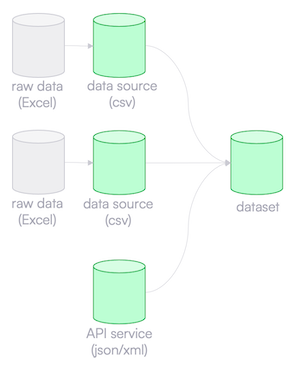

For the municipal datasets we use the following data sources:
* **??** | ...
* **Dataset manager** | to collect the parent dataset

For each data source, the following steps are followed:
* **Extract** | Extracting the raw data from its source
* **Transform** | Transforming the raw data to a 'workable' format 
* **Load** | Writing the processed data to the intermediate data directory


In [ ]:
# TODO

### 2. Data quality

In [ ]:
# TODO

#### Setup

Setup the checker and load all files from the `data / intermediate` directory.

First, setup the checker class

In [ ]:
# Initialise checker class to access transformation functions
checker = Checker()

Then, setup all data files:
- ...
- parent data

### 3. Data transformation

In [ ]:
# TODO

#### Setup

Setup the transformer and load all intermediate data files for the next step in the pipeline.

First, setup the transformer class:

In [ ]:
# Initialise transformer class to access transformation functions
transformer = Transformer(municipalities, year)

Then, setup all data files:
- dataframe representing data.csv 
- commits.yml
- dataframe with all etlocal interface elements
- ...
- parent data

##### Load parent data

In [ ]:
# Import parent data
path = Path("data", "intermediate", "parent_data.csv")
df_parent = pd.read_csv(path, index_col=0)

# Preview parent data
df_parent.T.head()

,nl
agriculture_final_demand_electricity_demand,41584.615
agriculture_final_demand_network_gas_demand,91072.918
input_agriculture_final_demand_steam_hot_water_demand,2783.107
agriculture_final_demand_wood_pellets_demand,5437.224
input_agriculture_final_demand_crude_oil_demand,17965.442


#### Energy demand
Transform the energy demand data to the right format. 

##### List ETLocal keys

Preview the ETLocal keys that are relevant for the services energy demand category

In [ ]:
# Filter the ETLocal keys that are relevant for the services energy demand category
filter_buildings_demand = (slice(None), 'buildings', 'buildings_energy_demand')

# Preview the filtered template
template.loc[filter_buildings_demand, :]

unit  \
geo_id group     subgroup                key                                                       
GM0003 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...    %   
                                         input_percentage_of_mt_steam_hot_water_building...    %   
                                         input_percentage_of_ht_steam_hot_water_building...    %   
GM0010 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...    %   
                                         input_percentage_of_mt_steam_hot_water_building...    %   
...                                                                                          ...   
GM0642 buildings buildings_energy_demand input_percentage_of_mt_steam_hot_water_building...    %   
                                         input_percentage_of_ht_steam_hot_water_building...    %   
GM0193 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...    %   
                                         input_percentage_of_mt_steam_hot_water_building...    %   
                                         input_percentage_of_ht_steam_hot_water_building...    %   

                                                                                             value  \
geo_id group     subgroup                key                                                         
GM0003 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...    NaN   
                                         input_percentage_of_mt_steam_hot_water_building...    NaN   
                                         input_percentage_of_ht_steam_hot_water_building...    NaN   
GM0010 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...    NaN   
                                         input_percentage_of_mt_steam_hot_water_building...    NaN   
...                                                                                            ...   
GM0642 buildings buildings_energy_demand input_percentage_of_mt_steam_hot_water_building...    NaN   
                                         input_percentage_of_ht_steam_hot_water_building...    NaN   
GM0193 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...    NaN   
                                         input_percentage_of_mt_steam_hot_water_building...    NaN   
                                         input_percentage_of_ht_steam_hot_water_building...    NaN   

                                                                                            commit  
geo_id group     subgroup                key                                                        
GM0003 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...    NaN  
                                         input_percentage_of_mt_steam_hot_water_building...    NaN  
                                         input_percentage_of_ht_steam_hot_water_building...    NaN  
GM0010 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...    NaN  
                                         input_percentage_of_mt_steam_hot_water_building...    NaN  
...                                                                                            ...  
GM0642 buildings buildings_energy_demand input_percentage_of_mt_steam_hot_water_building...    NaN  
                                         input_percentage_of_ht_steam_hot_water_building...    NaN  
GM0193 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...    NaN  
                                         input_percentage_of_mt_steam_hot_water_building...    NaN  
                                         input_percentage_of_ht_steam_hot_water_building...    NaN  

[1065 rows x 3 columns]

##### Fill missing values

Then, fill the missing values for:
- Temperature levels of district heating networks
- ...

**Temperature levels of district heating networks** | Klimaatmonitor doesn't provide any data about the demand of district heating networks per temperature level. Hence, we assume that all residential district heating networks require MT heat.

In [ ]:
# TODO: we could also use the parent data shares instead?
for temperature_level in ['lt', 'mt', 'ht']:
    key = f'input_percentage_of_{temperature_level}_steam_hot_water_buildings_final_demand_steam_hot_water'
    
    val = 0.
    
    if temperature_level == 'ht':
        val = 1.
    
    # Update value and corresponding commit message for the temperature level share
    template.loc[(slice(None), slice(None), slice(None), key), 'value'] = val
    template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"No data available. Fallback value set to {val} to ensure share totals sum to 1."

In [ ]:
# Preview template after changes
template.loc[filter_buildings_demand, :].head()

unit  \
geo_id group     subgroup                key                                                       
GM0003 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...    %   
                                         input_percentage_of_mt_steam_hot_water_building...    %   
                                         input_percentage_of_ht_steam_hot_water_building...    %   
GM0010 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...    %   
                                         input_percentage_of_mt_steam_hot_water_building...    %   

                                                                                             value  \
geo_id group     subgroup                key                                                         
GM0003 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...    0.0   
                                         input_percentage_of_mt_steam_hot_water_building...    0.0   
                                         input_percentage_of_ht_steam_hot_water_building...    1.0   
GM0010 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...    0.0   
                                         input_percentage_of_mt_steam_hot_water_building...    0.0   

                                                                                                                                        commit  
geo_id group     subgroup                key                                                                                                    
GM0003 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...  No data available. Fallback value set to 0.0 t...  
                                         input_percentage_of_mt_steam_hot_water_building...  No data available. Fallback value set to 0.0 t...  
                                         input_percentage_of_ht_steam_hot_water_building...  No data available. Fallback value set to 1.0 t...  
GM0010 buildings buildings_energy_demand input_percentage_of_lt_steam_hot_water_building...  No data available. Fallback value set to 0.0 t...  
                                         input_percentage_of_mt_steam_hot_water_building...  No data available. Fallback value set to 0.0 t...

### 4. Data analysis and visualisation

In [ ]:
# TODO

## Agriculture

### 1. Data collection

In [ ]:
# TODO

In the data collection phase, we make an overview of the required data and design a data model to efficiently build our database. If possible, we call the API to collect our data. Otherwise, we first manually collect a data export and store it in the `data / raw` directory.

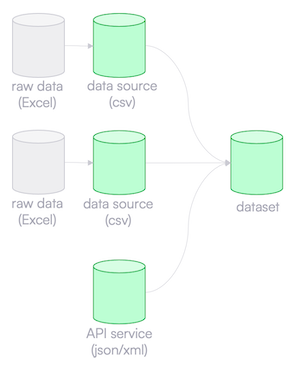

For the municipal datasets we use the following data sources:
* **??** | ...
* **Dataset manager** | to collect the parent dataset

For each data source, the following steps are followed:
* **Extract** | Extracting the raw data from its source
* **Transform** | Transforming the raw data to a 'workable' format 
* **Load** | Writing the processed data to the intermediate data directory


In [ ]:
# TODO

### 2. Data quality

In [ ]:
# TODO

#### Setup

Setup the checker and load all files from the `data / intermediate` directory.

First, setup the checker class

In [ ]:
# Initialise checker class to access transformation functions
checker = Checker()

Then, setup all data files:
- ...
- parent data

### 3. Data transformation

In [ ]:
# TODO

#### Setup

Setup the transformer and load all intermediate data files for the next step in the pipeline.

First, setup the transformer class:

In [ ]:
# Initialise transformer class to access transformation functions
transformer = Transformer(municipalities, year)

Then, setup all data files:
- dataframe representing data.csv 
- commits.yml
- dataframe with all etlocal interface elements
- ...
- parent data

##### Load parent data

In [ ]:
# Import parent data
path = Path("data", "intermediate", "parent_data.csv")
df_parent = pd.read_csv(path, index_col=0)

# Preview parent data
df_parent.T.head()

,nl
agriculture_final_demand_electricity_demand,41584.615
agriculture_final_demand_network_gas_demand,91072.918
input_agriculture_final_demand_steam_hot_water_demand,2783.107
agriculture_final_demand_wood_pellets_demand,5437.224
input_agriculture_final_demand_crude_oil_demand,17965.442


#### Energy demand
Transform the energy demand data from Klimaatmonitor to the right format. 

##### List ETLocal keys

Preview the ETLocal keys that are relevant for the agriculture energy demand category

In [ ]:
# Filter the ETLocal keys that are relevant for the agriculture energy demand category
filter_agriculture_demand = (slice(None), 'agriculture', 'agriculture_energy_demand')

# Preview the filtered template
template.loc[filter_agriculture_demand, :]

unit  \
geo_id group       subgroup                  key                                                       
GM0003 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...    %   
                                             input_percentage_of_central_ht_steam_hot_water_...    %   
                                             input_percentage_of_local_steam_hot_water_agric...    %   
GM0010 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...    %   
                                             input_percentage_of_central_ht_steam_hot_water_...    %   
...                                                                                              ...   
GM0642 agriculture agriculture_energy_demand input_percentage_of_central_ht_steam_hot_water_...    %   
                                             input_percentage_of_local_steam_hot_water_agric...    %   
GM0193 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...    %   
                                             input_percentage_of_central_ht_steam_hot_water_...    %   
                                             input_percentage_of_local_steam_hot_water_agric...    %   

                                                                                                 value  \
geo_id group       subgroup                  key                                                         
GM0003 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...    NaN   
                                             input_percentage_of_central_ht_steam_hot_water_...    NaN   
                                             input_percentage_of_local_steam_hot_water_agric...    NaN   
GM0010 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...    NaN   
                                             input_percentage_of_central_ht_steam_hot_water_...    NaN   
...                                                                                                ...   
GM0642 agriculture agriculture_energy_demand input_percentage_of_central_ht_steam_hot_water_...    NaN   
                                             input_percentage_of_local_steam_hot_water_agric...    NaN   
GM0193 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...    NaN   
                                             input_percentage_of_central_ht_steam_hot_water_...    NaN   
                                             input_percentage_of_local_steam_hot_water_agric...    NaN   

                                                                                                commit  
geo_id group       subgroup                  key                                                        
GM0003 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...    NaN  
                                             input_percentage_of_central_ht_steam_hot_water_...    NaN  
                                             input_percentage_of_local_steam_hot_water_agric...    NaN  
GM0010 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...    NaN  
                                             input_percentage_of_central_ht_steam_hot_water_...    NaN  
...                                                                                                ...  
GM0642 agriculture agriculture_energy_demand input_percentage_of_central_ht_steam_hot_water_...    NaN  
                                             input_percentage_of_local_steam_hot_water_agric...    NaN  
GM0193 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...    NaN  
                                             input_percentage_of_central_ht_steam_hot_water_...    NaN  
                                             input_percentage_of_local_steam_hot_water_agric...    NaN  

##### Fill missing values

Then, fill the missing values for:
- Temperature levels of district heating networks
- ...

**Temperature levels of district heating networks** | Klimaatmonitor doesn't provide any data about the demand of district heating networks per temperature level. Hence, we assume that all agricultural district heating networks require MT heat.

In [ ]:
# TODO: we could also use the parent data shares instead?
for temperature_level in ['mt', 'ht']:
    key = f'input_percentage_of_central_{temperature_level}_steam_hot_water_agriculture_final_demand_steam_hot_water'
    
    val = 0.
    
    if temperature_level == 'ht':
        val = 1.
    
    # Update value and corresponding commit message for the temperature level share
    template.loc[(slice(None), slice(None), slice(None), key), 'value'] = val
    template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"No data available. Fallback value set to {val} to ensure share totals sum to 1."

In [ ]:
key = f'input_percentage_of_local_steam_hot_water_agriculture_final_demand_steam_hot_water'

val = 0.

# Update value and corresponding commit message for the temperature level share
template.loc[(slice(None), slice(None), slice(None), key), 'value'] = val
template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"No data available. Fallback value set to {val} to ensure share totals sum to 1."

In [ ]:
# Preview template after changes
template.loc[filter_agriculture_demand, :].head()

unit  \
geo_id group       subgroup                  key                                                       
GM0003 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...    %   
                                             input_percentage_of_central_ht_steam_hot_water_...    %   
                                             input_percentage_of_local_steam_hot_water_agric...    %   
GM0010 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...    %   
                                             input_percentage_of_central_ht_steam_hot_water_...    %   

                                                                                                 value  \
geo_id group       subgroup                  key                                                         
GM0003 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...    0.0   
                                             input_percentage_of_central_ht_steam_hot_water_...    1.0   
                                             input_percentage_of_local_steam_hot_water_agric...    0.0   
GM0010 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...    0.0   
                                             input_percentage_of_central_ht_steam_hot_water_...    1.0   

                                                                                                                                            commit  
geo_id group       subgroup                  key                                                                                                    
GM0003 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...  No data available. Fallback value set to 0.0 t...  
                                             input_percentage_of_central_ht_steam_hot_water_...  No data available. Fallback value set to 1.0 t...  
                                             input_percentage_of_local_steam_hot_water_agric...  No data available. Fallback value set to 0.0 t...  
GM0010 agriculture agriculture_energy_demand input_percentage_of_central_mt_steam_hot_water_...  No data available. Fallback value set to 0.0 t...  
                                             input_percentage_of_central_ht_steam_hot_water_...  No data available. Fallback value set to 1.0 t...

#### Exceptions

If there are any exceptions for municipal datasets, you can overwrite the values below.

**TO DO** | Explain to the user that this section should always be checked. Should the exception be overwritten by the update? Or should it remain untouched?

##### Gemeente X

In [ ]:
#

#### Export processed data
Write the transformed data to our  `data / processed` directory. This is the data we will be using for the next (analysis and visualisation) steps in the pipeline.

In [ ]:
# Write dataframe to intermediate data folder
path = Path("data", "processed", "etlocal_template.csv")
template.to_csv(path)

### 4. Data analysis and visualisation

In [ ]:
# TODO

## Transport

### 1. Data collection

In [ ]:
# TODO

In the data collection phase, we make an overview of the required data and design a data model to efficiently build our database. If possible, we call the API to collect our data. Otherwise, we first manually collect a data export and store it in the `data / raw` directory.

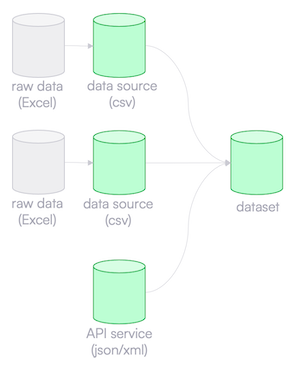

For the municipal datasets we use the following data sources:
* **??** | ...
* **Dataset manager** | to collect the parent dataset

For each data source, the following steps are followed:
* **Extract** | Extracting the raw data from its source
* **Transform** | Transforming the raw data to a 'workable' format 
* **Load** | Writing the processed data to the intermediate data directory


In [ ]:
# TODO

### 2. Data quality

In [ ]:
# TODO

#### Setup

Setup the checker and load all files from the `data / intermediate` directory.

First, setup the checker class

In [ ]:
# Initialise checker class to access transformation functions
checker = Checker()

Then, setup all data files:
- ...
- parent data

### 3. Data transformation

In [ ]:
# TODO

#### Setup

Setup the transformer and load all intermediate data files for the next step in the pipeline.

First, setup the transformer class:

In [ ]:
# Initialise transformer class to access transformation functions
transformer = Transformer(municipalities, year)

Then, setup all data files:
- dataframe representing data.csv 
- commits.yml
- dataframe with all etlocal interface elements
- ...
- parent data

##### Load parent data

In [ ]:
# Import parent data
path = Path("data", "intermediate", "parent_data.csv")
df_parent = pd.read_csv(path, index_col=0)

# Preview parent data
df_parent.T.head()

,nl
agriculture_final_demand_electricity_demand,41584.615
agriculture_final_demand_network_gas_demand,91072.918
input_agriculture_final_demand_steam_hot_water_demand,2783.107
agriculture_final_demand_wood_pellets_demand,5437.224
input_agriculture_final_demand_crude_oil_demand,17965.442


#### Energy demand
Transform the energy demand data from Klimaatmonitor to the right format. 

##### List ETLocal keys

Preview the ETLocal keys that are relevant for the transport energy demand category

In [ ]:
# # Filter the ETLocal keys that are relevant for the agriculture energy demand category
# filter_transport_demand = (slice(None), 'transport', 'transport_energy_demand')

# # Preview the filtered template
# template.loc[filter_transport_demand, :]

##### Fill missing values

Then, fill the missing values for:
- ...

**??** | ..

In [ ]:
# # Preview template after changes
# template.loc[filter_transport_demand, :].head()

#### Exceptions

If there are any exceptions for municipal datasets, you can overwrite the values below.

**TO DO** | Explain to the user that this section should always be checked. Should the exception be overwritten by the update? Or should it remain untouched?

##### Gemeente X

In [ ]:
#

#### Export processed data
Write the transformed data to our  `data / processed` directory. This is the data we will be using for the next (analysis and visualisation) steps in the pipeline.

In [ ]:
# Write dataframe to intermediate data folder
path = Path("data", "processed", "etlocal_template.csv")
template.to_csv(path)

### 4. Data analysis and visualisation

In [ ]:
# TODO

## Industry

In [ ]:
# TODO

### 1. Data collection

In [ ]:
# TODO

In the data collection phase, we make an overview of the required data and design a data model to efficiently build our database. If possible, we call the API to collect our data. Otherwise, we first manually collect a data export and store it in the `data / raw` directory.

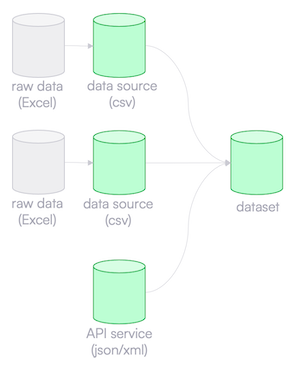

For the municipal datasets we use the following data sources:
* **??** | ...
* **Dataset manager** | to collect the parent dataset

For each data source, the following steps are followed:
* **Extract** | Extracting the raw data from its source
* **Transform** | Transforming the raw data to a 'workable' format 
* **Load** | Writing the processed data to the intermediate data directory


In [ ]:
# TODO

### 2. Data quality

In [ ]:
# TODO

#### Setup

Setup the checker and load all files from the `data / intermediate` directory.

First, setup the checker class

In [ ]:
# Initialise checker class to access transformation functions
checker = Checker()

Then, setup all data files:
- ...
- parent data

### 3. Data transformation

In [ ]:
# TODO

#### Setup

Setup the transformer and load all intermediate data files for the next step in the pipeline.

First, setup the transformer class:

In [ ]:
# Initialise transformer class to access transformation functions
transformer = Transformer(municipalities, year)

Then, setup all data files:
- dataframe representing data.csv 
- commits.yml
- dataframe with all etlocal interface elements
- ...
- parent data

##### Load parent data

In [ ]:
# Import parent data
path = Path("data", "intermediate", "parent_data.csv")
df_parent = pd.read_csv(path, index_col=0)

# Preview parent data
df_parent.T.head()

,nl
agriculture_final_demand_electricity_demand,41584.615
agriculture_final_demand_network_gas_demand,91072.918
input_agriculture_final_demand_steam_hot_water_demand,2783.107
agriculture_final_demand_wood_pellets_demand,5437.224
input_agriculture_final_demand_crude_oil_demand,17965.442


#### Energy demand
Transform the energy demand data from Klimaatmonitor to the right format. 

##### List ETLocal keys

Preview the ETLocal keys that are relevant for the industry energy demand category

In [ ]:
# # Filter the ETLocal keys that are relevant for the industry energy demand category
# filter_industry_demand = (slice(None), 'industry', 'industry_energy_demand')

# # Preview the filtered template
# template.loc[filter_industry_demand, :]

##### Fill missing values

Then, fill the missing values for:
- ...

**??** | ..

In [ ]:
# # Preview template after changes
# template.loc[filter_industry_demand, :].head()

#### Exceptions

If there are any exceptions for municipal datasets, you can overwrite the values below.

**TO DO** | Explain to the user that this section should always be checked. Should the exception be overwritten by the update? Or should it remain untouched?

##### Gemeente X

In [ ]:
#

#### Export processed data
Write the transformed data to our  `data / processed` directory. This is the data we will be using for the next (analysis and visualisation) steps in the pipeline.

In [ ]:
# Write dataframe to intermediate data folder
path = Path("data", "processed", "etlocal_template.csv")
template.to_csv(path)

### 4. Data analysis and visualisation

In [ ]:
# TODO

## Energy production

In [ ]:
# TODO

### 1. Data collection

In [ ]:
# TODO

In the data collection phase, we make an overview of the required data and design a data model to efficiently build our database. If possible, we call the API to collect our data. Otherwise, we first manually collect a data export and store it in the `data / raw` directory.

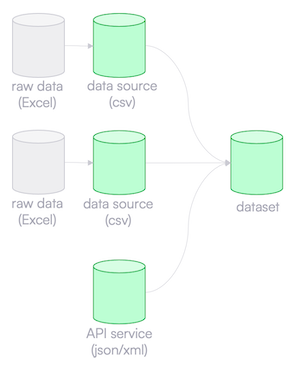

For the municipal datasets we use the following data sources:
* **??** | ...
* **Dataset manager** | to collect the parent dataset

For each data source, the following steps are followed:
* **Extract** | Extracting the raw data from its source
* **Transform** | Transforming the raw data to a 'workable' format 
* **Load** | Writing the processed data to the intermediate data directory


In [ ]:
# TODO

### 2. Data quality

In [ ]:
# TODO

#### Setup

Setup the checker and load all files from the `data / intermediate` directory.

First, setup the checker class

In [ ]:
# Initialise checker class to access transformation functions
checker = Checker()

Then, setup all data files:
- ...
- parent data

### 3. Data transformation

In [ ]:
# TODO

#### Setup

Setup the transformer and load all intermediate data files for the next step in the pipeline.

First, setup the transformer class:

In [ ]:
# Initialise transformer class to access transformation functions
transformer = Transformer(municipalities, year)

Then, setup all data files:
- dataframe representing data.csv 
- commits.yml
- dataframe with all etlocal interface elements
- ...
- parent data

##### Load parent data

In [ ]:
# Import parent data
path = Path("data", "intermediate", "parent_data.csv")
df_parent = pd.read_csv(path, index_col=0)

# Preview parent data
df_parent.T.head()

,nl
agriculture_final_demand_electricity_demand,41584.615
agriculture_final_demand_network_gas_demand,91072.918
input_agriculture_final_demand_steam_hot_water_demand,2783.107
agriculture_final_demand_wood_pellets_demand,5437.224
input_agriculture_final_demand_crude_oil_demand,17965.442


#### Energy demand (own use)
Transform the energy demand (own use) production data to the right format. 

##### List ETLocal keys

Preview the ETLocal keys that are relevant for the fossil electricity production category

In [ ]:
# Filter the ETLocal keys that are relevant for the energy demand (own use) category
filter_energy_energy_demand = (slice(None), 'energy', 'energy_energy_demand')

# Preview the filtered template
template.loc[filter_energy_energy_demand, :]

unit  \
geo_id group  subgroup             key                                                 
GM0003 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share    %   
                                   input_energy_heat_distribution_mt_loss_share    %   
                                   input_energy_heat_distribution_lt_loss_share    %   
GM0010 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share    %   
                                   input_energy_heat_distribution_mt_loss_share    %   
...                                                                              ...   
GM0642 energy energy_energy_demand input_energy_heat_distribution_mt_loss_share    %   
                                   input_energy_heat_distribution_lt_loss_share    %   
GM0193 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share    %   
                                   input_energy_heat_distribution_mt_loss_share    %   
                                   input_energy_heat_distribution_lt_loss_share    %   

                                                                                 value  \
geo_id group  subgroup             key                                                   
GM0003 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share    NaN   
                                   input_energy_heat_distribution_mt_loss_share    NaN   
                                   input_energy_heat_distribution_lt_loss_share    NaN   
GM0010 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share    NaN   
                                   input_energy_heat_distribution_mt_loss_share    NaN   
...                                                                                ...   
GM0642 energy energy_energy_demand input_energy_heat_distribution_mt_loss_share    NaN   
                                   input_energy_heat_distribution_lt_loss_share    NaN   
GM0193 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share    NaN   
                                   input_energy_heat_distribution_mt_loss_share    NaN   
                                   input_energy_heat_distribution_lt_loss_share    NaN   

                                                                                commit  
geo_id group  subgroup             key                                                  
GM0003 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share    NaN  
                                   input_energy_heat_distribution_mt_loss_share    NaN  
                                   input_energy_heat_distribution_lt_loss_share    NaN  
GM0010 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share    NaN  
                                   input_energy_heat_distribution_mt_loss_share    NaN  
...                                                                                ...  
GM0642 energy energy_energy_demand input_energy_heat_distribution_mt_loss_share    NaN  
                                   input_energy_heat_distribution_lt_loss_share    NaN  
GM0193 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share    NaN  
                                   input_energy_heat_distribution_mt_loss_share    NaN  
                                   input_energy_heat_distribution_lt_loss_share    NaN  

[1065 rows x 3 columns]

##### Fill missing values

Then, fill the missing values for:
- Heat network distribution losses
- ...

**Heat network distribution losses** | In the present situation we presume all residual heat networks to be HT. Hence, all distribution losses are allocated to HT networks.

In [ ]:
for temperature_level in ['lt', 'mt', 'ht']:
    key = f'input_energy_heat_distribution_{temperature_level}_loss_share'
    # The parent data hasn't been migrated yet so for now we're using a static value
    # val = df_parent[key]
    val = 100-75.71885721737949

    # Update value and corresponding commit message for the temperature level share
    template.loc[(slice(None), slice(None), slice(None), key), 'value'] = val
    template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"No data available. We assume the share of loss is equal to the parent dataset ({parent})."

**Preview** the template to see all changes

In [ ]:
# Preview template after changes
template.loc[filter_energy_energy_demand, :].head()

unit  \
geo_id group  subgroup             key                                                 
GM0003 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share    %   
                                   input_energy_heat_distribution_mt_loss_share    %   
                                   input_energy_heat_distribution_lt_loss_share    %   
GM0010 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share    %   
                                   input_energy_heat_distribution_mt_loss_share    %   

                                                                                     value  \
geo_id group  subgroup             key                                                       
GM0003 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share  24.281143   
                                   input_energy_heat_distribution_mt_loss_share  24.281143   
                                   input_energy_heat_distribution_lt_loss_share  24.281143   
GM0010 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share  24.281143   
                                   input_energy_heat_distribution_mt_loss_share  24.281143   

                                                                                                                            commit  
geo_id group  subgroup             key                                                                                              
GM0003 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share  No data available. We assume the share of loss...  
                                   input_energy_heat_distribution_mt_loss_share  No data available. We assume the share of loss...  
                                   input_energy_heat_distribution_lt_loss_share  No data available. We assume the share of loss...  
GM0010 energy energy_energy_demand input_energy_heat_distribution_ht_loss_share  No data available. We assume the share of loss...  
                                   input_energy_heat_distribution_mt_loss_share  No data available. We assume the share of loss...

#### Fossil electricity production
Transform the fossil electricity production data to the right format. 

##### List ETLocal keys

Preview the ETLocal keys that are relevant for the fossil electricity production category

In [ ]:
# Filter the ETLocal keys that are relevant for the fossil electricity production category
filter_fossil_electricity_production = (slice(None), 'energy', 'energy_fossil_electricity_production')

# Preview the filtered template
template.loc[filter_fossil_electricity_production, :]

unit  \
geo_id group  subgroup                             key                                                       
GM0003 energy energy_fossil_electricity_production input_energy_chp_ultra_supercritical_ht_coal_pr...   TJ   
                                                   input_energy_chp_ultra_supercritical_mt_coal_pr...   TJ   
                                                   input_energy_chp_ultra_supercritical_cofiring_h...   TJ   
                                                   input_energy_chp_ultra_supercritical_cofiring_m...   TJ   
                                                   input_energy_chp_ultra_supercritical_ht_lignite...   TJ   
...                                                                                                    ...   
GM0193 energy energy_fossil_electricity_production input_energy_chp_ultra_supercritical_mt_lignite...   TJ   
                                                   input_energy_chp_combined_cycle_ht_network_gas_...   TJ   
                                                   input_energy_chp_combined_cycle_mt_network_gas_...   TJ   
                                                   input_energy_chp_local_engine_ht_network_gas_pr...   TJ   
                                                   input_energy_chp_local_engine_mt_network_gas_pr...   TJ   

                                                                                                       value  \
geo_id group  subgroup                             key                                                         
GM0003 energy energy_fossil_electricity_production input_energy_chp_ultra_supercritical_ht_coal_pr...    NaN   
                                                   input_energy_chp_ultra_supercritical_mt_coal_pr...    NaN   
                                                   input_energy_chp_ultra_supercritical_cofiring_h...    NaN   
                                                   input_energy_chp_ultra_supercritical_cofiring_m...    NaN   
                                                   input_energy_chp_ultra_supercritical_ht_lignite...    NaN   
...                                                                                                      ...   
GM0193 energy energy_fossil_electricity_production input_energy_chp_ultra_supercritical_mt_lignite...    NaN   
                                                   input_energy_chp_combined_cycle_ht_network_gas_...    NaN   
                                                   input_energy_chp_combined_cycle_mt_network_gas_...    NaN   
                                                   input_energy_chp_local_engine_ht_network_gas_pr...    NaN   
                                                   input_energy_chp_local_engine_mt_network_gas_pr...    NaN   

                                                                                                      commit  
geo_id group  subgroup                             key                                                        
GM0003 energy energy_fossil_electricity_production input_energy_chp_ultra_supercritical_ht_coal_pr...    NaN  
                                                   input_energy_chp_ultra_supercritical_mt_coal_pr...    NaN  
                                                   input_energy_chp_ultra_supercritical_cofiring_h...    NaN  
                                                   input_energy_chp_ultra_supercritical_cofiring_m...    NaN  
                                                   input_energy_chp_ultra_supercritical_ht_lignite...    NaN  
...                                                                                                      ...  
GM0193 energy energy_fossil_electricity_production input_energy_chp_ultra_supercritical_mt_lignite...    NaN  
                                                   input_energy_chp_combined_cycle_ht_network_gas_...    NaN  
                                                   input_energy_chp_combined_cycle_mt_network_gas_...   

##### Fill missing values

Then, fill the missing values for:
- MT CHPs
- ...

**MT CHPs** | In the present situatie we presume all CHPs to produce HT heat, meaning the production of MT heat by CHPs can be set to zero for all producers.

In [ ]:
# TODO: we could also use the parent data shares instead?
for producer in ['ultra_supercritical_mt_coal', 'ultra_supercritical_cofiring_mt_coal', 'ultra_supercritical_mt_lignite', 'combined_cycle_mt_network_gas', 'local_engine_mt_network_gas']:
    key = f'input_energy_chp_{producer}_production'
    val = 0.
    
    # Update value and corresponding commit message for the temperature level share
    template.loc[(slice(None), slice(None), slice(None), key), 'value'] = val
    template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"No data available. All CHPs are assumed to produce only HT heat and zero MT heat."

**Preview** the template to see all changes

In [ ]:
# Preview template after changes
template.loc[filter_fossil_electricity_production, :].head()

unit  \
geo_id group  subgroup                             key                                                       
GM0003 energy energy_fossil_electricity_production input_energy_chp_ultra_supercritical_ht_coal_pr...   TJ   
                                                   input_energy_chp_ultra_supercritical_mt_coal_pr...   TJ   
                                                   input_energy_chp_ultra_supercritical_cofiring_h...   TJ   
                                                   input_energy_chp_ultra_supercritical_cofiring_m...   TJ   
                                                   input_energy_chp_ultra_supercritical_ht_lignite...   TJ   

                                                                                                       value  \
geo_id group  subgroup                             key                                                         
GM0003 energy energy_fossil_electricity_production input_energy_chp_ultra_supercritical_ht_coal_pr...    NaN   
                                                   input_energy_chp_ultra_supercritical_mt_coal_pr...    0.0   
                                                   input_energy_chp_ultra_supercritical_cofiring_h...    NaN   
                                                   input_energy_chp_ultra_supercritical_cofiring_m...    0.0   
                                                   input_energy_chp_ultra_supercritical_ht_lignite...    NaN   

                                                                                                                                                  commit  
geo_id group  subgroup                             key                                                                                                    
GM0003 energy energy_fossil_electricity_production input_energy_chp_ultra_supercritical_ht_coal_pr...                                                NaN  
                                                   input_energy_chp_ultra_supercritical_mt_coal_pr...  No data available. All CHPs are assumed to pro...  
                                                   input_energy_chp_ultra_supercritical_cofiring_h...                                                NaN  
                                                   input_energy_chp_ultra_supercritical_cofiring_m...  No data available. All CHPs are assumed to pro...  
                                                   input_energy_chp_ultra_supercritical_ht_lignite...                                                NaN

#### Renewable electricity production
Transform the renewable electricity production data to the right format. 

##### List ETLocal keys

Preview the ETLocal keys that are relevant for the renewable electricity production category

In [ ]:
# Filter the ETLocal keys that are relevant for the renewable electricity production category
filter_renewable_electricity_production = (slice(None), 'energy', 'energy_renewable_electricity_production')

# Preview the filtered template
template.loc[filter_renewable_electricity_production, :]

unit  \
geo_id group  subgroup                                key                                                       
GM0003 energy energy_renewable_electricity_production input_energy_chp_supercritical_ht_waste_mix_pro...   TJ   
                                                      input_energy_chp_supercritical_mt_waste_mix_pro...   TJ   
                                                      input_energy_chp_local_ht_wood_pellets_production    TJ   
                                                      input_energy_chp_local_mt_wood_pellets_production    TJ   
                                                      input_energy_chp_local_engine_ht_biogas_production   TJ   
...                                                                                                       ...   
GM0193 energy energy_renewable_electricity_production input_energy_chp_supercritical_mt_waste_mix_pro...   TJ   
                                                      input_energy_chp_local_ht_wood_pellets_production    TJ   
                                                      input_energy_chp_local_mt_wood_pellets_production    TJ   
                                                      input_energy_chp_local_engine_ht_biogas_production   TJ   
                                                      input_energy_chp_local_engine_mt_biogas_production   TJ   

                                                                                                          value  \
geo_id group  subgroup                                key                                                         
GM0003 energy energy_renewable_electricity_production input_energy_chp_supercritical_ht_waste_mix_pro...    NaN   
                                                      input_energy_chp_supercritical_mt_waste_mix_pro...    NaN   
                                                      input_energy_chp_local_ht_wood_pellets_production     NaN   
                                                      input_energy_chp_local_mt_wood_pellets_production     NaN   
                                                      input_energy_chp_local_engine_ht_biogas_production    NaN   
...                                                                                                         ...   
GM0193 energy energy_renewable_electricity_production input_energy_chp_supercritical_mt_waste_mix_pro...    NaN   
                                                      input_energy_chp_local_ht_wood_pellets_production     NaN   
                                                      input_energy_chp_local_mt_wood_pellets_production     NaN   
                                                      input_energy_chp_local_engine_ht_biogas_production    NaN   
                                                      input_energy_chp_local_engine_mt_biogas_production    NaN   

                                                                                                         commit  
geo_id group  subgroup                                key                                                        
GM0003 energy energy_renewable_electricity_production input_energy_chp_supercritical_ht_waste_mix_pro...    NaN  
                                                      input_energy_chp_supercritical_mt_waste_mix_pro...    NaN  
                                                      input_energy_chp_local_ht_wood_pellets_production     NaN  
                                                      input_energy_chp_local_mt_wood_pellets_production     NaN  
                                                      input_energy_chp_local_engine_ht_biogas_production    NaN  
...                                                                                                         ...  
GM0193 energy energy_renewable_electricity_production input_energy_chp_supercritical_mt_waste_mix_pro...    NaN  
                                                      input_energy_chp_local_ht_wood_pellets_production     NaN  

##### Fill missing values

Then, fill the missing values for:
- MT CHPs
- ...

**MT CHPs** | In the present situatie we presume all CHPs to produce HT heat, meaning the production of MT heat by CHPs can be set to zero for all producers.

In [ ]:
# TODO: we could also use the parent data shares instead?
for producer in ['supercritical_mt_waste_mix', 'local_mt_wood_pellets', 'local_engine_mt_biogas']:
    key = f'input_energy_chp_{producer}_production'
    val = 0.
    
    # Update value and corresponding commit message for the temperature level share
    template.loc[(slice(None), slice(None), slice(None), key), 'value'] = val
    template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"No data available. All CHPs are assumed to produce only HT heat and zero MT heat."

Preview the template to see all changes

In [ ]:
# Preview template after changes
template.loc[filter_renewable_electricity_production, :].head()

unit  \
geo_id group  subgroup                                key                                                       
GM0003 energy energy_renewable_electricity_production input_energy_chp_supercritical_ht_waste_mix_pro...   TJ   
                                                      input_energy_chp_supercritical_mt_waste_mix_pro...   TJ   
                                                      input_energy_chp_local_ht_wood_pellets_production    TJ   
                                                      input_energy_chp_local_mt_wood_pellets_production    TJ   
                                                      input_energy_chp_local_engine_ht_biogas_production   TJ   

                                                                                                          value  \
geo_id group  subgroup                                key                                                         
GM0003 energy energy_renewable_electricity_production input_energy_chp_supercritical_ht_waste_mix_pro...    NaN   
                                                      input_energy_chp_supercritical_mt_waste_mix_pro...    0.0   
                                                      input_energy_chp_local_ht_wood_pellets_production     NaN   
                                                      input_energy_chp_local_mt_wood_pellets_production     0.0   
                                                      input_energy_chp_local_engine_ht_biogas_production    NaN   

                                                                                                                                                     commit  
geo_id group  subgroup                                key                                                                                                    
GM0003 energy energy_renewable_electricity_production input_energy_chp_supercritical_ht_waste_mix_pro...                                                NaN  
                                                      input_energy_chp_supercritical_mt_waste_mix_pro...  No data available. All CHPs are assumed to pro...  
                                                      input_energy_chp_local_ht_wood_pellets_production                                                 NaN  
                                                      input_energy_chp_local_mt_wood_pellets_production   No data available. All CHPs are assumed to pro...  
                                                      input_energy_chp_local_engine_ht_biogas_production                                                NaN

#### Heat production
Transform the heat production data to the right format. 

##### List ETLocal keys

Preview the ETLocal keys that are relevant for the heat production category

In [ ]:
# Filter the ETLocal keys that are relevant for the energy heat production category
filter_energy_heat_production = (slice(None), 'energy', 'energy_heat_production')

# Preview the filtered template
template.loc[filter_energy_heat_production, :]

unit  \
geo_id group  subgroup               key                                                       
GM0003 energy energy_heat_production input_energy_heat_well_deep_ht_geothermal_produ...   TJ   
                                     input_energy_heat_well_deep_mt_geothermal_produ...   TJ   
                                     input_energy_heat_well_shallow_heatpump_mt_geot...   TJ   
                                     input_energy_heat_well_shallow_lt_geothermal_pr...   TJ   
                                     input_energy_heat_burner_ht_wood_pellets_produc...   TJ   
...                                                                                      ...   
GM0193 energy energy_heat_production input_energy_heat_burner_ht_crude_oil_production     TJ   
                                     input_energy_heat_burner_mt_crude_oil_production     TJ   
                                     energy_heat_import_lt_steam_hot_water_demand         TJ   
                                     energy_heat_import_mt_steam_hot_water_demand         TJ   
                                     energy_heat_import_ht_steam_hot_water_demand         TJ   

                                                                                         value  \
geo_id group  subgroup               key                                                         
GM0003 energy energy_heat_production input_energy_heat_well_deep_ht_geothermal_produ...    NaN   
                                     input_energy_heat_well_deep_mt_geothermal_produ...    NaN   
                                     input_energy_heat_well_shallow_heatpump_mt_geot...    NaN   
                                     input_energy_heat_well_shallow_lt_geothermal_pr...    NaN   
                                     input_energy_heat_burner_ht_wood_pellets_produc...    NaN   
...                                                                                        ...   
GM0193 energy energy_heat_production input_energy_heat_burner_ht_crude_oil_production      NaN   
                                     input_energy_heat_burner_mt_crude_oil_production      NaN   
                                     energy_heat_import_lt_steam_hot_water_demand          NaN   
                                     energy_heat_import_mt_steam_hot_water_demand          NaN   
                                     energy_heat_import_ht_steam_hot_water_demand          NaN   

                                                                                        commit  
geo_id group  subgroup               key                                                        
GM0003 energy energy_heat_production input_energy_heat_well_deep_ht_geothermal_produ...    NaN  
                                     input_energy_heat_well_deep_mt_geothermal_produ...    NaN  
                                     input_energy_heat_well_shallow_heatpump_mt_geot...    NaN  
                                     input_energy_heat_well_shallow_lt_geothermal_pr...    NaN  
                                     input_energy_heat_burner_ht_wood_pellets_produc...    NaN  
...                                                                                        ...  
GM0193 energy energy_heat_production input_energy_heat_burner_ht_crude_oil_production      NaN  
                                     input_energy_heat_burner_mt_crude_oil_production      NaN  
                                     energy_heat_import_lt_steam_hot_water_demand          NaN  
                                     energy_heat_import_mt_steam_hot_water_demand          NaN  
                                     energy_heat_import_ht_steam_hot_water_demand          NaN  

[10295 rows x 3 columns]

##### Fill missing values

Then, fill the missing values for:
- MT/LT heat production
- Imported heat
- ...

**MT/LT heat production** | In the present situation we presume all HT/MT producers to produce only HT heat, meaning the production of MT heat by those producers can be set to zero. Furthermore, there is no data available about LT heat production. Hence, we assume that all production of LT heat is zero.

In [ ]:
for producer in ['well_deep_mt_geothermal', 'burner_mt_wood_pellets', 'burner_mt_waste_mix', 'burner_lt_hydrogen', 'burner_mt_hydrogen', 'burner_mt_network_gas', 'heatpump_water_water_mt_electricity', 'boiler_mt_electricity', 'boiler_lt_electricity', 'burner_mt_coal', 'burner_mt_crude_oil']:
    key = f'input_energy_heat_{producer}_production'
    val = 0.
    
    # Update value and corresponding commit message for the temperature level share
    template.loc[(slice(None), slice(None), slice(None), key), 'value'] = val
    template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"No data available. All heat producers are assumed to produce only HT heat and zero MT or LT heat."

In [ ]:
for producer in ['well_shallow_heatpump_mt_geothermal', 'solar_mt_solar_thermal']:
    key = f'input_energy_heat_{producer}_production'
    val = 0.
    
    # Update value and corresponding commit message for the temperature level share
    template.loc[(slice(None), slice(None), slice(None), key), 'value'] = val
    template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"No data available. Production of MT heat is set to zero."

In [ ]:
for producer in ['well_shallow_lt_geothermal', 'heatpump_water_water_lt_electricity', 'solar_lt_solar_thermal']:
    key = f'input_energy_heat_{producer}_production'
    val = 0.
    
    # Update value and corresponding commit message for the temperature level share
    template.loc[(slice(None), slice(None), slice(None), key), 'value'] = val
    template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"No data available. Production of LT heat is set to zero."

**Imported heat** | In the present situation we assume no heat is imported.

In [ ]:
for temperature_level in ['lt', 'mt', 'ht']:
    # TODO: turn into method
    key = f'energy_heat_import_{temperature_level}_steam_hot_water_demand'
    val = 0.

    # Update value and corresponding commit message for the temperature level share
    template.loc[(slice(None), slice(None), slice(None), key), 'value'] = val
    template.loc[(slice(None), slice(None), slice(None), key), 'commit'] = f"No data available. By default, the import of heat is set to zero."

**Preview** the template to see all changes

In [ ]:
# Preview template after changes
template.loc[filter_energy_heat_production, :].head()

unit  \
geo_id group  subgroup               key                                                       
GM0003 energy energy_heat_production input_energy_heat_well_deep_ht_geothermal_produ...   TJ   
                                     input_energy_heat_well_deep_mt_geothermal_produ...   TJ   
                                     input_energy_heat_well_shallow_heatpump_mt_geot...   TJ   
                                     input_energy_heat_well_shallow_lt_geothermal_pr...   TJ   
                                     input_energy_heat_burner_ht_wood_pellets_produc...   TJ   

                                                                                         value  \
geo_id group  subgroup               key                                                         
GM0003 energy energy_heat_production input_energy_heat_well_deep_ht_geothermal_produ...    NaN   
                                     input_energy_heat_well_deep_mt_geothermal_produ...    0.0   
                                     input_energy_heat_well_shallow_heatpump_mt_geot...    0.0   
                                     input_energy_heat_well_shallow_lt_geothermal_pr...    0.0   
                                     input_energy_heat_burner_ht_wood_pellets_produc...    NaN   

                                                                                                                                    commit  
geo_id group  subgroup               key                                                                                                    
GM0003 energy energy_heat_production input_energy_heat_well_deep_ht_geothermal_produ...                                                NaN  
                                     input_energy_heat_well_deep_mt_geothermal_produ...  No data available. All heat producers are assu...  
                                     input_energy_heat_well_shallow_heatpump_mt_geot...  No data available. Production of MT heat is se...  
                                     input_energy_heat_well_shallow_lt_geothermal_pr...  No data available. Production of LT heat is se...  
                                     input_energy_heat_burner_ht_wood_pellets_produc...                                                NaN

#### Exceptions

If there are any exceptions for municipal datasets, you can overwrite the values below.

**TO DO** | Explain to the user that this section should always be checked. Should the exception be overwritten by the update? Or should it remain untouched?

##### Gemeente X

In [ ]:
#

#### Export processed data
Write the transformed data to our  `data / processed` directory. This is the data we will be using for the next (analysis and visualisation) steps in the pipeline.

In [ ]:
# Write dataframe to intermediate data folder
path = Path("data", "processed", "etlocal_template.csv")
template.to_csv(path)

### 4. Data analysis and visualisation

In [ ]:
# TODO

## Migration

#### Initialize migration files

In [ ]:
# First, initialize data.csv file based on the config file
path = Path("config", "data.csv")
df_data_csv = pd.read_csv(path, sep=sep, index_col=[0])

# Drop unnamed columns
df_data_csv = df_data_csv.drop(columns=df_data_csv.columns[df_data_csv.columns.str.startswith('Unnamed')])

In [ ]:
# Preview dataframe representing data.csv
df_data_csv

,country,name
geo_id,,
GM0003,nl2019,Appingedam
GM0010,nl2019,Delfzijl
GM0024,nl2019,Loppersum
GM1680,nl2019,Aa en Hunze
GM0358,nl2019,Aalsmeer
...,...,...
GM0879,nl2019,Zundert
GM0301,nl2019,Zutphen
GM1896,nl2019,Zwartewaterland


In [ ]:
# Then, initialize commits.yml file by specifying the file path where you want to create the YAML file
path = Path("data", "reporting", "commits.yml")

# Write the document separator to the YAML file
with open(path, 'w') as file:
    file.write('---\n')

#### Fill migration files
Fill the relevant processed data from the ETLocal template in the `data.csv` and `commits.yml` files that are necessary for a ETLocal migration.

In [ ]:
# Preview ETLocal template
template

unit  \
geo_id group      subgroup                 key                                                         
GM0003 area       area_emission_factors    file_carriers_imported_heat_co2_conversion_per_mj   kg/MJ   
                                           file_carriers_propane_co2_conversion_per_mj         kg/MJ   
       households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...      %   
                                           input_percentage_of_mt_steam_hot_water_househol...      %   
                                           input_percentage_of_ht_steam_hot_water_househol...      %   
...                                                                                              ...   
GM0193 energy     energy_heat_production   energy_heat_import_mt_steam_hot_water_demand           TJ   
                                           energy_heat_import_ht_steam_hot_water_demand           TJ   
                  energy_energy_demand     input_energy_heat_distribution_ht_loss_share            %   
                                           input_energy_heat_distribution_mt_loss_share            %   
                                           input_energy_heat_distribution_lt_loss_share            %   

                                                                                                   value  \
geo_id group      subgroup                 key                                                             
GM0003 area       area_emission_factors    file_carriers_imported_heat_co2_conversion_per_mj    0.036000   
                                           file_carriers_propane_co2_conversion_per_mj          0.064480   
       households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...   0.000000   
                                           input_percentage_of_mt_steam_hot_water_househol...   0.000000   
                                           input_percentage_of_ht_steam_hot_water_househol...   1.000000   
...                                                                                                  ...   
GM0193 energy     energy_heat_production   energy_heat_import_mt_steam_hot_water_demand         0.000000   
                                           energy_heat_import_ht_steam_hot_water_demand         0.000000   
                  energy_energy_demand     input_energy_heat_distribution_ht_loss_share        24.281143   
                                           input_energy_heat_distribution_mt_loss_share        24.281143   
                                           input_energy_heat_distribution_lt_loss_share        24.281143   

                                                                                                                                          commit  
geo_id group      subgroup                 key                                                                                                    
GM0003 area       area_emission_factors    file_carriers_imported_heat_co2_conversion_per_mj   Based on https://www.co2emissiefactoren.nl/lij...  
                                           file_carriers_propane_co2_conversion_per_mj         Adopted from the parent dataset (the Netherlands)  
       households households_energy_demand input_percentage_of_lt_steam_hot_water_househol...  No data available. Fallback value set to 0.0 t...  
                                           input_percentage_of_mt_steam_hot_water_househol...  No data available. Fallback value set to 0.0 t...  
                                           input_percentage_of_ht_steam_hot_water_househol...  No data available. Fallback value set to 1.0 t...  
...                                                                                                                                          ...  
GM0193 energy     energy_heat_production   energy_heat_import_mt_steam_hot_water_demand        No data available. By default, the import of h...  
               

In [ ]:
# List all keys for which values have been added to the template
keys = list(template.dropna().index.get_level_values(3).unique())

# Preview list of keys
keys

['file_carriers_imported_heat_co2_conversion_per_mj',
 'file_carriers_propane_co2_conversion_per_mj',
 'input_percentage_of_lt_steam_hot_water_households_final_demand_steam_hot_water',
 'input_percentage_of_mt_steam_hot_water_households_final_demand_steam_hot_water',
 'input_percentage_of_ht_steam_hot_water_households_final_demand_steam_hot_water',
 'input_percentage_of_lt_steam_hot_water_buildings_final_demand_steam_hot_water',
 'input_percentage_of_mt_steam_hot_water_buildings_final_demand_steam_hot_water',
 'input_percentage_of_ht_steam_hot_water_buildings_final_demand_steam_hot_water',
 'input_percentage_of_central_mt_steam_hot_water_agriculture_final_demand_steam_hot_water',
 'input_percentage_of_central_ht_steam_hot_water_agriculture_final_demand_steam_hot_water',
 'input_percentage_of_local_steam_hot_water_agriculture_final_demand_steam_hot_water',
 'input_energy_chp_ultra_supercritical_mt_coal_production',
 'input_energy_chp_ultra_supercritical_cofiring_mt_coal_production',
 'i

In [ ]:
# Add keys to data.csv migration file
for key in keys:
    df_data_csv.loc[:, key] = float('nan')
    
# Preview data.csv
df_data_csv

,country,name,file_carriers_imported_heat_co2_conversion_per_mj,file_carriers_propane_co2_conversion_per_mj,input_percentage_of_lt_steam_hot_water_households_final_demand_steam_hot_water,input_percentage_of_mt_steam_hot_water_households_final_demand_steam_hot_water,input_percentage_of_ht_steam_hot_water_households_final_demand_steam_hot_water,input_percentage_of_lt_steam_hot_water_buildings_final_demand_steam_hot_water,input_percentage_of_mt_steam_hot_water_buildings_final_demand_steam_hot_water,input_percentage_of_ht_steam_hot_water_buildings_final_demand_steam_hot_water,...,input_energy_heat_boiler_lt_electricity_production,input_energy_heat_burner_mt_network_gas_production,input_energy_heat_burner_mt_coal_production,input_energy_heat_burner_mt_crude_oil_production,energy_heat_import_lt_steam_hot_water_demand,energy_heat_import_mt_steam_hot_water_demand,energy_heat_import_ht_steam_hot_water_demand,input_energy_heat_distribution_ht_loss_share,input_energy_heat_distribution_mt_loss_share,input_energy_heat_distribution_lt_loss_share
geo_id,,,,,,,,,,,,,,,,,,,,,
GM0003,nl2019,Appingedam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GM0010,nl2019,Delfzijl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GM0024,nl2019,Loppersum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GM1680,nl2019,Aa en Hunze,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GM0358,nl2019,Aalsmeer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM0879,nl2019,Zundert,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GM0301,nl2019,Zutphen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GM1896,nl2019,Zwartewaterland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Initialize an empty array for the commits
commits = []

# For all relevant keys and for each municipality fill data.csv and commits.yml
for key in keys:
    for municipality in municipalities:
        # Add data value to data.csv
        df_data_csv.loc[municipality, key] = template.loc[(municipality, slice(None), slice(None), key), 'value'].values[0]
        
    # Add commit message to commits.yml
    commits.append({'fields': [key], 'message': template.loc[(slice(None), slice(None), slice(None), key), 'commit'].values[0]})
    
# Preview data for all municipalities in the format required for the data.csv file
df_data_csv

,country,name,file_carriers_imported_heat_co2_conversion_per_mj,file_carriers_propane_co2_conversion_per_mj,input_percentage_of_lt_steam_hot_water_households_final_demand_steam_hot_water,input_percentage_of_mt_steam_hot_water_households_final_demand_steam_hot_water,input_percentage_of_ht_steam_hot_water_households_final_demand_steam_hot_water,input_percentage_of_lt_steam_hot_water_buildings_final_demand_steam_hot_water,input_percentage_of_mt_steam_hot_water_buildings_final_demand_steam_hot_water,input_percentage_of_ht_steam_hot_water_buildings_final_demand_steam_hot_water,...,input_energy_heat_boiler_lt_electricity_production,input_energy_heat_burner_mt_network_gas_production,input_energy_heat_burner_mt_coal_production,input_energy_heat_burner_mt_crude_oil_production,energy_heat_import_lt_steam_hot_water_demand,energy_heat_import_mt_steam_hot_water_demand,energy_heat_import_ht_steam_hot_water_demand,input_energy_heat_distribution_ht_loss_share,input_energy_heat_distribution_mt_loss_share,input_energy_heat_distribution_lt_loss_share
geo_id,,,,,,,,,,,,,,,,,,,,,
GM0003,nl2019,Appingedam,0.036,0.06448,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.281143,24.281143,24.281143
GM0010,nl2019,Delfzijl,0.036,0.06448,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.281143,24.281143,24.281143
GM0024,nl2019,Loppersum,0.036,0.06448,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.281143,24.281143,24.281143
GM1680,nl2019,Aa en Hunze,0.036,0.06448,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.281143,24.281143,24.281143
GM0358,nl2019,Aalsmeer,0.036,0.06448,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.281143,24.281143,24.281143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM0879,nl2019,Zundert,0.036,0.06448,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.281143,24.281143,24.281143
GM0301,nl2019,Zutphen,0.036,0.06448,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.281143,24.281143,24.281143
GM1896,nl2019,Zwartewaterland,0.036,0.06448,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.281143,24.281143,24.281143


In [ ]:
# Write data.csv to processed data directory
df_data_csv.to_csv(f"data/reporting/data.csv")

In [ ]:
# TODO: Beautify the yaml data and make it more readable
# commits_yaml = yaml.dump(commits, sort_keys=False, indent=4, default_flow_style=False, default_style='|')

# Write the updated data back to the YAML file
path = Path("data", "reporting", "commits.yml")

with open(path, 'w') as file:
    yaml.safe_dump(commits, file)